In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import scipy.io as spio
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter

import scipy.sparse as sp
import scipy.io as spio

import sklearn.linear_model as sklinear
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr

import scipy.optimize as spopt
from scipy.optimize import minimize

from scipy.stats import norm

def differential_prop_test(count_1, total_count_1, count_2, total_count_2) :
    p1_hat = count_1 / total_count_1
    p2_hat = count_2 / total_count_2
    p_hat = (count_1 + count_2) / (total_count_1 + total_count_2)
    
    z = (p1_hat - p2_hat) / np.sqrt(p_hat * (1. - p_hat) * (1. / total_count_1 + 1. / total_count_2))
    z_abs = np.abs(z)
    
    z_rv = norm()
    p_val = 2. * z_rv.sf(z_abs)
    log_p_val = np.log(2) + z_rv.logsf(z_abs)
    
    return p_val, log_p_val


In [2]:
save_suffix = '_wider_v2'

In [6]:
#Load apadb data

file_path = 'processed_data/leslie_apadb/final/'

index = np.load(file_path + 'leslie_apadb_index' + save_suffix + '.npy')

df = pd.read_csv(file_path + 'leslie_apadb_data' + save_suffix + '.csv', sep=',')
gene_index = np.load(file_path + 'apadb_gene_index' + save_suffix + '.npy')

leslie_cell_type_index = np.load(file_path + 'apadb_celltype_index' + save_suffix + '.npy')
leslie_cleavage_count_matrix_dict = spio.loadmat(file_path + 'apadb_cleavage_count' + save_suffix + '.mat')
leslie_cleavage_count_matrix_dict_wide = spio.loadmat(file_path + 'apadb_cleavage_count_wide_ext' + save_suffix + '.mat')

df['apadb_count_pooled'] = np.load(file_path + 'apadb_orig_count' + save_suffix + '.npy')
df['apadb_total_count_pooled'] = np.load(file_path + 'apadb_orig_total_count' + save_suffix + '.npy')

df['row_index'] = np.arange(len(df), dtype=np.int)

In [7]:
#Rename cell type names

new_cell_type_index = []
for cell_type in leslie_cell_type_index :
    new_cell_type_index.append(cell_type.replace('-', '').replace('.', '_'))
    
    leslie_cleavage_count_matrix_dict[cell_type.replace('-', '').replace('.', '_')] = leslie_cleavage_count_matrix_dict[cell_type]
    leslie_cleavage_count_matrix_dict_wide[cell_type.replace('-', '').replace('.', '_')] = leslie_cleavage_count_matrix_dict_wide[cell_type]
    
    if cell_type.replace('-', '').replace('.', '_') != cell_type :
        leslie_cleavage_count_matrix_dict[cell_type] = None
        leslie_cleavage_count_matrix_dict_wide[cell_type] = None

leslie_cell_type_index = np.array(new_cell_type_index, dtype=np.object)

In [8]:
#Do some pre-filtering

print('Size before filtering = ' + str(len(df)))

df = df.query("apadb_total_count_pooled >= 100 and num_sites >= 2 and pas != -1").copy().reset_index(drop=True)

print('Size after filtering = ' + str(len(df)))


Size before filtering = 59731
Size after filtering = 51964


In [9]:
#Load predictions

file_path = 'processed_data/leslie_apadb/final/predictions/'

df_predicted = pd.read_csv(file_path + 'leslie_apadb_data' + save_suffix + '_predicted.csv', sep=',').set_index('seq')
df_predicted['predicted_row_index'] = np.arange(len(df_predicted), dtype=np.int)

deep_features = np.array(spio.loadmat(file_path + 'leslie_apadb_data' + save_suffix + '_deepfeatures.mat')['deepfeatures'].todense())

cuts_predicted = spio.loadmat(file_path + 'leslie_apadb_data' + save_suffix + '_predicted_cuts_pasaligned.mat')['cuts']
cuts_predicted = sp.csr_matrix(sp.hstack([sp.csc_matrix(np.zeros((cuts_predicted.shape[0], 1))), sp.csc_matrix(cuts_predicted)]))

#Join predictions onto original dataframe

df = df.join(df_predicted, on='seq', how='left').copy()
df = df.drop_duplicates(subset='gene_id', keep='first').copy().reset_index(drop=True)

deep_features = deep_features[df['predicted_row_index'], :]
cuts_predicted = cuts_predicted[df['predicted_row_index'], :]

index = index[df['row_index']]
gene_index = gene_index[df['row_index']]

for cell_type_i, cell_type in enumerate(leslie_cell_type_index) :
    leslie_cleavage_count_matrix_dict[cell_type] = leslie_cleavage_count_matrix_dict[cell_type][df['row_index'], :]
    leslie_cleavage_count_matrix_dict_wide[cell_type] = leslie_cleavage_count_matrix_dict_wide[cell_type][df['row_index'], :]

df = df.drop(columns=['row_index', 'predicted_row_index'])
df['row_index'] = np.arange(len(df), dtype=np.int)

KeyboardInterrupt: 

In [8]:
#Add apadb tissue-specific counts to dataframe

tissue_dict = pickle.load(open('parsed_apa_tissue_dict.pickle', 'rb'))

#Pre-compute total counts per gene
for tissue in tissue_dict :
    for gene in tissue_dict[tissue] :
        total_count = 0
        tissue_sites = tissue_dict[tissue][gene]
        
        for tissue_site in tissue_sites :
            total_count += float(tissue_site['reads_supporting_site'])
        
        for tissue_site in tissue_sites :
            tissue_site['total_count'] = total_count


for tissue in tissue_dict :
    print('Aggregating counts for tissue = ' + str(tissue))
    
    tissue_counts = []
    tissue_total_counts = []
    
    for index, row in df.iterrows() :
        gene = row['gene']
        gene_id = row['gene_id']
        
        tissue_count = 0.
        tissue_total_count = 0.
        
        if gene in tissue_dict[tissue] and len(tissue_dict[tissue][gene]) > 0 :
            tissue_total_count = tissue_dict[tissue][gene][0]['total_count']
        
        cut_start = row['cut_start']
        cut_end = row['cut_end']

        if gene in tissue_dict[tissue] :
            tissue_sites = tissue_dict[tissue][gene]

            for tissue_site in tissue_sites :
                cand_start = int(tissue_site['start'])
                cand_end = int(tissue_site['end'])

                if (cand_start >= cut_start and cand_start <= cut_end) or (cand_end >= cut_start and cand_end <= cut_end) :
                    tissue_count = float(tissue_site['reads_supporting_site'])
                    break
        
        tissue_counts.append(tissue_count)
        tissue_total_counts.append(tissue_total_count)
    
    df['apadb_count_' + tissue] = tissue_counts
    df['apadb_total_count_' + tissue] = tissue_total_counts


Aggregating counts for tissue = kidney
Aggregating counts for tissue = pancreas
Aggregating counts for tissue = monocytes
Aggregating counts for tissue = all
Aggregating counts for tissue = pdac
Aggregating counts for tissue = prcc
Aggregating counts for tissue = full_blood
Aggregating counts for tissue = hlf


In [9]:
#Add leslie tissue-specific counts to dataframe

cut_start = 57
cut_end = 87

leslie_cleavage_count_matrix_pooled = sp.lil_matrix(leslie_cleavage_count_matrix_dict[leslie_cell_type_index[0]].shape)

for cell_type_i, cell_type in enumerate(leslie_cell_type_index) :
    print('Aggregating counts for cell type = ' + str(cell_type))
    
    leslie_cleavage_count_matrix = leslie_cleavage_count_matrix_dict[cell_type]
    leslie_cleavage_count_matrix_pooled += sp.coo_matrix(leslie_cleavage_count_matrix)
    
    leslie_site_counts = leslie_cleavage_count_matrix[:, cut_start:cut_end].sum(axis=1)
    
    df['leslie_count_' + cell_type] = leslie_site_counts
    df['leslie_total_count_' + cell_type] = df.groupby('gene')['leslie_count_' + cell_type].transform(lambda x : x.sum())


leslie_cleavage_count_matrix_pooled = sp.csr_matrix(leslie_cleavage_count_matrix_pooled)
leslie_site_counts_pooled = leslie_cleavage_count_matrix_pooled[:, cut_start:cut_end].sum(axis=1)

df['leslie_count_pooled'] = leslie_site_counts_pooled
df['leslie_total_count_pooled'] = df.groupby('gene')['leslie_count_pooled'].transform(lambda x : x.sum())

#Add apadb cut region measures

predicted_usage = []
predicted_logodds = []

leslie_cleavage_count_dense_matrix_dict = {}

leslie_count_dict_apadb_region = {}
for cell_type in leslie_cell_type_index :
    leslie_cleavage_count_dense_matrix_dict[cell_type] = np.array(leslie_cleavage_count_matrix_dict[cell_type].todense())
    
    leslie_count_dict_apadb_region[cell_type] = []
leslie_count_dict_apadb_region['pooled'] = []

i = 0
for _, row in df.iterrows() :
    
    if i % 10000 == 0 :
        print('Processing APA site ' + str(i) + '...')
    
    strand = row['strand']
    
    cut_start = row['cut_start']
    cut_end = row['cut_end']
    pas_pos = row['pas_pos']
    
    start = 0
    end = 1
    if strand == '+' :
        start = cut_start - pas_pos + 50
        end = cut_end - pas_pos + 50
    else :
        start = pas_pos - cut_end + 56
        end = pas_pos - cut_start + 56
    
    
    p_prob = np.sum(cuts_predicted[i, start:end])
    p_logodds = np.log(p_prob / (1. - p_prob))
    
    predicted_usage.append(p_prob)
    predicted_logodds.append(p_logodds)
    
    pooled_cuts = np.zeros(186)
    
    for cell_type in leslie_cell_type_index :
        cuts = leslie_cleavage_count_dense_matrix_dict[cell_type][i, :]#np.ravel(leslie_cleavage_count_matrix_dict[cell_type][i, :].todense())
        pooled_cuts += cuts
        
        tissue_count = np.sum(cuts[start:end])
        leslie_count_dict_apadb_region[cell_type].append(tissue_count)
    
    pooled_count = np.sum(pooled_cuts[start:end])
    leslie_count_dict_apadb_region['pooled'].append(pooled_count)
    
    i += 1


df['predicted_usage_apadb_region'] = predicted_usage
df['predicted_logodds_apadb_region'] = predicted_logodds

for cell_type in leslie_cell_type_index :
    print('Aggregating counts for cell type = ' + str(cell_type))
    
    df['leslie_count_apadb_region_' + cell_type] = leslie_count_dict_apadb_region[cell_type]
    df['leslie_total_count_apadb_region_' + cell_type] = df.groupby('gene')['leslie_count_apadb_region_' + cell_type].transform(lambda x : x.sum())
    
df['leslie_count_apadb_region_pooled'] = leslie_count_dict_apadb_region['pooled']
df['leslie_total_count_apadb_region_pooled'] = df.groupby('gene')['leslie_count_apadb_region_pooled'].transform(lambda x : x.sum())

leslie_cleavage_count_dense_matrix_dict = None

Aggregating counts for cell type = hek293
Aggregating counts for cell type = mcf10a_hras2
Aggregating counts for cell type = mcf10a1
Aggregating counts for cell type = mcf10a2
Aggregating counts for cell type = mcf10a_hras1
Aggregating counts for cell type = bcells1
Aggregating counts for cell type = mcf7
Aggregating counts for cell type = bcells2
Aggregating counts for cell type = ovary
Aggregating counts for cell type = breast
Aggregating counts for cell type = brain
Aggregating counts for cell type = skmuscle
Aggregating counts for cell type = blcl
Aggregating counts for cell type = hES
Aggregating counts for cell type = testis
Aggregating counts for cell type = hela
Aggregating counts for cell type = ntera
Processing APA site 0...
Processing APA site 10000...
Processing APA site 20000...
Processing APA site 30000...
Processing APA site 40000...
Processing APA site 50000...
Aggregating counts for cell type = hek293
Aggregating counts for cell type = mcf10a_hras2
Aggregating counts f

In [11]:
#Store processed data

save_suffix = '_combined_final_v2'

print('Size of dataframe = ' + str(len(df)))
print('Size of deep features = ' + str(deep_features.shape[0]))
print('Size of predicted cuts = ' + str(cuts_predicted.shape[0]))
print('Size of tissue cuts = ' + str(leslie_cleavage_count_matrix_dict['hek293'].shape))
print('Size of wide ext tissue cuts = ' + str(leslie_cleavage_count_matrix_dict_wide['hek293'].shape))

np.save('leslie_apadb_deepfeatures' + save_suffix, deep_features)
spio.savemat('leslie_apadb_predictedcuts' + save_suffix, {'cuts' : cuts_predicted})

leslie_cleavage_count_matrix_newdict = {}
for cell_type in leslie_cell_type_index :
    leslie_cleavage_count_matrix_newdict[cell_type] = leslie_cleavage_count_matrix_dict[cell_type]

leslie_cleavage_count_matrix_newdict_wide = {}
for cell_type in leslie_cell_type_index :
    leslie_cleavage_count_matrix_newdict_wide[cell_type] = leslie_cleavage_count_matrix_dict_wide[cell_type]

spio.savemat('leslie_apadb_observedcuts' + save_suffix, leslie_cleavage_count_matrix_newdict)
leslie_cleavage_count_matrix_newdict = None

spio.savemat('leslie_apadb_observedcuts_wide_ext' + save_suffix, leslie_cleavage_count_matrix_newdict_wide)
leslie_cleavage_count_matrix_newdict_wide = None

df.to_csv('leslie_apadb_data' + save_suffix + '.csv', sep=',')


Size of dataframe = 51964
Size of deep features = 51964
Size of predicted cuts = 51964
Size of tissue cuts = (51964, 186)
Size of wide ext tissue cuts = (51964, 356)


In [3]:
#Load processed data

save_suffix = '_combined_final_v2'

df = pd.read_csv('leslie_apadb_data' + save_suffix + '.csv', sep=',')

deep_features = np.load('leslie_apadb_deepfeatures' + save_suffix + '.npy')
cuts_predicted = spio.loadmat('leslie_apadb_predictedcuts' + save_suffix + '.mat')['cuts']
leslie_cleavage_count_matrix_dict = spio.loadmat('leslie_apadb_observedcuts' + save_suffix + '.mat')


In [4]:
leslie_tissue_index = np.array(['hek293', 'mcf10a_hras2', 'mcf10a1', 'mcf10a2', 'mcf10a_hras1', 'bcells1', 'mcf7', 'bcells2', 'ovary', 'breast', 'brain', 'skmuscle', 'blcl', 'hES', 'testis', 'hela', 'ntera'], dtype=np.object)
apadb_tissue_index = np.array(['kidney', 'pancreas', 'monocytes', 'all', 'pdac', 'prcc', 'full_blood', 'hlf'], dtype=np.object)

leslie_isoform_count_matrix = np.concatenate([np.ravel(df['leslie_count_' + tissue]).reshape(-1, 1) for tissue in leslie_tissue_index], axis=1)
apadb_isoform_count_matrix = np.concatenate([np.ravel(df['apadb_count_' + tissue]).reshape(-1, 1) for tissue in apadb_tissue_index], axis=1)

In [5]:
print('Leslie tissues = ' + str(leslie_tissue_index))
print('APADB tissues = ' + str(apadb_tissue_index))

Leslie tissues = ['hek293' 'mcf10a_hras2' 'mcf10a1' 'mcf10a2' 'mcf10a_hras1' 'bcells1'
 'mcf7' 'bcells2' 'ovary' 'breast' 'brain' 'skmuscle' 'blcl' 'hES'
 'testis' 'hela' 'ntera']
APADB tissues = ['kidney' 'pancreas' 'monocytes' 'all' 'pdac' 'prcc' 'full_blood' 'hlf']


In [6]:
#Basic leslie stats

#Total and Avg read count by non-zero genes

print('Leslie Total Read Count = ' + str(np.sum(df['leslie_count_pooled'])))
print('Leslie Avg Pooled Read Count = ' + str(np.mean(df['leslie_count_pooled'])))
print('Leslie Avg Pooled Read Count (Non-zero) = ' + str(np.mean(df.query("leslie_count_pooled > 0")['leslie_count_pooled'])))
print('Leslie Avg Read Count / Tissue = ' + str(np.mean(leslie_isoform_count_matrix)))

print('APADB Total Read Count = ' + str(np.sum(df['apadb_count_pooled'])))
print('APADB Avg Pooled Read Count = ' + str(np.mean(df['apadb_count_pooled'])))
print('APADB Avg Pooled Read Count (Non-zero) = ' + str(np.mean(df.query("apadb_count_pooled > 0")['apadb_count_pooled'])))
print('APADB Avg Read Count / Tissue = ' + str(np.mean(apadb_isoform_count_matrix)))


Leslie Total Read Count = 35748230.0
Leslie Avg Pooled Read Count = 687.9422292356246
Leslie Avg Pooled Read Count (Non-zero) = 1697.4468186134852
Leslie Avg Read Count / Tissue = 40.467189955036744
APADB Total Read Count = 16791397.0
APADB Avg Pooled Read Count = 323.13518974674776
APADB Avg Pooled Read Count (Non-zero) = 323.13518974674776
APADB Avg Read Count / Tissue = 40.61097827342006


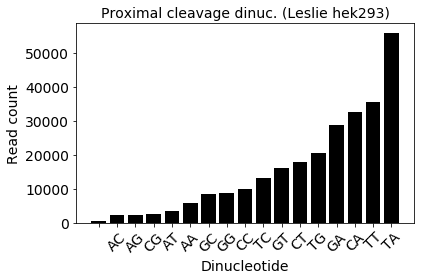

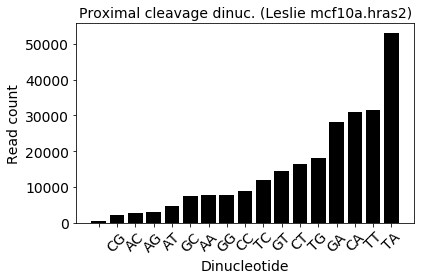

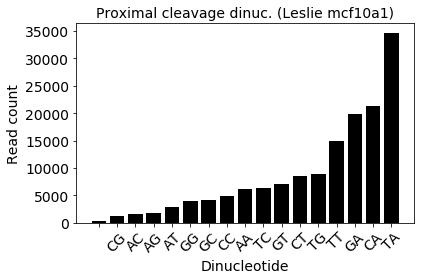

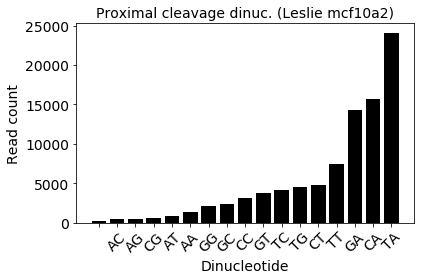

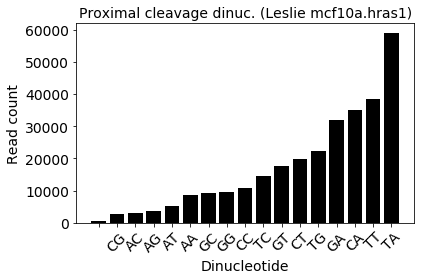

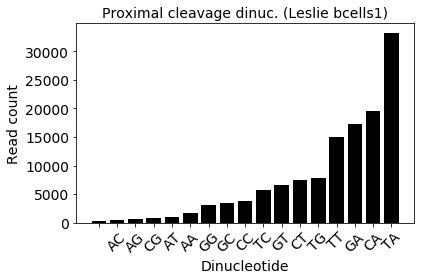

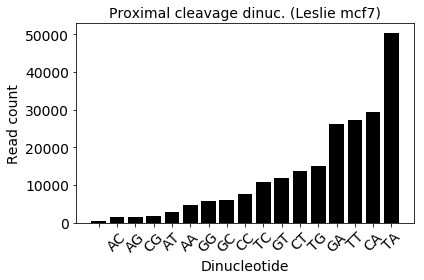

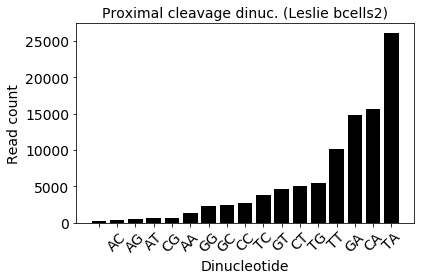

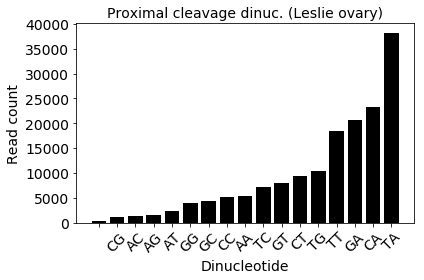

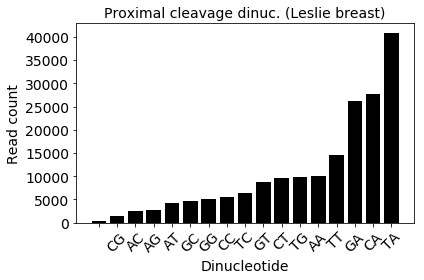

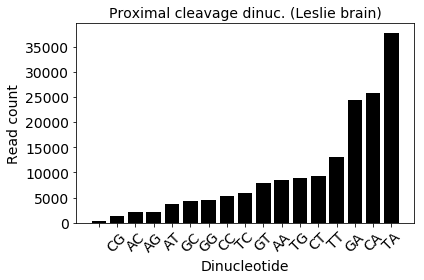

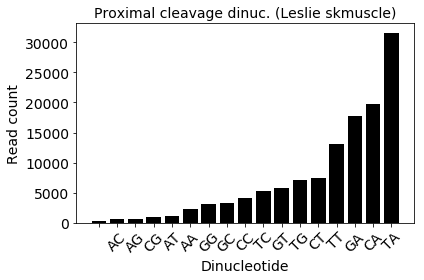

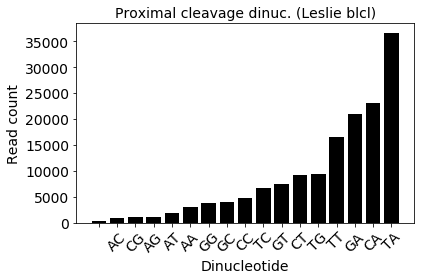

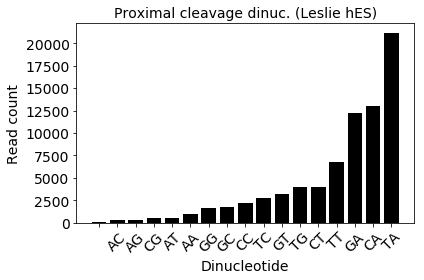

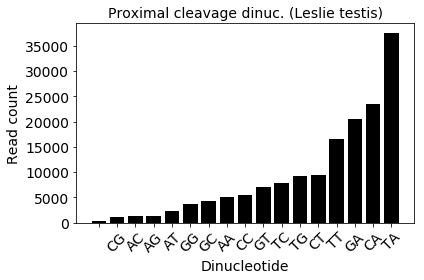

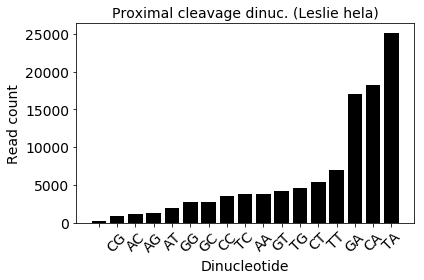

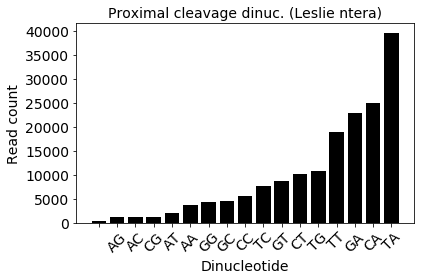

In [32]:
import operator

for tissue_i in range(0, len(leslie_tissue_index)) :
    cut_mer2 = {}
    cell_type = leslie_tissue_index[tissue_i]
    cleavage_mat = leslie_cleavage_count_matrix_dict[cell_type]

    cx = sp.coo_matrix(cleavage_mat)

    for i,j,v in zip(cx.row, cx.col, cx.data) :
        seq = df.iloc[i]['seq']

        mer2 = seq[j-1:j+1]
        if mer2 not in cut_mer2 :
            cut_mer2[mer2] = 0
        cut_mer2[mer2] += 1

    cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

    mer2_list = []
    mer2_vals = []
    for i in range(0, len(cut_mer2_sorted)) :
        mer2_list.append(cut_mer2_sorted[i][0])
        mer2_vals.append(cut_mer2_sorted[i][1])

    f = plt.figure(figsize=(6, 4))

    plt.bar(mer2_list, mer2_vals, color='black')

    plt.title('Proximal cleavage dinuc. (Leslie ' + cell_type + ')', fontsize=14)
    plt.xlabel('Dinucleotide', fontsize=14)
    plt.ylabel('Read count', fontsize=14)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

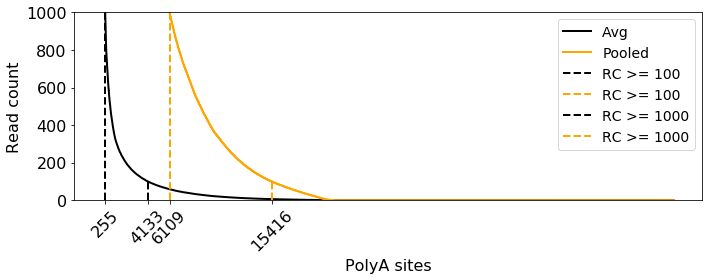

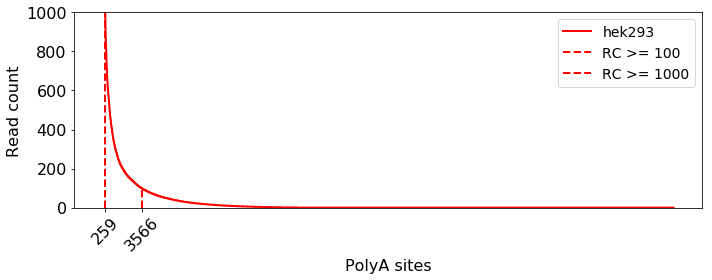

In [7]:
avg_isoform_count = np.mean(leslie_isoform_count_matrix, axis=1)
sum_isoform_count = np.sum(leslie_isoform_count_matrix, axis=1)
n_events = avg_isoform_count.shape[0]

sort_index = np.argsort(avg_isoform_count)[::-1]

f = plt.figure(figsize=(10, 4))

read_count_marks = [100, 1000]

ls = []

l_avg, = plt.plot(np.arange(n_events), avg_isoform_count[sort_index], c='black', linewidth=2, label='Avg')
ls.append(l_avg)

sum_sort_index = np.argsort(sum_isoform_count)[::-1]
l_sum, = plt.plot(np.arange(n_events), sum_isoform_count[sort_index], c='orange', linewidth=2, label='Pooled')
ls.append(l_sum)

#Avg marks
l_mark_coords = []
for read_count_mark in read_count_marks :
    n_marked_events = np.sum(avg_isoform_count >= read_count_mark)
    l_mark_coords.append(n_marked_events)
    l_mark, = plt.plot([n_marked_events, n_marked_events], [0, avg_isoform_count[sort_index][n_marked_events]], color='black', linestyle='--', linewidth=2, label='RC >= ' + str(read_count_mark))
    
    ls.append(l_mark)
    
    
    n_marked_events = np.sum(sum_isoform_count >= read_count_mark)
    l_mark_coords.append(n_marked_events)
    l_mark, = plt.plot([n_marked_events, n_marked_events], [0, sum_isoform_count[sum_sort_index][n_marked_events]], color='orange', linestyle='--', linewidth=2, label='RC >= ' + str(read_count_mark))
    
    ls.append(l_mark)

plt.xticks(l_mark_coords, l_mark_coords, fontsize=16, rotation=45)
plt.xlabel('PolyA sites', fontsize=16)

plt.yticks(fontsize=16)
plt.ylabel('Read count', fontsize=16)

plt.ylim(0, 1000)

plt.legend(handles=ls, fontsize=14)

plt.tight_layout()
#plt.savefig('leslie_apadb_read_distribution_pooled_avg.png')
plt.show()





f = plt.figure(figsize=(10, 4))

read_count_marks = [100, 1000]

ls = []

hek293_isoform_count = np.ravel(leslie_isoform_count_matrix[:, leslie_tissue_index == 'hek293'])
hek293_sort_index = np.argsort(hek293_isoform_count)[::-1]

l_hek293, = plt.plot(np.arange(n_events), hek293_isoform_count[hek293_sort_index], c='red', linewidth=2, label='hek293')
ls.append(l_hek293)

l_mark_coords = []
for read_count_mark in read_count_marks :
    n_marked_events = np.sum(hek293_isoform_count >= read_count_mark)
    l_mark_coords.append(n_marked_events)
    l_mark, = plt.plot([n_marked_events, n_marked_events], [0, hek293_isoform_count[hek293_sort_index][n_marked_events]], color='red', linestyle='--', linewidth=2, label='RC >= ' + str(read_count_mark))
    
    ls.append(l_mark)

plt.xticks(l_mark_coords, l_mark_coords, fontsize=16, rotation=45)
plt.xlabel('PolyA sites', fontsize=16)

plt.yticks(fontsize=16)
plt.ylabel('Read count', fontsize=16)

plt.ylim(0, 1000)

plt.legend(handles=ls, fontsize=14)

plt.tight_layout()
#plt.savefig('leslie_apadb_read_distribution_hek293.png')
plt.show()


Leslie


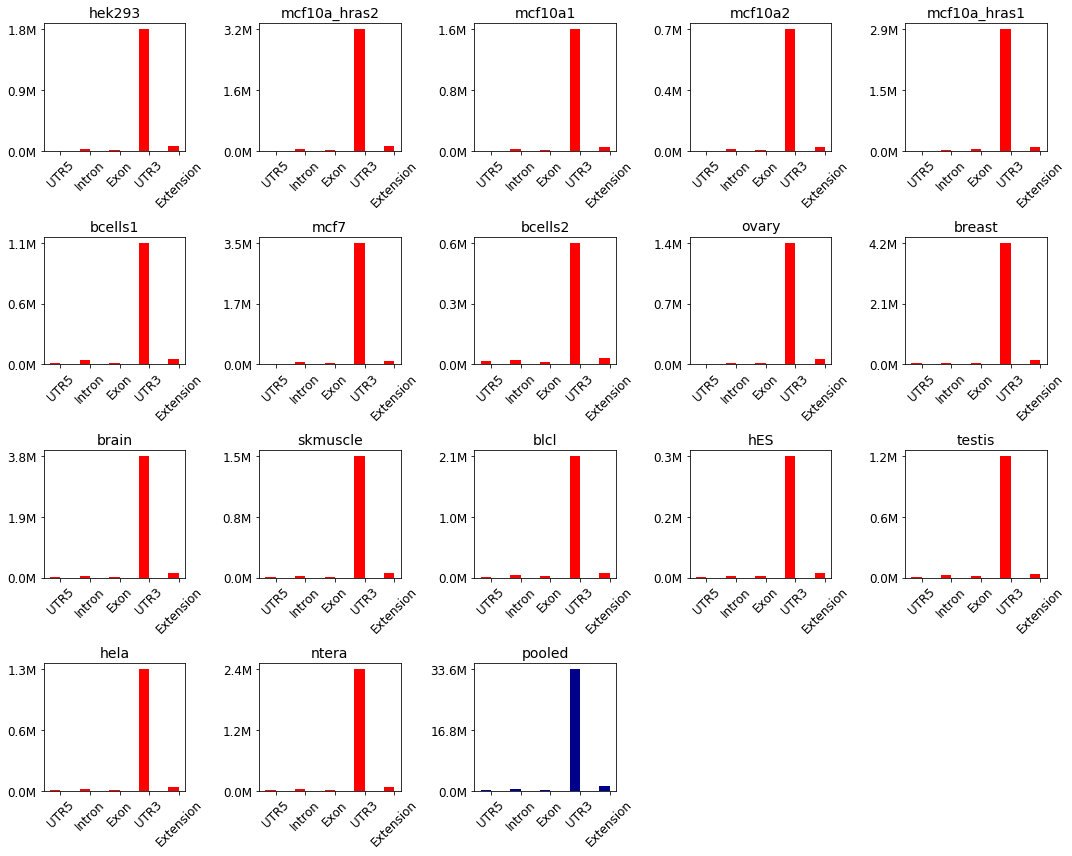

APADB


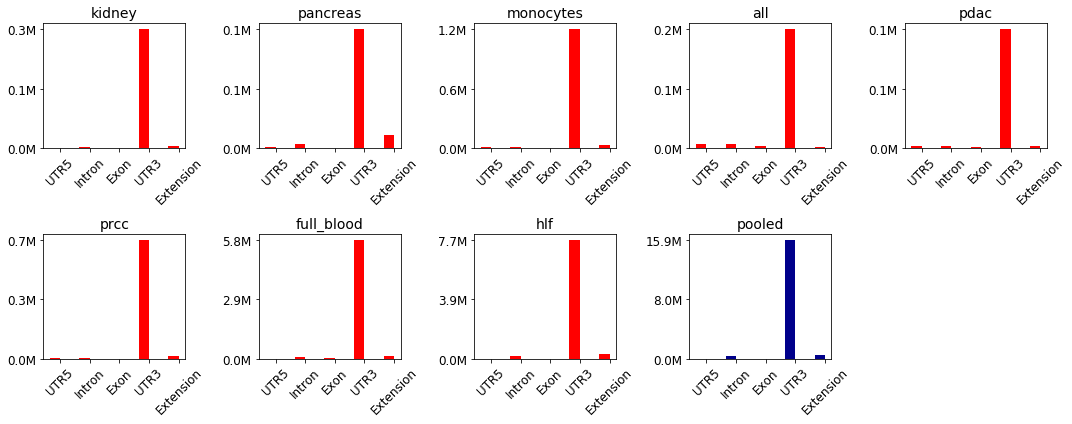

In [18]:
#Leslie tissue read count statistics

def plot_tissue_read_count_histo(df, source, tissue_index, n_rows=4, n_cols=5) :

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

    width = 0.35

    site_types = ['UTR5', 'Intron', 'Exon', 'UTR3', 'Extension']

    for row_i in range(0, n_rows) :
        for col_i in range(0, n_cols) :
            ax[row_i, col_i].axis('off')

    for tissue_i in range(0, len(tissue_index)) :
        tissue = tissue_index[tissue_i]

        row_i = int(tissue_i / n_cols)
        col_i = int(tissue_i % n_cols)

        ax[row_i, col_i].axis('on')

        site_type_i = 0

        read_counts = np.zeros(len(site_types))

        for site_type in site_types :
            read_counts[site_type_i] = np.sum(df.query("site_type == '" + site_type + "'")[source + '_count_' + tissue])
            site_type_i += 1

        p_color = 'r'
        if tissue == 'pooled' :
            p_color = 'darkblue'

        p1 = ax[row_i, col_i].bar(np.arange(len(site_types)), read_counts / (10.**6), width, color=p_color)

        ax[row_i, col_i].set_title(tissue, fontsize=14)

        ax[row_i, col_i].set_xticks(np.arange(len(site_types)) + width / 2)
        ax[row_i, col_i].set_xticklabels(site_types)
        ax[row_i, col_i].tick_params(axis='x', which='major', labelsize=12, rotation=45)
        ax[row_i, col_i].tick_params(axis='x', which='minor', labelsize=12, rotation=45)

        max_read_count = np.max(read_counts / (10.**6))
        ax[row_i, col_i].set_yticks([0.0, max_read_count * 0.5, max_read_count * 1.0])
        ax[row_i, col_i].yaxis.set_major_formatter(FormatStrFormatter('%.1fM'))
        ax[row_i, col_i].tick_params(axis='y', which='major', labelsize=12)
        ax[row_i, col_i].tick_params(axis='y', which='minor', labelsize=12)


    plt.tight_layout()
    plt.show()


print('Leslie')
leslie_tissue_index_extended = np.concatenate([leslie_tissue_index, np.array(['pooled'])])
plot_tissue_read_count_histo(df, 'leslie', leslie_tissue_index_extended, n_rows=4, n_cols=5)

print('APADB')
apadb_tissue_index_extended = np.concatenate([apadb_tissue_index, np.array(['pooled'])])
plot_tissue_read_count_histo(df, 'apadb', apadb_tissue_index_extended, n_rows=2, n_cols=5)

Leslie


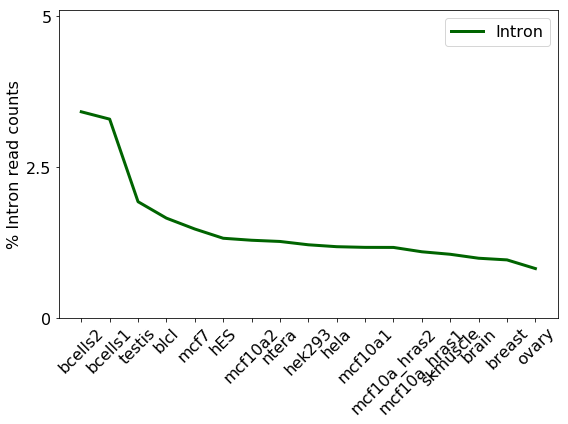

APADB


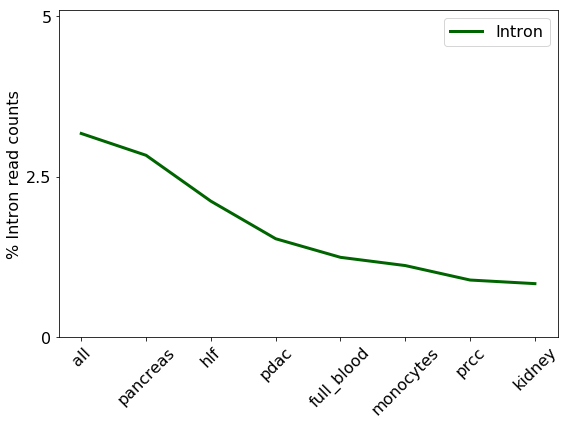

In [10]:

def plot_site_type_fractions(df, source, tissue_index) :

    fig = plt.figure(figsize=(8, 6))

    site_types = ['Intron']#['Intron', 'Exon', 'UTR3']

    type_frac = np.zeros((len(site_types), len(tissue_index)))

    for tissue_i in range(0, len(tissue_index)) :
        tissue = tissue_index[tissue_i]

        site_type_i = 0
        for site_type in site_types :

            type_count = np.ravel(df.query("site_type == '" + site_type + "'")[source + '_count_' + tissue])
            all_type_count = np.ravel(df[source + '_count_' + tissue])

            type_frac[site_type_i, tissue_i] = np.sum(type_count) / np.sum(all_type_count)

            site_type_i += 1


    sort_index = np.argsort(np.ravel(type_frac[0, :]))[::-1]

    ls = []
    site_color = ['darkgreen', 'darkred', 'darkblue']

    site_type_i = 0
    for site_type in site_types :
        l1, = plt.plot(np.arange(len(tissue_index)), type_frac[site_type_i, sort_index], c=site_color[site_type_i], label=site_type, linewidth=3)

        ls.append(l1)

        site_type_i += 1

    plt.xticks(np.arange(len(tissue_index)), tissue_index[sort_index], fontsize=16, rotation=45)

    plt.ylim(0, 0.051)
    plt.yticks([0.0, 0.025, 0.05], [0, 2.5, 5], fontsize=16)
    plt.ylabel('% Intron read counts', fontsize=16)

    plt.legend(handles=ls, fontsize=16)

    plt.tight_layout()
    
    plt.savefig("intron_differential_reads_" + source + '.png', transparent=True, dpi=150)
    plt.savefig("intron_differential_reads_" + source + '.eps')
    plt.savefig("intron_differential_reads_" + source + '.svg')
    plt.show()


print('Leslie')
plot_site_type_fractions(df, 'leslie', leslie_tissue_index)

print('APADB')
plot_site_type_fractions(df, 'apadb', apadb_tissue_index)

Tissue 1 = hek293
Tissue 1 = mcf10a_hras2
Tissue 1 = mcf10a1
Tissue 1 = mcf10a2
Tissue 1 = mcf10a_hras1
Tissue 1 = bcells1
Tissue 1 = mcf7
Tissue 1 = bcells2
Tissue 1 = ovary
Tissue 1 = breast
Tissue 1 = brain
Tissue 1 = skmuscle
Tissue 1 = blcl
Tissue 1 = hES
Tissue 1 = testis
Tissue 1 = hela
Tissue 1 = ntera
Tissue 1 = kidney
Tissue 1 = pancreas
Tissue 1 = monocytes
Tissue 1 = all
Tissue 1 = pdac
Tissue 1 = prcc
Tissue 1 = full_blood
Tissue 1 = hlf


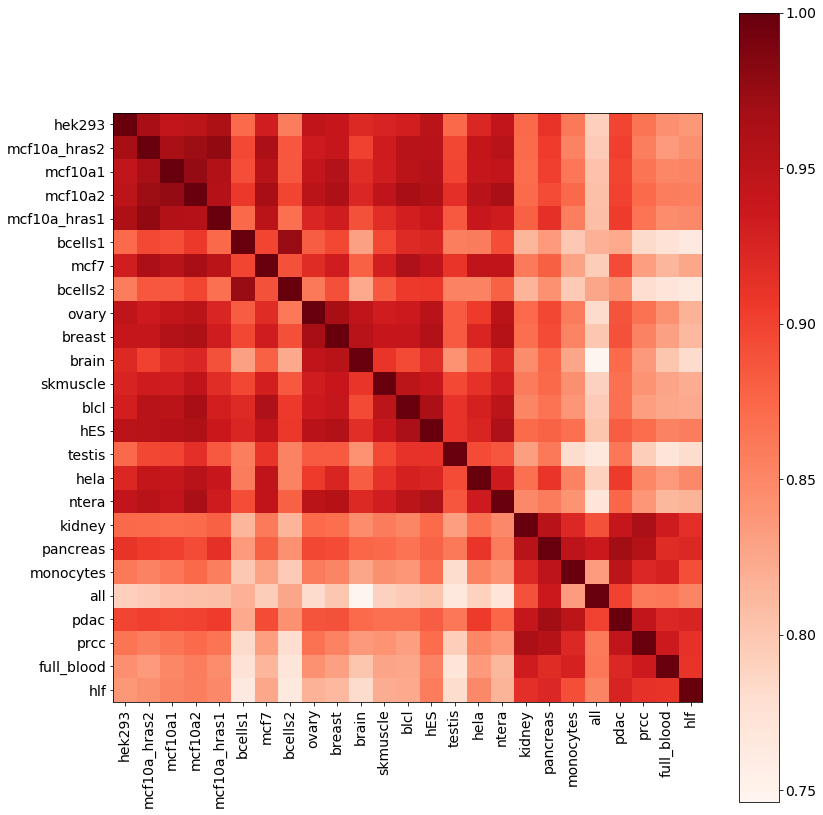

In [9]:
#Differential total site usage analysis

combined_tissue_index = np.concatenate([leslie_tissue_index, apadb_tissue_index])
combined_source_index = np.concatenate([
    np.array(['leslie'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array(['apadb'] * apadb_tissue_index.shape[0], dtype=np.object)
])
combined_suffix_index = np.concatenate([
    np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array([''] * apadb_tissue_index.shape[0], dtype=np.object)
])

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1#0.0
min_total_count = 20#20#100
only_differentials = False#True
use_logodds = False#True

r2_map = np.zeros((len(combined_tissue_index), len(combined_tissue_index)))
r2_map[np.arange(len(combined_tissue_index)), np.arange(len(combined_tissue_index))] = 1

for tissue_i in range(0, len(combined_tissue_index)) :
    tissue_1 = combined_tissue_index[tissue_i]
    source_data_1 = combined_source_index[tissue_i]
    special_mode_1 = combined_suffix_index[tissue_i]
    
    print('Tissue 1 = ' + str(tissue_1))
    
    for tissue_j in range(tissue_i + 1, len(combined_tissue_index)) :
        tissue_2 = combined_tissue_index[tissue_j]
        source_data_2 = combined_source_index[tissue_j]
        special_mode_2 = combined_suffix_index[tissue_j]
        
        count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1
        count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2
        total_count_col_1 = source_data_1 + '_total_count' + special_mode_1 + '_' + tissue_1
        total_count_col_2 = source_data_2 + '_total_count' + special_mode_2 + '_' + tissue_2
        df_to_use = df.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
        df_to_use = df_to_use.loc[df_to_use.site_type.isin(site_types)]
        if site_nums is not None :
            df_to_use = df_to_use.loc[df_to_use.sitenum.isin(site_nums)]

        if only_differentials :
            df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
            df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

        true_metric_tissue_1 = (df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count)
        true_metric_tissue_2 = (df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count)

        if use_logodds :
            true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
            true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))
        
        pearson_r, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)
        pearson_r2 = round(pearson_r * pearson_r, 4)
        
        r2_map[tissue_i, tissue_j] = pearson_r2
        r2_map[tissue_j, tissue_i] = pearson_r2
        


f = plt.figure(figsize=(12, 12))

plt.imshow(r2_map, cmap='Reds')

plt.xticks(np.arange(len(combined_tissue_index)), combined_tissue_index, fontsize=14, rotation=90)
plt.yticks(np.arange(len(combined_tissue_index)), combined_tissue_index, fontsize=14, rotation=0)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

fig_name = 'total_usage_heatmap_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
plt.savefig(fig_name + '.png', transparent=True, dpi=150)
plt.savefig(fig_name + '.eps')
plt.savefig(fig_name + '.svg')

plt.show()

Source = leslie
Tissue 1 = hek293
Tissue 1 = mcf10a_hras2
Tissue 1 = mcf10a1
Tissue 1 = mcf10a2
Tissue 1 = mcf10a_hras1
Tissue 1 = bcells1
Tissue 1 = mcf7
Tissue 1 = bcells2
Tissue 1 = ovary
Tissue 1 = breast
Tissue 1 = brain
Tissue 1 = skmuscle
Tissue 1 = blcl
Tissue 1 = hES
Tissue 1 = testis
Tissue 1 = hela
Tissue 1 = ntera


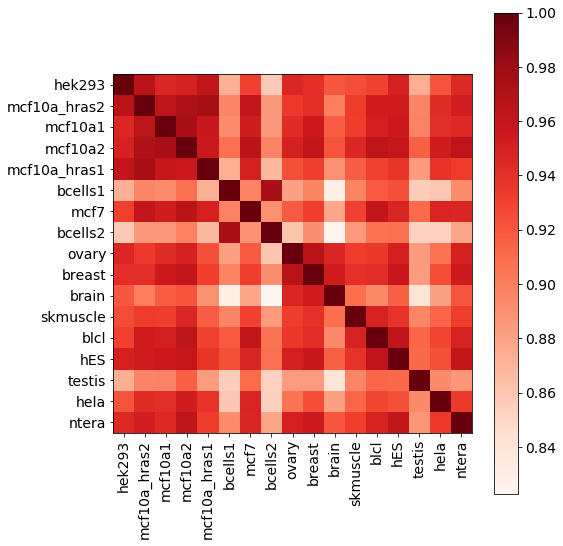

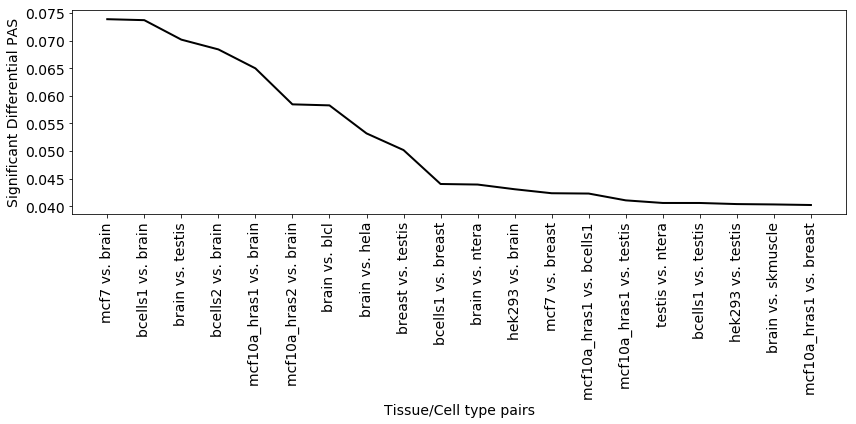

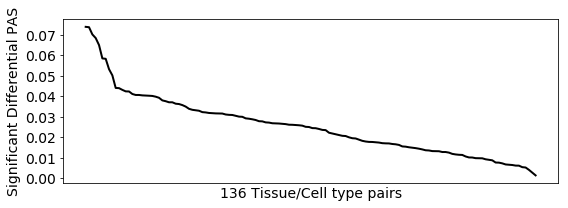

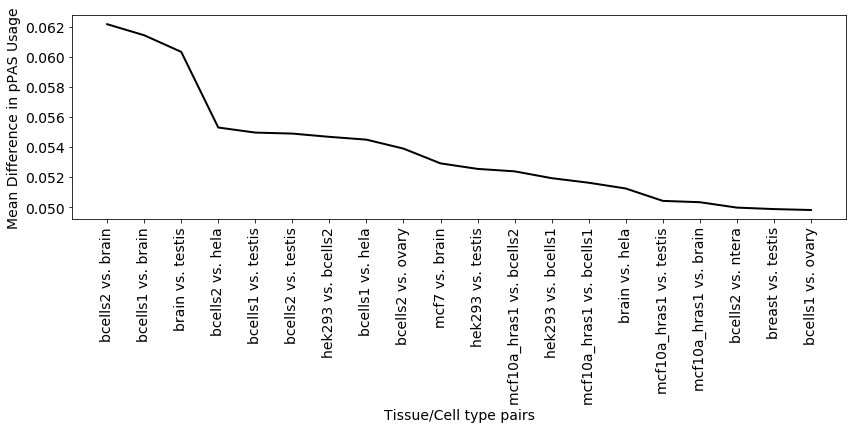

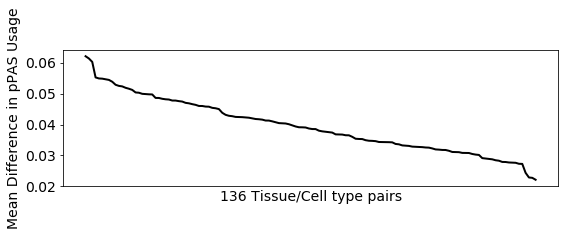

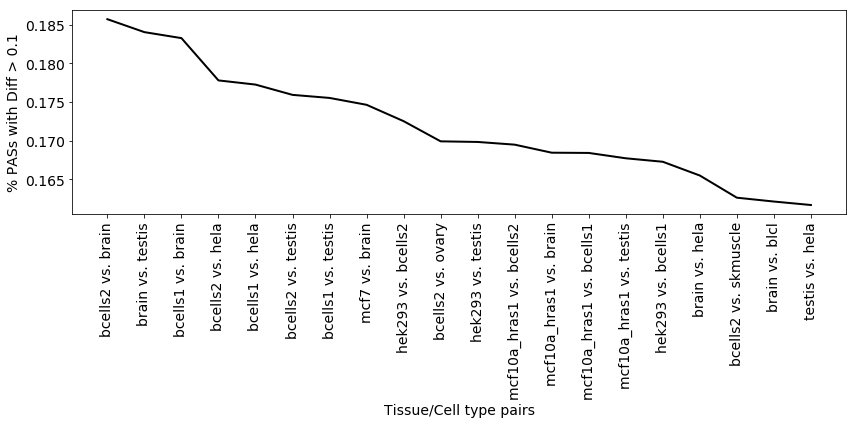

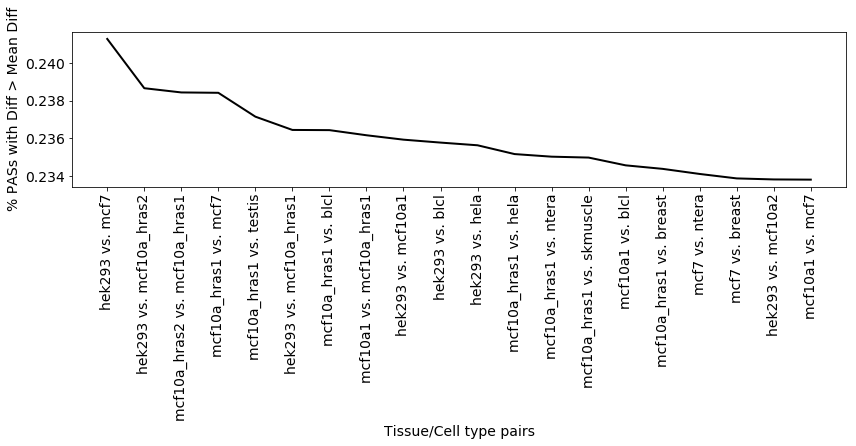

Min R^2 = 0.8226
Mean R^2 = 0.9269
Mean % Significant Differential = 0.0254
Mean Isoform Proportion Difference = 0.0394
(Significant) Mean Isoform Proportion Difference = 0.3178
Mean % PASs with Diff > 0.1 = 0.1337
Mean % PASs with Diff > Mean = 0.2277

Source = apadb
Tissue 1 = kidney
Tissue 1 = pancreas
Tissue 1 = monocytes
Tissue 1 = all
Tissue 1 = pdac
Tissue 1 = prcc
Tissue 1 = full_blood
Tissue 1 = hlf


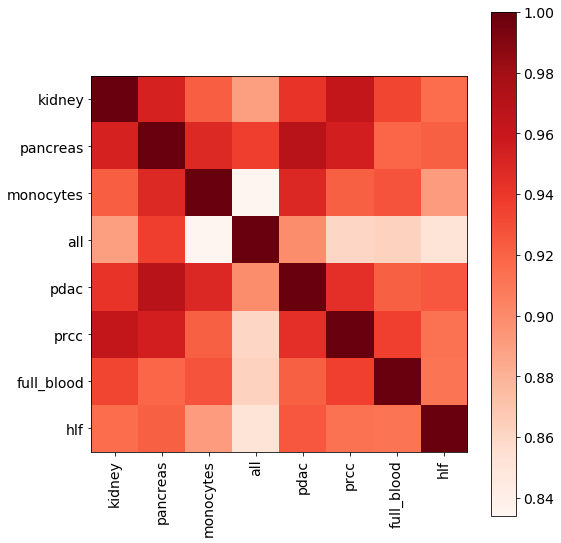

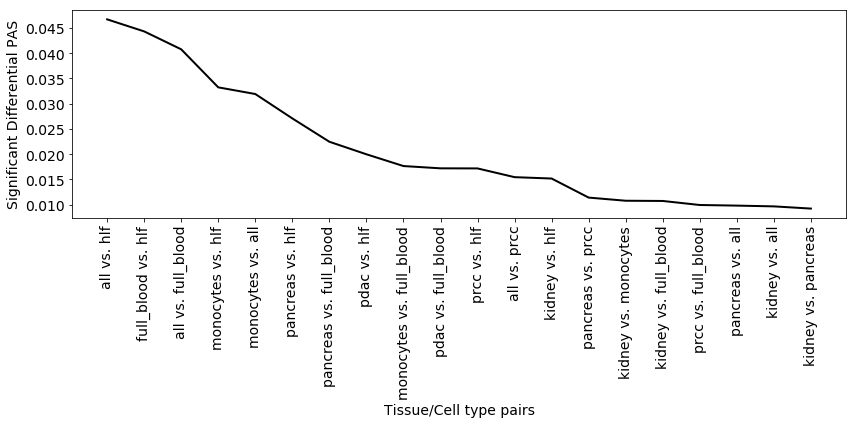

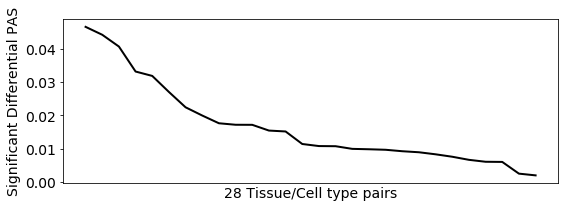

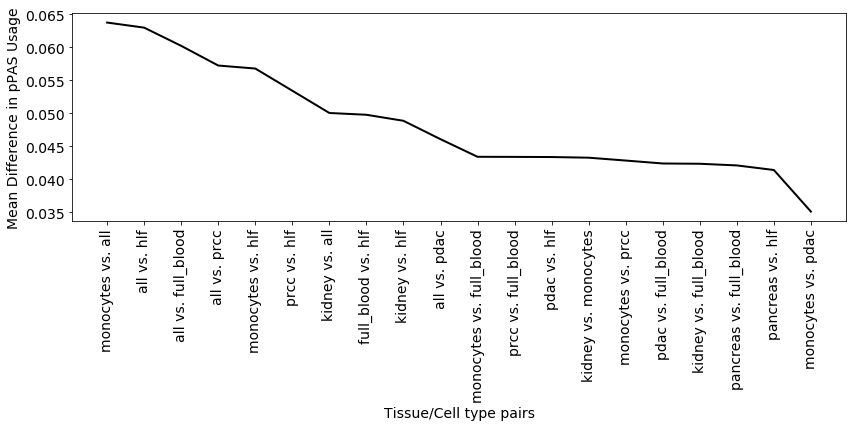

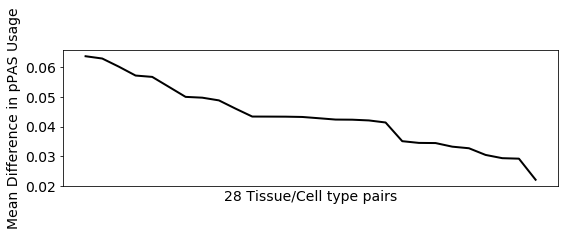

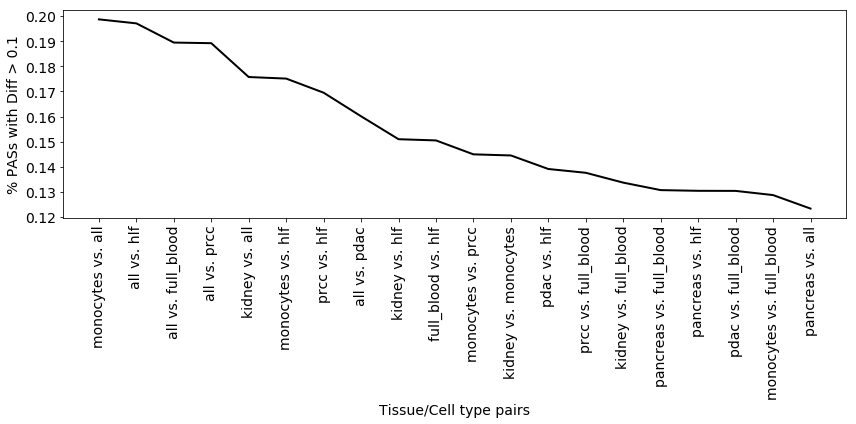

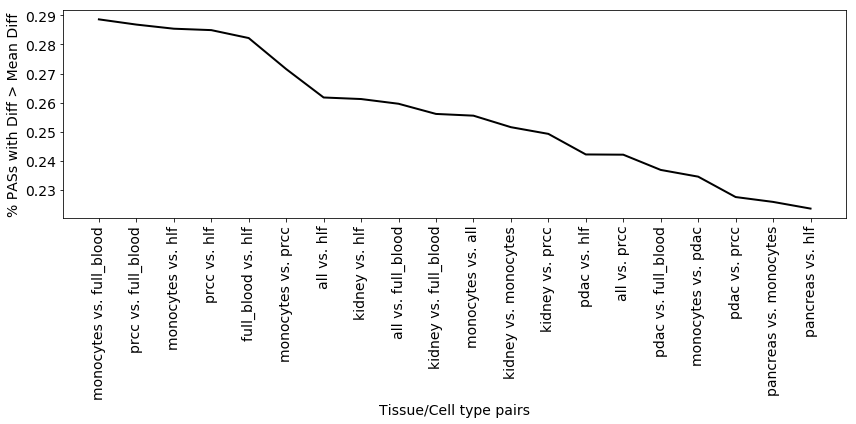

Min R^2 = 0.8341
Mean R^2 = 0.9284
Mean % Significant Differential = 0.0167
Mean Isoform Proportion Difference = 0.0434
(Significant) Mean Isoform Proportion Difference = 0.4818
Mean % PASs with Diff > 0.1 = 0.1404
Mean % PASs with Diff > Mean = 0.2411



In [11]:
#Differential total site usage analysis

combined_tissue_index = np.concatenate([leslie_tissue_index, apadb_tissue_index])
combined_source_index = np.concatenate([
    np.array(['leslie'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array(['apadb'] * apadb_tissue_index.shape[0], dtype=np.object)
])
combined_suffix_index = np.concatenate([
    np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array([''] * apadb_tissue_index.shape[0], dtype=np.object)
])

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1#0.0
min_total_count = 20#100
only_differentials = False#True
use_logodds = False#True

#alpha_confidence = 1. / 30000.
alpha_confidence = 10**(-10)#0.00001#10**(-10)#0.01
fixed_isoform_difference = 0.1

for [source_data, tissue_index, suffix_index] in [('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object)), ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))] :

    print('Source = ' + str(source_data))
    
    r2_map = np.zeros((len(tissue_index), len(tissue_index)))
    r2_map[np.arange(len(tissue_index)), np.arange(len(tissue_index))] = 1
    
    rel_differential_map = np.zeros((len(tissue_index), len(tissue_index)))
    mae_map = np.zeros((len(tissue_index), len(tissue_index)))
    mae_signi_map = np.zeros((len(tissue_index), len(tissue_index)))
    
    rel_isoform_diff_map = np.zeros((len(tissue_index), len(tissue_index)))
    fixed_isoform_diff_map = np.zeros((len(tissue_index), len(tissue_index)))

    for tissue_i in range(0, len(tissue_index)) :
        tissue_1 = tissue_index[tissue_i]
        source_data_1 = source_data
        special_mode_1 = suffix_index[tissue_i]

        print('Tissue 1 = ' + str(tissue_1))

        for tissue_j in range(tissue_i + 1, len(tissue_index)) :
            tissue_2 = tissue_index[tissue_j]
            source_data_2 = source_data
            special_mode_2 = suffix_index[tissue_j]

            count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1
            count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2
            total_count_col_1 = source_data_1 + '_total_count' + special_mode_1 + '_' + tissue_1
            total_count_col_2 = source_data_2 + '_total_count' + special_mode_2 + '_' + tissue_2
            df_to_use = df.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
            df_to_use = df_to_use.loc[df_to_use.site_type.isin(site_types)]
            if site_nums is not None :
                df_to_use = df_to_use.loc[df_to_use.sitenum.isin(site_nums)]

            if only_differentials :
                df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
                df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

            true_metric_tissue_1 = (df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count)
            true_metric_tissue_2 = (df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count)

            if use_logodds :
                true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
                true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))

            pearson_r, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)
            pearson_r2 = round(pearson_r * pearson_r, 4)

            r2_map[tissue_i, tissue_j] = pearson_r2
            r2_map[tissue_j, tissue_i] = pearson_r2
            
            p, log_p = differential_prop_test(np.ravel(df_to_use[count_col_1]) + pseudo_count, np.ravel(df_to_use[total_count_col_1]) + 2. * pseudo_count, np.ravel(df_to_use[count_col_2]) + pseudo_count, np.ravel(df_to_use[total_count_col_2]) + 2. * pseudo_count)
            
            rel_differential_map[tissue_i, tissue_j] = float(len(np.nonzero(p < alpha_confidence)[0])) / float(len(p))
            #rel_differential_map[tissue_j, tissue_i] = float(len(np.nonzero(p < alpha_confidence)[0])) / float(len(p))

            mae = np.mean(np.abs(true_metric_tissue_1 - true_metric_tissue_2))
            mae_signi = np.mean(np.abs(true_metric_tissue_1[p < alpha_confidence] - true_metric_tissue_2[p < alpha_confidence]))
            
            mae_map[tissue_i, tissue_j] = mae
            #mae_map[tissue_j, tissue_i] = mae
            
            mae_signi_map[tissue_i, tissue_j] = mae_signi
            #mae_signi_map[tissue_j, tissue_i] = mae_signi
            
            isoform_diff_abs = np.abs(true_metric_tissue_1 - true_metric_tissue_2)
            
            fixed_isoform_diff_map[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > fixed_isoform_difference)[0])) / float(len(isoform_diff_abs))
            rel_isoform_diff_map[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > mae)[0])) / float(len(isoform_diff_abs))


    f = plt.figure(figsize=(8, 8))

    #plt.imshow(r2_map, cmap='Reds', vmin=0.0, vmax=1.0)
    #plt.imshow(r2_map, cmap='Reds', vmin=np.min(r2_map) - 0.1, vmax=1.0)
    plt.imshow(r2_map, cmap='Reds')

    plt.xticks(np.arange(len(tissue_index)), tissue_index, fontsize=14, rotation=90)
    plt.yticks(np.arange(len(tissue_index)), tissue_index, fontsize=14, rotation=0)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()

    fig_name = 'total_usage_heatmap_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')

    plt.show()
    
    
    
    tissue_pair_list = []
    rel_differential_list = []
    mae_list = []
    mae_signi_list = []
    fixed_diff_list = []
    rel_diff_list = []
    for i in range(0, len(tissue_index)) :
        for j in range(i + 1, len(tissue_index)) :
            tissue_pair_list.append(tissue_index[i] + ' vs. ' + tissue_index[j])
            
            rel_differential_list.append(rel_differential_map[i, j])
            mae_list.append(mae_map[i, j])
            mae_signi_list.append(mae_signi_map[i, j])
            
            fixed_diff_list.append(fixed_isoform_diff_map[i, j])
            rel_diff_list.append(rel_isoform_diff_map[i, j])
    
    tissue_pairs = np.array(tissue_pair_list, dtype=np.object)
    rel_differentials = np.array(rel_differential_list)
    maes = np.array(mae_list)
    mae_signis = np.array(mae_signi_list)
    fixed_diffs = np.array(fixed_diff_list)
    rel_diffs = np.array(rel_diff_list)
    
    sort_index = np.argsort(rel_differentials)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs = fixed_diffs[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    top_n = 20
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), rel_differentials[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Significant Differential PAS", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'total_usage_top_differentials_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    f = plt.figure(figsize=(8, 3))
    
    plt.plot(np.arange(len(tissue_pairs)), rel_differentials, color='black', linewidth=2)
    
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    
    plt.xlabel(str(len(tissue_pairs)) + " Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Significant Differential PAS", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'total_usage_all_differentials_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    sort_index = np.argsort(maes)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs = fixed_diffs[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), maes[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Mean Difference in pPAS Usage", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'total_usage_top_maes_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    f = plt.figure(figsize=(8, 3))
    
    plt.plot(np.arange(len(tissue_pairs)), maes, color='black', linewidth=2)
    
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    
    plt.xlabel(str(len(tissue_pairs)) + " Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Mean Difference in pPAS Usage", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'total_usage_all_maes_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    sort_index = np.argsort(fixed_diffs)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs = fixed_diffs[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), fixed_diffs[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("% PASs with Diff > " + str(fixed_isoform_difference), fontsize=14)
    
    plt.tight_layout()

    fig_name = 'total_usage_top_fixed_diff_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    sort_index = np.argsort(rel_diffs)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs = fixed_diffs[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), rel_diffs[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("% PASs with Diff > Mean Diff", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'total_usage_top_rel_diff_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    print("Min R^2 = " + str(round(np.min(r2_map), 4)))
    print("Mean R^2 = " + str(round(np.mean(r2_map), 4)))
    
    print("Mean % Significant Differential = " + str(round(np.mean(rel_differentials), 4)))
    print("Mean Isoform Proportion Difference = " + str(round(np.mean(maes), 4)))
    print("(Significant) Mean Isoform Proportion Difference = " + str(round(np.mean(mae_signis), 4)))
    
    print("Mean % PASs with Diff > " + str(fixed_isoform_difference) + " = " + str(round(np.mean(fixed_diffs), 4)))
    print("Mean % PASs with Diff > Mean = " + str(round(np.mean(rel_diffs), 4)))
    print("")
    
    
    

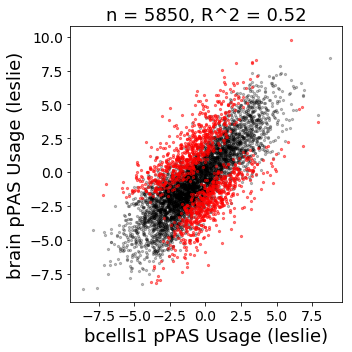

In [105]:
#Differential total site usage analysis, individual scatters

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3']
pseudo_count = 0.0#0.1#1.0#0.0
min_total_count = 20#100
only_differentials = True
use_logodds = True
color_by_sitenum = False

color_significant_sites = True
alpha_confidence = 10**(-10)#0.00001#10**(-10)#0.01

source_data_1 = 'leslie'
tissue_1 = 'bcells1'#'hek293'#'bcells1'
special_mode_1 = '_apadb_region'

source_data_2 = 'leslie'
tissue_2 = 'brain'#'mcf10a_hras1'#'brain'
special_mode_2 = '_apadb_region' #_apadb_region

count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1
count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2
total_count_col_1 = source_data_1 + '_total_count' + special_mode_1 + '_' + tissue_1
total_count_col_2 = source_data_2 + '_total_count' + special_mode_2 + '_' + tissue_2
df_to_use = df.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
df_to_use = df_to_use.loc[df_to_use.site_type.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum.isin(site_nums)]

if only_differentials :
    df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
    df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

true_metric_tissue_1 = (df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count)
true_metric_tissue_2 = (df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count)

if use_logodds :
    true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
    true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))

r_val, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)

f = plt.figure(figsize=(5, 5))

if not (color_by_sitenum or color_significant_sites) :
    plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=0.25, s=5, c='black')
elif color_significant_sites :
    p, log_p = differential_prop_test(np.ravel(df_to_use[count_col_1]) + pseudo_count, np.ravel(df_to_use[total_count_col_1]) + 2. * pseudo_count, np.ravel(df_to_use[count_col_2]) + pseudo_count, np.ravel(df_to_use[total_count_col_2]) + 2. * pseudo_count)
    
    plt.scatter(true_metric_tissue_1[p >= alpha_confidence], true_metric_tissue_2[p >= alpha_confidence], alpha=0.25, s=5, c='black')
    plt.scatter(true_metric_tissue_1[p < alpha_confidence], true_metric_tissue_2[p < alpha_confidence], alpha=0.5, s=5, c='red')
elif color_by_sitenum :
    sitenums = np.ravel(df_to_use['sitenum'].values)
    for sitenum in np.unique(sitenums) :
        if np.any(sitenums == sitenum) :
            plt.scatter(true_metric_tissue_1[sitenums == sitenum], true_metric_tissue_2[sitenums == sitenum], label='Site ' + str(sitenum), alpha=0.25, s=5)

    plt.legend(fontsize=14, frameon=True, framealpha=0.5, loc='lower right')

plt.xlabel(tissue_1.replace('_', ' ') + ' pPAS Usage (' + source_data_1 + ')', fontsize=18)
plt.ylabel(tissue_2.replace('_', ' ') + ' pPAS Usage (' + source_data_2 + ')', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if not use_logodds :
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plt.title('n = ' + str(len(df_to_use)) + ', R^2 = ' + str(round(r_val * r_val, 2)), fontsize=18)

plt.tight_layout()

fig_name = 'total_usage_scatter_' + str(source_data_1) + '_' + str(tissue_1) + '_' + str(source_data_2) + '_' + str(tissue_2) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
plt.savefig(fig_name + '.png', transparent=True, dpi=150)
plt.savefig(fig_name + '.eps')
plt.savefig(fig_name + '.svg')

plt.show()

plt.show()



In [90]:

#alpha_confidence = 0.1 / len(p)
alpha_confidence = 10**(-10)#0.00001#10**(-10)#0.01

print('alpha_confidence = ' + str(alpha_confidence))

p, log_p = differential_prop_test(np.ravel(df_to_use[count_col_1]) + pseudo_count, np.ravel(df_to_use[total_count_col_1]) + 2. * pseudo_count, np.ravel(df_to_use[count_col_2]) + pseudo_count, np.ravel(df_to_use[total_count_col_2]) + 2. * pseudo_count)

print('n_sites = ' + str(len(p)))
print('n_differential_sites = ' + str(len(np.nonzero(p < alpha_confidence)[0])))

print('% differential = ' + str(round(len(np.nonzero(p < alpha_confidence)[0]) / len(p), 5)))

mae = np.mean(np.abs(true_metric_tissue_1 - true_metric_tissue_2))
mae_signi = np.mean(np.abs(true_metric_tissue_1[p < alpha_confidence] - true_metric_tissue_2[p < alpha_confidence]))

print("Mean Isoform Proportion Difference = " + str(round(mae, 5)))
print("(Significant) Mean Isoform Proportion Difference = " + str(round(mae_signi, 5)))

alpha_confidence = 1e-10
n_sites = 21541
n_differential_sites = 309
% differential = 0.01434
Mean Isoform Proportion Difference = 0.03144
(Significant) Mean Isoform Proportion Difference = 0.2223


min_read_count / event = 10


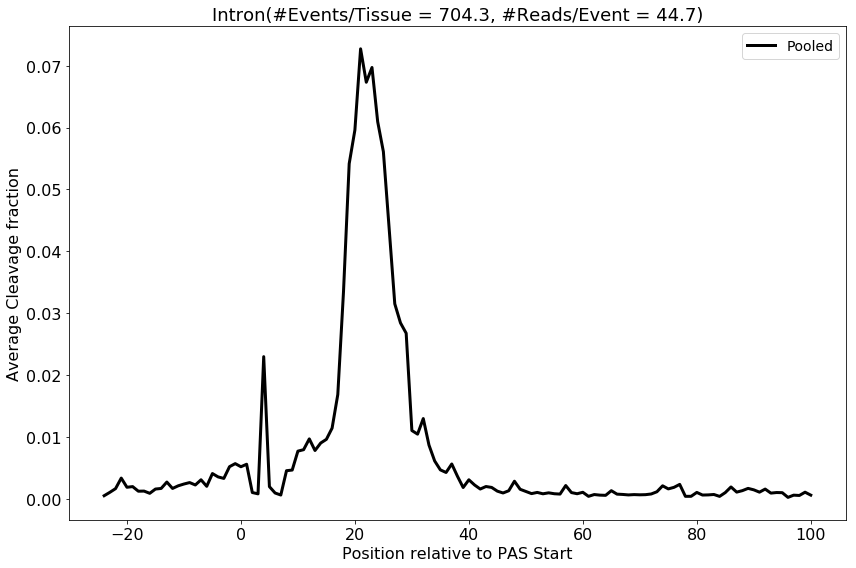

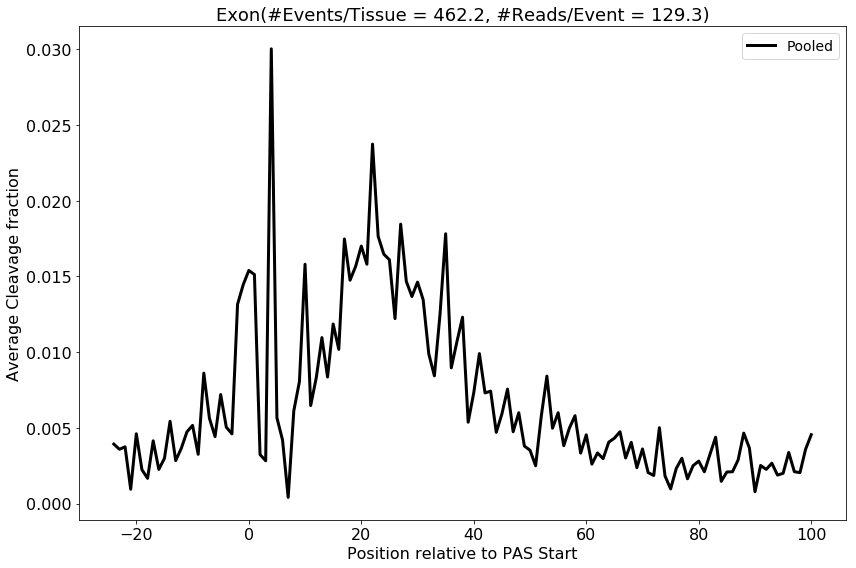

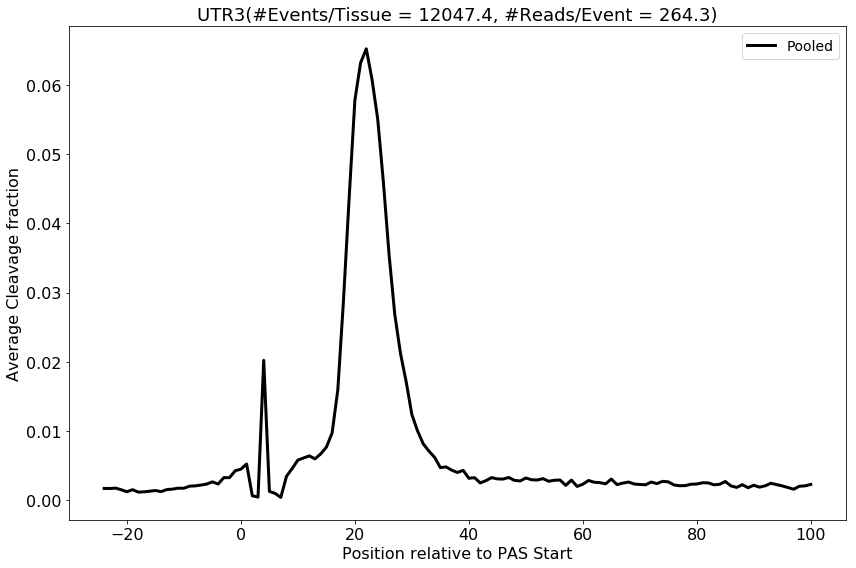

In [302]:

#Mean of normalized cleavage counts, per cell type

def plot_cut_distributions(df, tissue_index, cleavage_count_matrix_dict, cuts_predicted, site_types, plot_tissue_specific=True, plot_pooled=False, plot_predictions=False) :

    min_pos = 25
    max_pos = 150
    pas_offset = 49#50

    min_read_count = 10

    print('min_read_count / event = ' + str(min_read_count))

    for site_type_i, site_type in enumerate(site_types) :

        fig = plt.figure(figsize=(12, 8))
        ls = []

        n_events = np.zeros(len(tissue_index))
        n_reads = np.zeros(len(tissue_index))

        cum_cleavage_distribs = np.zeros((186, len(tissue_index)))
        cum_predicted_distribs = np.zeros((186, len(tissue_index)))
        
        for tissue_i in range(0, len(tissue_index)) :
            tissue = tissue_index[tissue_i]
            cleavage_counts = np.array(cleavage_count_matrix_dict[tissue].todense())
            cuts_pred = np.array(cuts_predicted.todense())[:, :-1]
            
            filter_index = np.nonzero((df['site_type'] == site_type) & (np.sum(cleavage_counts, axis=1) > min_read_count))[0]
            cleavage_counts = cleavage_counts[filter_index, :]
            cuts_pred = cuts_pred[filter_index, :]

            cleavage_distribs = cleavage_counts / np.sum(cleavage_counts, axis=1).reshape(-1, 1)
            pred_distribs = cuts_pred / np.sum(cuts_pred, axis=1).reshape(-1, 1)

            n_events[tissue_i] = cleavage_counts.shape[0]
            n_reads[tissue_i] = np.sum(cleavage_counts) / n_events[tissue_i]

            cleavage_distrib = np.mean(cleavage_distribs, axis=0)
            pred_distrib = np.mean(pred_distribs, axis=0)

            if plot_tissue_specific :
                l1, = plt.plot(np.arange(186)[min_pos:max_pos]-pas_offset, cleavage_distrib[min_pos:max_pos], label=tissue, alpha=0.75, linewidth=2)
                ls.append(l1)

                if plot_predictions :
                    l1, = plt.plot(np.arange(186)[min_pos:max_pos]-pas_offset, pred_distrib[min_pos:max_pos], label=tissue + ' (Pred)', alpha=0.75, linewidth=2, linestyle='--')
                    ls.append(l1)
            
            cum_cleavage_distribs[:, tissue_i] = cleavage_distrib
            cum_predicted_distribs[:, tissue_i] = pred_distrib
        
        
        
        cum_cleavage_distrib = np.mean(cum_cleavage_distribs, axis=1)
        cum_predicted_distrib = np.mean(cum_predicted_distribs, axis=1)
        
        if plot_pooled :
            l1, = plt.plot(np.arange(186)[min_pos:max_pos]-pas_offset, cum_cleavage_distrib[min_pos:max_pos], c='black', label='Pooled', linewidth=3)
            ls.append(l1)

            if plot_predictions :
                l1, = plt.plot(np.arange(186)[min_pos:max_pos]-pas_offset, cum_predicted_distrib[min_pos:max_pos], c='red', linestyle='--', label='Predicted', linewidth=3)
                ls.append(l1)

        avg_n_events = round(np.mean(n_events), 1)
        avg_n_reads = round(np.mean(n_reads), 1)

        plt.title(site_type + '(#Events/Tissue = ' + str(avg_n_events) + ', #Reads/Event = ' + str(avg_n_reads) + ')', fontsize=18)
        plt.xlabel('Position relative to PAS Start', fontsize=16)
        plt.ylabel('Average Cleavage fraction', fontsize=16)
        plt.tick_params(axis='both', which='minor', labelsize=16)
        plt.tick_params(axis='both', which='major', labelsize=16)

        plt.legend(handles=ls, fontsize=14)
        plt.tight_layout()
        plt.show()


tissue_index = leslie_tissue_index#np.array(['hek293'], dtype=np.object)
plot_cut_distributions(df, tissue_index, leslie_cleavage_count_matrix_dict, cuts_predicted, ['Intron', 'Exon', 'UTR3'], plot_tissue_specific=False, plot_pooled=True, plot_predictions=False)



In [303]:

def get_avgpos_pred_vs_true(df, tissue_index, site_types, cut_start=58, cut_end=105, count_filter=100, pooled=True) :

    pooled_cleavage_count_matrix = np.zeros((len(tissue_index), leslie_cleavage_count_matrix_dict['hek293'].shape[0], cut_end - cut_start))

    for tissue_i in range(0, len(tissue_index)) :
        tissue = tissue_index[tissue_i]
        cleavage_counts = np.array(leslie_cleavage_count_matrix_dict[tissue].todense())
        pooled_cleavage_count_matrix[tissue_i, :, :] = cleavage_counts[:, cut_start:cut_end]

    if pooled :
        pooled_cleavage_count_matrix = np.sum(pooled_cleavage_count_matrix, axis=0)
    else :
        pooled_cleavage_count_matrix = np.mean(pooled_cleavage_count_matrix, axis=0)
    
    total_cuts_true = np.ravel(np.sum(pooled_cleavage_count_matrix, axis=1))

    filter_index = np.nonzero((df['site_type'].isin(site_types)) & (total_cuts_true > count_filter))[0]
    pooled_cleavage_count_matrix = pooled_cleavage_count_matrix[filter_index, :]
    cuts_pred = np.array(cuts_predicted.todense())[filter_index, cut_start:cut_end]

    cuts_true = pooled_cleavage_count_matrix / np.sum(pooled_cleavage_count_matrix, axis=1).reshape(-1, 1)
    cuts_pred = cuts_pred / np.sum(cuts_pred, axis=1).reshape(-1, 1)

    avgpos_true = np.ravel(np.sum(cuts_true * np.arange(cuts_true.shape[1]).reshape(1, -1), axis=1))
    avgpos_pred = np.ravel(np.sum(cuts_pred * np.arange(cuts_pred.shape[1]).reshape(1, -1), axis=1))

    return avgpos_pred, avgpos_true

In [305]:
leslie_tissue_names = []
leslie_blacklist = {'mcf10a1' : True, 'mcf10a_hras1' : True, 'bcells1' : True}

for tissue in leslie_tissue_index :
    if tissue not in leslie_blacklist :
        leslie_tissue_names.append(tissue)

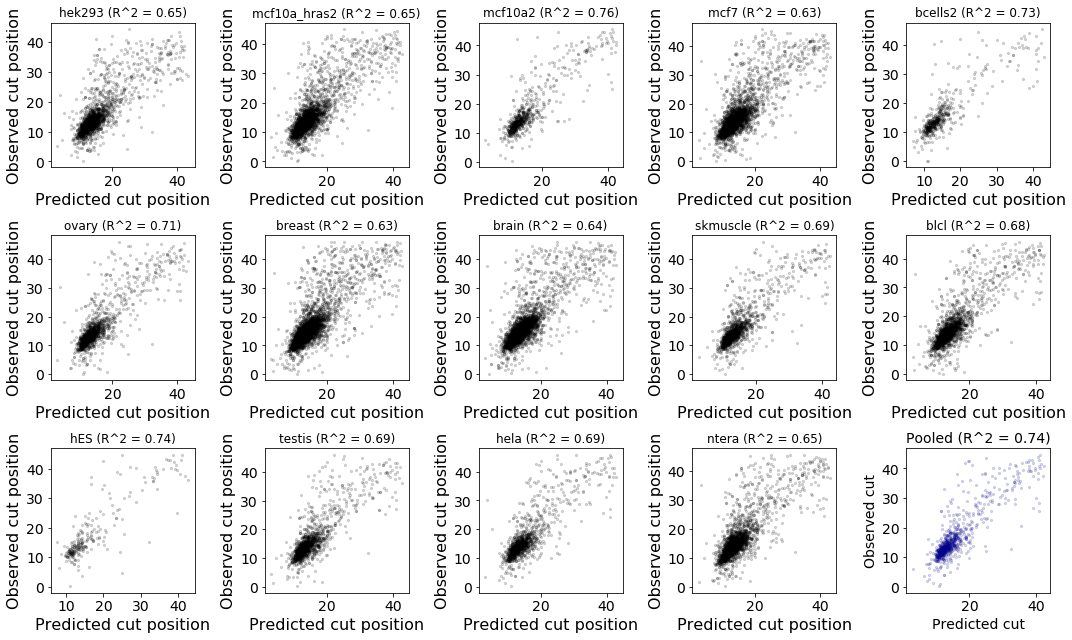

In [307]:
#Plot avgpos pred vs true per tissue type

n_rows = 3
n_cols = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

site_types = ['UTR3']
count_filter = 200
pooled=False

avgcut_r2_vec = np.zeros(len(leslie_tissue_names))

for row_i in range(0, n_rows) :
    for col_i in range(0, n_cols) :
        ax[row_i, col_i].axis('off')

for tissue_i in range(0, len(leslie_tissue_names)) :
    tissue = leslie_tissue_names[tissue_i]
    
    if tissue == 'pooled' :
        continue

    row_i = int(tissue_i / n_cols)
    col_i = int(tissue_i % n_cols)

    ax[row_i, col_i].axis('on')

    avgpos_pred, avgpos_true = get_avgpos_pred_vs_true(df, np.array([tissue], dtype=np.object), site_types, count_filter=count_filter, pooled=pooled)
    
    ax[row_i, col_i].scatter(avgpos_pred, avgpos_true, s=5, c='black', alpha=0.15)
    
    r_val, _ = pearsonr(avgpos_pred, avgpos_true)
    
    plt.sca(ax[row_i, col_i])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Predicted cut position', fontsize=16)
    plt.ylabel('Observed cut position', fontsize=16)
    
    plt.title(tissue + ' (R^2 = ' + str(round(r_val * r_val, 2)) + ')')
    
    avgcut_r2_vec[tissue_i] = round(r_val * r_val, 2)

col_i +=1
ax[row_i, col_i].axis('on')

pooled_filter = 500
avgpos_pred, avgpos_true = get_avgpos_pred_vs_true(df, leslie_tissue_index, site_types, count_filter=pooled_filter, pooled=pooled)

ax[row_i, col_i].scatter(avgpos_pred, avgpos_true, s=5, c='darkblue', alpha=0.15)

r_val, _ = pearsonr(avgpos_pred, avgpos_true)

plt.sca(ax[row_i, col_i])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Predicted cut', fontsize=14)
plt.ylabel('Observed cut', fontsize=14)

plt.title('Pooled (R^2 = ' + str(round(r_val * r_val, 2)) + ')', fontsize=14)



plt.tight_layout()
plt.show()



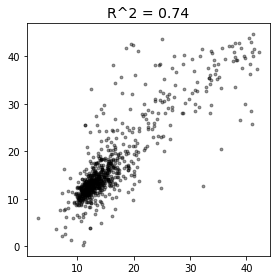

n = 797


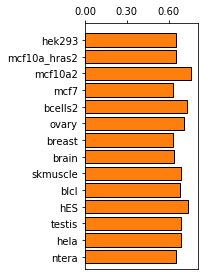

In [318]:
f = plt.figure(figsize=(4, 4))

pooled_filter = 500
avgpos_pred, avgpos_true = get_avgpos_pred_vs_true(df, leslie_tissue_index, site_types, count_filter=pooled_filter, pooled=pooled)

plt.scatter(avgpos_pred, avgpos_true, s=8, c='black', alpha=0.4)

r_val, _ = pearsonr(avgpos_pred, avgpos_true)

plt.title('R^2 = ' + str(round(r_val * r_val, 2)), fontsize=14)

plt.tight_layout()

plt.savefig('avgcut_leslie_pooled_scatter.png', dpi=150, transparent=True)
plt.savefig('avgcut_leslie_pooled_scatter.svg')

plt.show()

print('n = ' + str(avgpos_pred.shape[0]))


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#Plot avgcut r2

f = plt.figure(figsize=(3, 4))

plt.barh(np.arange(len(leslie_tissue_names)), avgcut_r2_vec[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

plt.yticks(np.arange(len(leslie_tissue_names)), leslie_tissue_names[::-1])

plt.xlim(0, np.max(avgcut_r2_vec) + 0.05)
plt.ylim(-0.75, len(leslie_tissue_names))

plt.xticks([0, 0.3, 0.6])

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('avgcut_leslie_r2_bar.png', dpi=150, transparent=True)
plt.savefig('avgcut_leslie_r2_bar.svg')

plt.show()

In [12]:
#Join adjacent sites into pair-wise APA df

df['gene_id_dist'] = df['gene_id'].apply(lambda x: '.'.join(x.split('.')[:-1]) + '.' + str(int(x.split('.')[-1]) - 1))

df_dist = df.copy().set_index('gene_id')

dist_columns = [
    'sitenum',
    'pas',
    'seq',
    'site_type',
    'pas_pos',
    'cut_start',
    'cut_end',
    'cut_mode',
    'mirna',
    'ratio',
    'predicted_usage',
    'predicted_logodds',
    'predicted_usage_apadb_region',
    'predicted_logodds_apadb_region',
    'predicted_score',
    'row_index'
]

for cell_type in leslie_tissue_index :
    dist_columns.append('leslie_count_' + cell_type)
    dist_columns.append('leslie_count_apadb_region_' + cell_type)
dist_columns.append('leslie_count_pooled')
dist_columns.append('leslie_count_apadb_region_pooled')

for tissue in apadb_tissue_index :
    dist_columns.append('apadb_count_' + tissue)
dist_columns.append('apadb_count_pooled')

df_dist = df_dist[dist_columns]

df_pair = df.join(df_dist, on='gene_id_dist', how='inner', lsuffix='_prox', rsuffix='_dist')


In [13]:
#Aggregate prox + dist total counts

for tissue in leslie_tissue_index :
    df_pair['leslie_pair_count_' + tissue] = df_pair['leslie_count_' + tissue + '_prox'] + df_pair['leslie_count_' + tissue + '_dist']
    df_pair['leslie_pair_count_apadb_region_' + tissue] = df_pair['leslie_count_apadb_region_' + tissue + '_prox'] + df_pair['leslie_count_apadb_region_' + tissue + '_dist']

df_pair['leslie_pair_count_pooled'] = df_pair['leslie_count_pooled_prox'] + df_pair['leslie_count_pooled_dist']
df_pair['leslie_pair_count_apadb_region_pooled'] = df_pair['leslie_count_apadb_region_pooled_prox'] + df_pair['leslie_count_apadb_region_pooled_dist']

for tissue in apadb_tissue_index :
    df_pair['apadb_pair_count_' + tissue] = df_pair['apadb_count_' + tissue + '_prox'] + df_pair['apadb_count_' + tissue + '_dist']
df_pair['apadb_pair_count_pooled'] = df_pair['apadb_count_pooled_prox'] + df_pair['apadb_count_pooled_dist']


In [14]:
#Compute site distance
df_pair['distance'] = np.abs(df_pair['cut_start_dist'] - df_pair['cut_start_prox'])

#Filter pair dataframe
filter_query = "(apadb_count_pooled_prox + apadb_count_pooled_dist >= 10) and " #1000
filter_query += "pas_prox != -1 and pas_dist != -1"
#filter_query += " and (site_type_prox == 'UTR3' or site_type_prox == 'Extension') and (site_type_dist == 'UTR3' or site_type_dist == 'Extension')"
#filter_query += " and (cut_end_prox - cut_start_prox <= 30) and (cut_end_dist - cut_start_dist <= 30)"
filter_query += " and (cut_end_prox - cut_start_prox <= 60) and (cut_end_dist - cut_start_dist <= 60)"
#filter_query += " and (mirna_prox == 'None') and (mirna_dist == 'None')"
#filter_query += " and (mirna_prox == mirna_dist)"
#filter_query += " and (distance >= 100 and distance <= 800)"
filter_query += " and (distance >= 40 and distance <= 4000)"

df_pair_filtered = df_pair.query(filter_query).copy().reset_index(drop=True)
print(len(df_pair_filtered))

df_pair_filtered['row_index'] = np.arange(len(df_pair_filtered), dtype=np.int)


31720


In [15]:
#Join cleavage measures and deep features onto filtered pair dataframe

keep_index_prox = []
keep_index_dist = []

for _, row in df_pair_filtered.iterrows() :
    keep_index_prox.append(row['row_index_prox'])
    keep_index_dist.append(row['row_index_dist'])

leslie_cleavage_dict_prox = {}
leslie_cleavage_dict_dist = {}
for cell_type in leslie_tissue_index :
    leslie_cleavage_dict_prox[cell_type] = np.array(leslie_cleavage_count_matrix_dict[cell_type][keep_index_prox, :].todense())
    leslie_cleavage_dict_dist[cell_type] = np.array(leslie_cleavage_count_matrix_dict[cell_type][keep_index_dist, :].todense())

cuts_predicted_prox = cuts_predicted[keep_index_prox, :]
cuts_predicted_dist = cuts_predicted[keep_index_dist, :]

deep_features_prox = deep_features[keep_index_prox, :]
deep_features_dist = deep_features[keep_index_dist, :]


Tissue 1 = hek293
Tissue 1 = mcf10a_hras2
Tissue 1 = mcf10a1
Tissue 1 = mcf10a2
Tissue 1 = mcf10a_hras1
Tissue 1 = bcells1
Tissue 1 = mcf7
Tissue 1 = bcells2
Tissue 1 = ovary
Tissue 1 = breast
Tissue 1 = brain
Tissue 1 = skmuscle
Tissue 1 = blcl
Tissue 1 = hES
Tissue 1 = testis
Tissue 1 = hela
Tissue 1 = ntera
Tissue 1 = kidney
Tissue 1 = pancreas
Tissue 1 = monocytes
Tissue 1 = all
Tissue 1 = pdac
Tissue 1 = prcc
Tissue 1 = full_blood
Tissue 1 = hlf


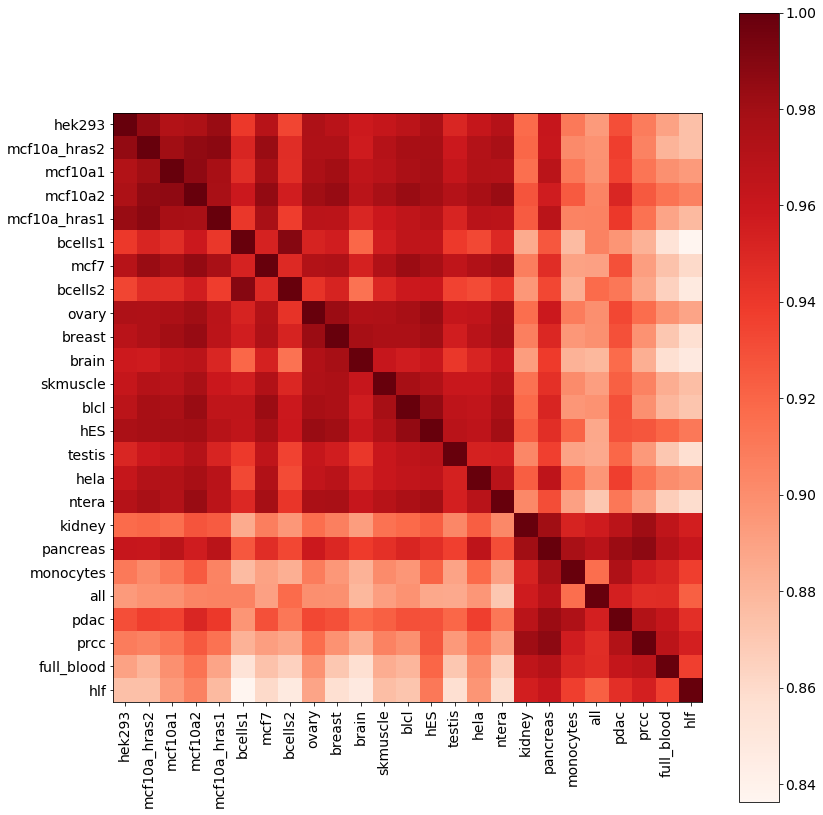

In [15]:
#Differential pairwise site usage analysis

combined_tissue_index = np.concatenate([leslie_tissue_index, apadb_tissue_index])
combined_source_index = np.concatenate([
    np.array(['leslie'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array(['apadb'] * apadb_tissue_index.shape[0], dtype=np.object)
])
combined_suffix_index = np.concatenate([
    np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array([''] * apadb_tissue_index.shape[0], dtype=np.object)
])

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1#1.0#0.0
min_total_count = 20#100
only_differentials = False#True
use_logodds = False#True

r2_map = np.zeros((len(combined_tissue_index), len(combined_tissue_index)))
r2_map[np.arange(len(combined_tissue_index)), np.arange(len(combined_tissue_index))] = 1

for tissue_i in range(0, len(combined_tissue_index)) :
    tissue_1 = combined_tissue_index[tissue_i]
    source_data_1 = combined_source_index[tissue_i]
    special_mode_1 = combined_suffix_index[tissue_i]
    
    print('Tissue 1 = ' + str(tissue_1))
    
    for tissue_j in range(tissue_i + 1, len(combined_tissue_index)) :
        tissue_2 = combined_tissue_index[tissue_j]
        source_data_2 = combined_source_index[tissue_j]
        special_mode_2 = combined_suffix_index[tissue_j]
        
        count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
        count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
        total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
        total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
        df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
        df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
        if site_nums is not None :
            df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

        if only_differentials :
            df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
            df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

        true_metric_tissue_1 = (df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count)
        true_metric_tissue_2 = (df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count)

        if use_logodds :
            true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
            true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))
        
        pearson_r, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)
        pearson_r2 = round(pearson_r * pearson_r, 4)
        
        r2_map[tissue_i, tissue_j] = pearson_r2
        r2_map[tissue_j, tissue_i] = pearson_r2
        

f = plt.figure(figsize=(12, 12))

plt.imshow(r2_map, cmap='Reds')

plt.xticks(np.arange(len(combined_tissue_index)), combined_tissue_index, fontsize=14, rotation=90)
plt.yticks(np.arange(len(combined_tissue_index)), combined_tissue_index, fontsize=14, rotation=0)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

fig_name = 'pairwise_usage_heatmap_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
plt.savefig(fig_name + '.png', transparent=True, dpi=150)
plt.savefig(fig_name + '.eps')
plt.savefig(fig_name + '.svg')

plt.show()

Source = leslie
Tissue 1 = hek293
Tissue 1 = mcf10a_hras2
Tissue 1 = mcf10a1
Tissue 1 = mcf10a2
Tissue 1 = mcf10a_hras1
Tissue 1 = bcells1
Tissue 1 = mcf7
Tissue 1 = bcells2
Tissue 1 = ovary
Tissue 1 = breast
Tissue 1 = brain
Tissue 1 = skmuscle
Tissue 1 = blcl
Tissue 1 = hES
Tissue 1 = testis
Tissue 1 = hela
Tissue 1 = ntera


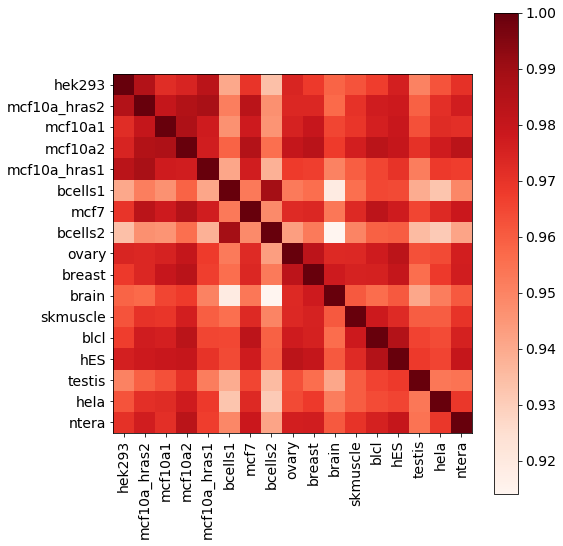

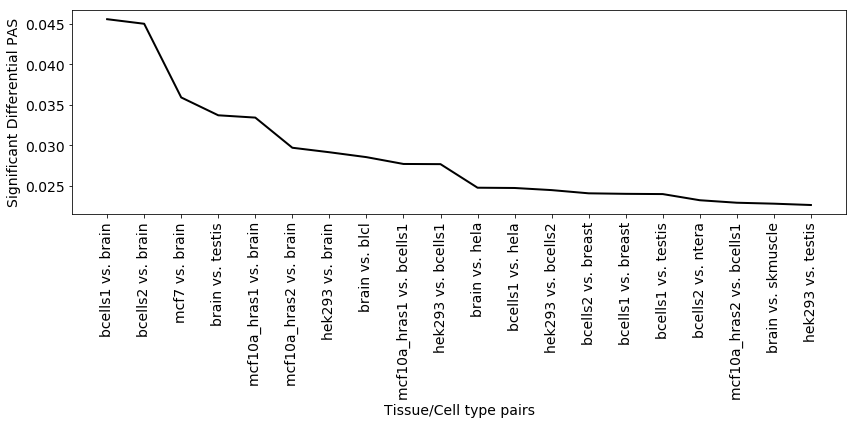

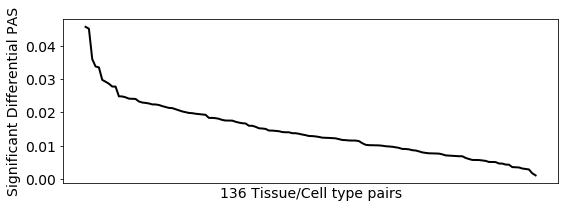

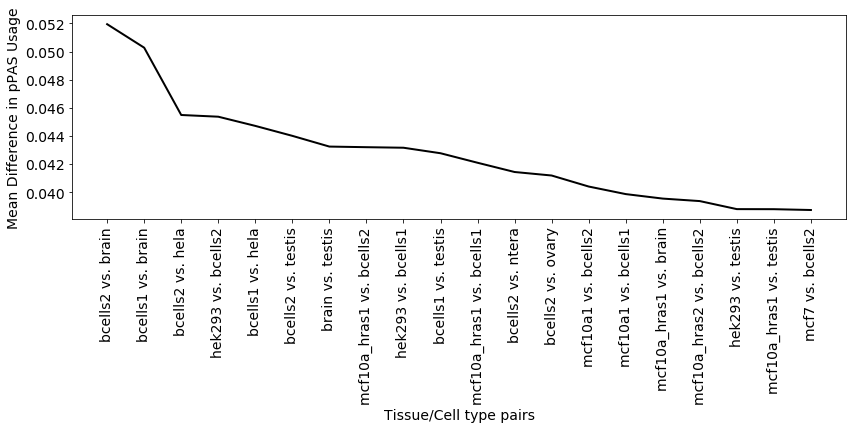

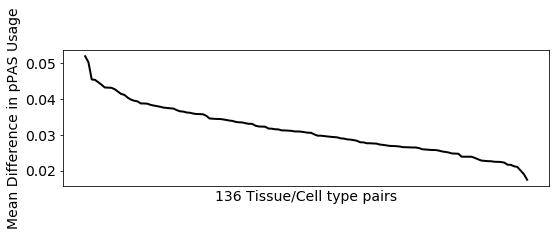

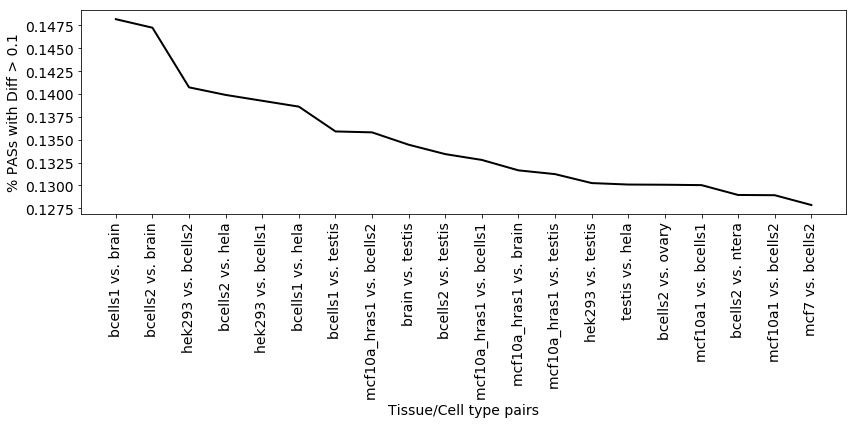

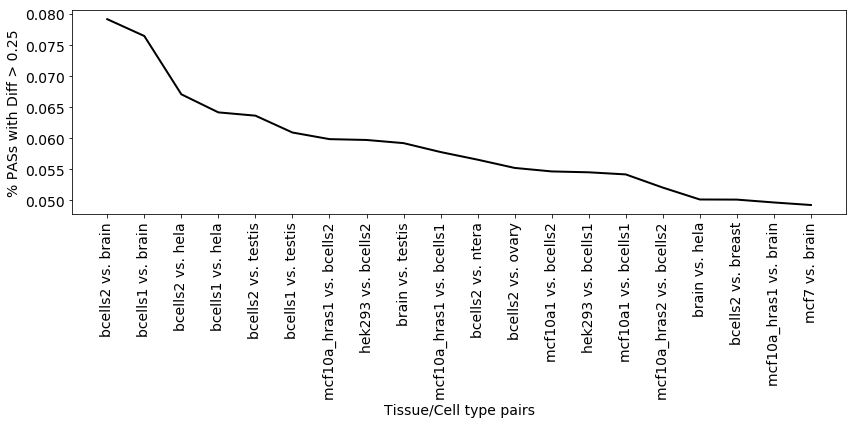

Min R^2 = 0.914
Mean R^2 = 0.9676
Mean % Significant Differential = 0.0144
Mean Isoform Proportion Difference = 0.0313
(Significant) Mean Isoform Proportion Difference = 0.3325
Mean % PASs with Diff > 0.1 = 0.1058
Mean % PASs with Diff > 0.25 = 0.0328

Source = apadb
Tissue 1 = kidney
Tissue 1 = pancreas
Tissue 1 = monocytes
Tissue 1 = all
Tissue 1 = pdac
Tissue 1 = prcc
Tissue 1 = full_blood
Tissue 1 = hlf


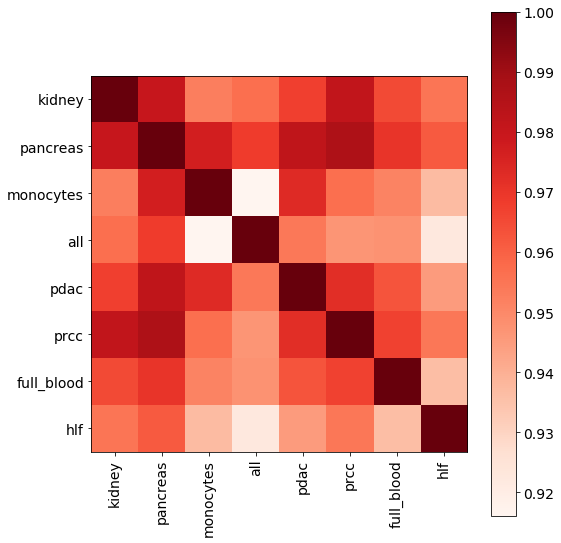

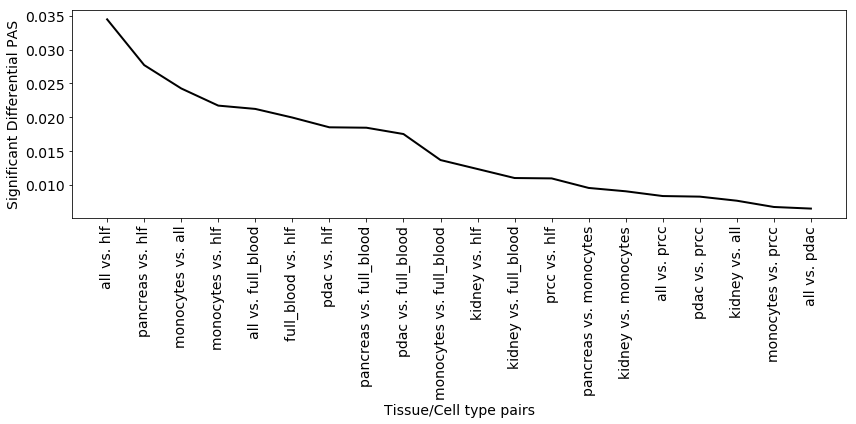

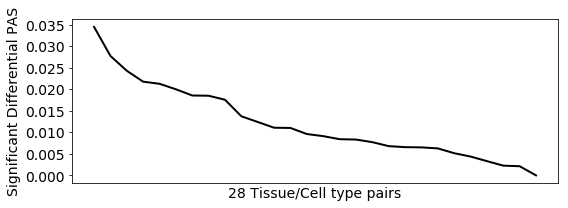

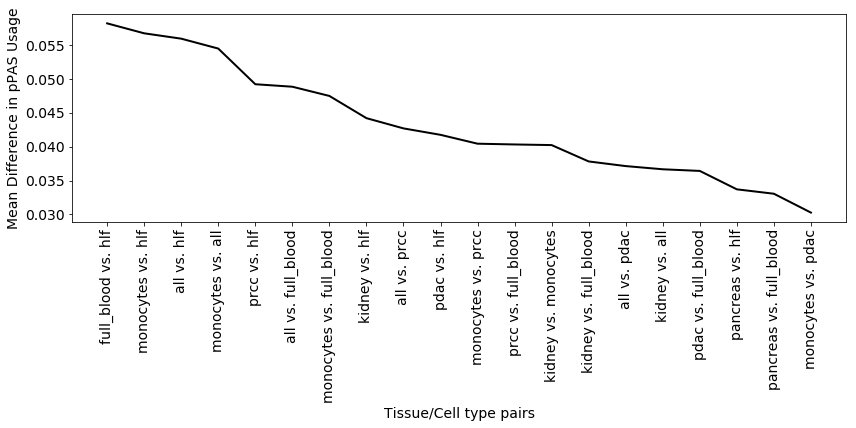

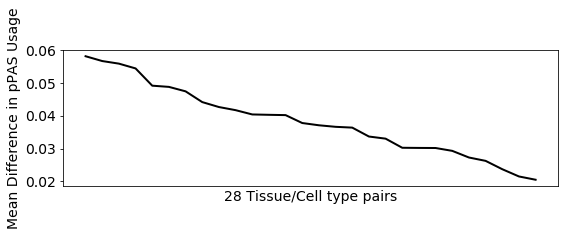

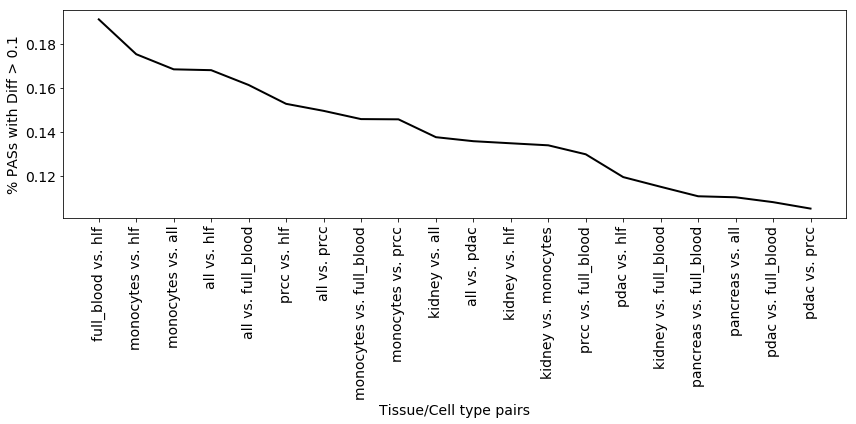

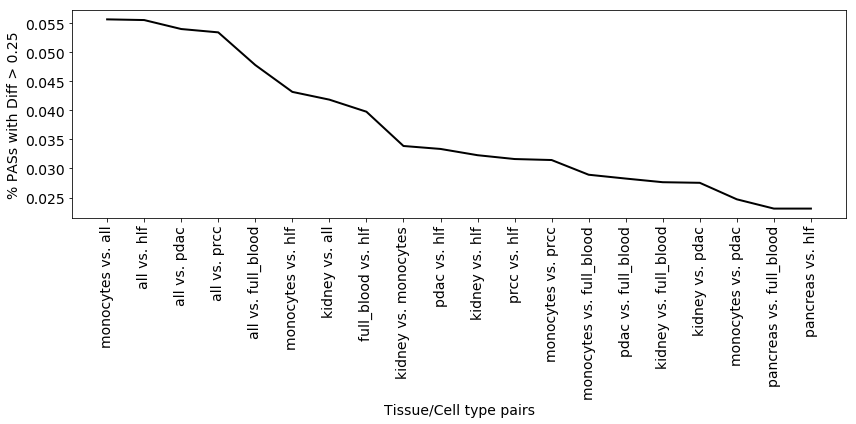

Min R^2 = 0.9161
Mean R^2 = 0.964
Mean % Significant Differential = 0.0121
Mean Isoform Proportion Difference = 0.0384
(Significant) Mean Isoform Proportion Difference = 0.3814
Mean % PASs with Diff > 0.1 = 0.1256
Mean % PASs with Diff > 0.25 = 0.0308



In [21]:
#Differential total site usage analysis

combined_tissue_index = np.concatenate([leslie_tissue_index, apadb_tissue_index])
combined_source_index = np.concatenate([
    np.array(['leslie'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array(['apadb'] * apadb_tissue_index.shape[0], dtype=np.object)
])
combined_suffix_index = np.concatenate([
    np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array([''] * apadb_tissue_index.shape[0], dtype=np.object)
])

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1#1.0#0.0
min_total_count = 20#100
only_differentials = False#True
use_logodds = False#True

#alpha_confidence = 1. / 30000.
alpha_confidence = 10**(-10)#0.00001#10**(-10)#0.01
fixed_isoform_difference_1 = 0.1
fixed_isoform_difference_2 = 0.25

for [source_data, tissue_index, suffix_index] in [('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object)), ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))] :

    print('Source = ' + str(source_data))
    
    r2_map = np.zeros((len(tissue_index), len(tissue_index)))
    r2_map[np.arange(len(tissue_index)), np.arange(len(tissue_index))] = 1
    
    rel_differential_map = np.zeros((len(tissue_index), len(tissue_index)))
    mae_map = np.zeros((len(tissue_index), len(tissue_index)))
    mae_signi_map = np.zeros((len(tissue_index), len(tissue_index)))
    
    rel_isoform_diff_map = np.zeros((len(tissue_index), len(tissue_index)))
    fixed_isoform_diff_map_1 = np.zeros((len(tissue_index), len(tissue_index)))
    fixed_isoform_diff_map_2 = np.zeros((len(tissue_index), len(tissue_index)))

    for tissue_i in range(0, len(tissue_index)) :
        tissue_1 = tissue_index[tissue_i]
        source_data_1 = source_data
        special_mode_1 = suffix_index[tissue_i]

        print('Tissue 1 = ' + str(tissue_1))

        for tissue_j in range(tissue_i + 1, len(tissue_index)) :
            tissue_2 = tissue_index[tissue_j]
            source_data_2 = source_data
            special_mode_2 = suffix_index[tissue_j]

            count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
            count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
            total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
            total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
            df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
            df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
            if site_nums is not None :
                df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

            if only_differentials :
                df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
                df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

            true_metric_tissue_1 = (df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count)
            true_metric_tissue_2 = (df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count)

            if use_logodds :
                true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
                true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))

            pearson_r, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)
            pearson_r2 = round(pearson_r * pearson_r, 4)

            r2_map[tissue_i, tissue_j] = pearson_r2
            r2_map[tissue_j, tissue_i] = pearson_r2
            
            p, log_p = differential_prop_test(np.ravel(df_to_use[count_col_1]) + pseudo_count, np.ravel(df_to_use[total_count_col_1]) + 2. * pseudo_count, np.ravel(df_to_use[count_col_2]) + pseudo_count, np.ravel(df_to_use[total_count_col_2]) + 2. * pseudo_count)
            
            rel_differential_map[tissue_i, tissue_j] = float(len(np.nonzero(p < alpha_confidence)[0])) / float(len(p))
            #rel_differential_map[tissue_j, tissue_i] = float(len(np.nonzero(p < alpha_confidence)[0])) / float(len(p))

            mae = np.mean(np.abs(true_metric_tissue_1 - true_metric_tissue_2))
            mae_signi = np.mean(np.abs(true_metric_tissue_1[p < alpha_confidence] - true_metric_tissue_2[p < alpha_confidence]))
            
            mae_map[tissue_i, tissue_j] = mae
            #mae_map[tissue_j, tissue_i] = mae
            
            mae_signi_map[tissue_i, tissue_j] = mae_signi
            #mae_signi_map[tissue_j, tissue_i] = mae_signi
            
            isoform_diff_abs = np.abs(true_metric_tissue_1 - true_metric_tissue_2)
            
            fixed_isoform_diff_map_1[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > fixed_isoform_difference_1)[0])) / float(len(isoform_diff_abs))
            fixed_isoform_diff_map_2[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > fixed_isoform_difference_2)[0])) / float(len(isoform_diff_abs))
            rel_isoform_diff_map[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > mae)[0])) / float(len(isoform_diff_abs))


    f = plt.figure(figsize=(8, 8))

    #plt.imshow(r2_map, cmap='Reds', vmin=0.0, vmax=1.0)
    #plt.imshow(r2_map, cmap='Reds', vmin=np.min(r2_map) - 0.1, vmax=1.0)
    plt.imshow(r2_map, cmap='Reds')

    plt.xticks(np.arange(len(tissue_index)), tissue_index, fontsize=14, rotation=90)
    plt.yticks(np.arange(len(tissue_index)), tissue_index, fontsize=14, rotation=0)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()

    fig_name = 'pair_usage_heatmap_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')

    plt.show()
    
    
    
    tissue_pair_list = []
    rel_differential_list = []
    mae_list = []
    mae_signi_list = []
    fixed_diff_list_1 = []
    fixed_diff_list_2 = []
    rel_diff_list = []
    for i in range(0, len(tissue_index)) :
        for j in range(i + 1, len(tissue_index)) :
            tissue_pair_list.append(tissue_index[i] + ' vs. ' + tissue_index[j])
            
            rel_differential_list.append(rel_differential_map[i, j])
            mae_list.append(mae_map[i, j])
            mae_signi_list.append(mae_signi_map[i, j])
            
            fixed_diff_list_1.append(fixed_isoform_diff_map_1[i, j])
            fixed_diff_list_2.append(fixed_isoform_diff_map_2[i, j])
            rel_diff_list.append(rel_isoform_diff_map[i, j])
    
    tissue_pairs = np.array(tissue_pair_list, dtype=np.object)
    rel_differentials = np.array(rel_differential_list)
    maes = np.array(mae_list)
    mae_signis = np.array(mae_signi_list)
    fixed_diffs_1 = np.array(fixed_diff_list_1)
    fixed_diffs_2 = np.array(fixed_diff_list_2)
    rel_diffs = np.array(rel_diff_list)
    
    sort_index = np.argsort(rel_differentials)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    mae_signis[np.isnan(mae_signis)] = 0.
    
    top_n = 20
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), rel_differentials[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Significant Differential PAS", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_differentials_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    f = plt.figure(figsize=(8, 3))
    
    plt.plot(np.arange(len(tissue_pairs)), rel_differentials, color='black', linewidth=2)
    
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    
    plt.xlabel(str(len(tissue_pairs)) + " Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Significant Differential PAS", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_all_differentials_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    sort_index = np.argsort(maes)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), maes[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Mean Difference in pPAS Usage", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_maes_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    f = plt.figure(figsize=(8, 3))
    
    plt.plot(np.arange(len(tissue_pairs)), maes, color='black', linewidth=2)
    
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    
    plt.xlabel(str(len(tissue_pairs)) + " Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Mean Difference in pPAS Usage", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_all_maes_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    sort_index = np.argsort(fixed_diffs_1)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), fixed_diffs_1[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("% PASs with Diff > " + str(fixed_isoform_difference_1), fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_fixed_diff_1_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    sort_index = np.argsort(fixed_diffs_2)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), fixed_diffs_2[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("% PASs with Diff > " + str(fixed_isoform_difference_2), fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_fixed_diff_2_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    print("Min R^2 = " + str(round(np.min(r2_map), 4)))
    print("Mean R^2 = " + str(round(np.mean(r2_map), 4)))
    
    print("Mean % Significant Differential = " + str(round(np.mean(rel_differentials), 4)))
    print("Mean Isoform Proportion Difference = " + str(round(np.mean(maes), 4)))
    print("(Significant) Mean Isoform Proportion Difference = " + str(round(np.mean(mae_signis), 4)))
    
    print("Mean % PASs with Diff > " + str(fixed_isoform_difference_1) + " = " + str(round(np.mean(fixed_diffs_1), 4)))
    print("Mean % PASs with Diff > " + str(fixed_isoform_difference_2) + " = " + str(round(np.mean(fixed_diffs_2), 4)))
    print("")
    
    
    

Source = leslie
Tissue 1 = hek293
Tissue 1 = mcf10a_hras2
Tissue 1 = mcf10a1
Tissue 1 = mcf10a2
Tissue 1 = mcf10a_hras1
Tissue 1 = bcells1
Tissue 1 = mcf7
Tissue 1 = bcells2
Tissue 1 = ovary
Tissue 1 = breast
Tissue 1 = brain
Tissue 1 = skmuscle
Tissue 1 = blcl
Tissue 1 = hES
Tissue 1 = testis
Tissue 1 = hela
Tissue 1 = ntera


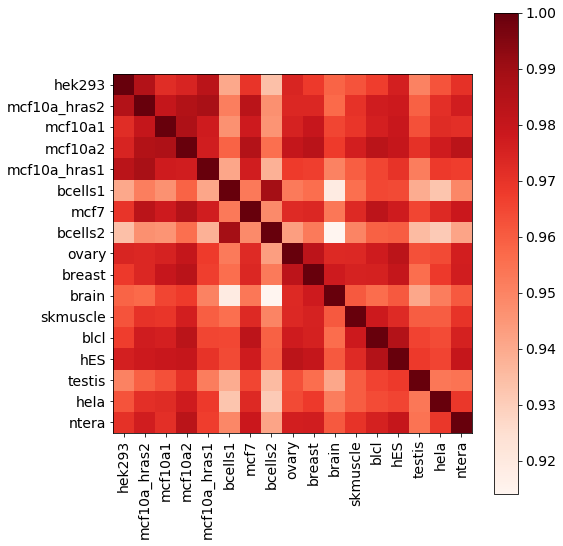

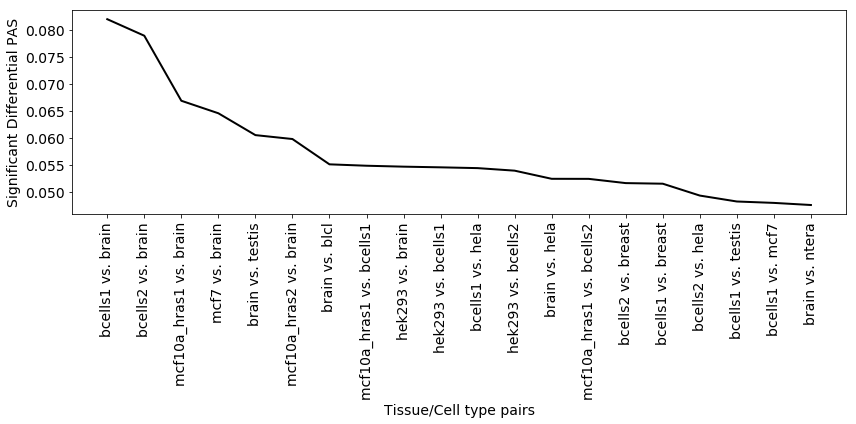

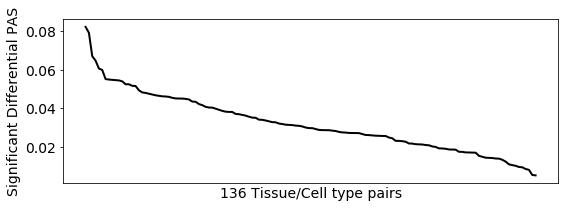

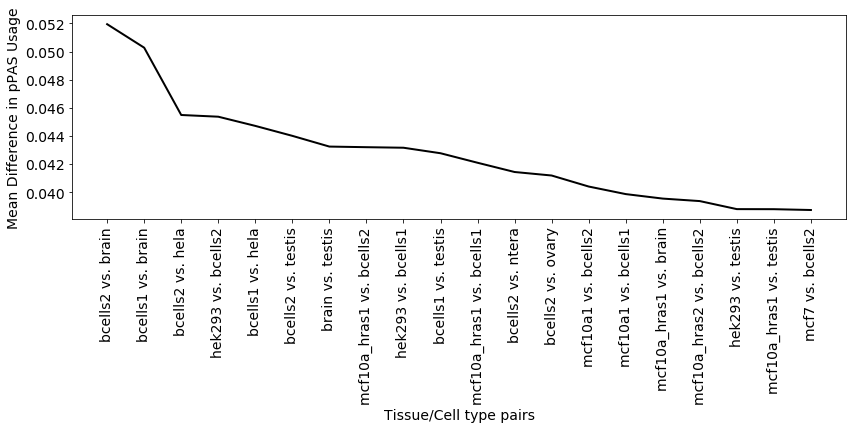

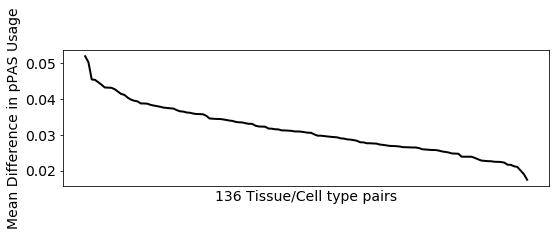

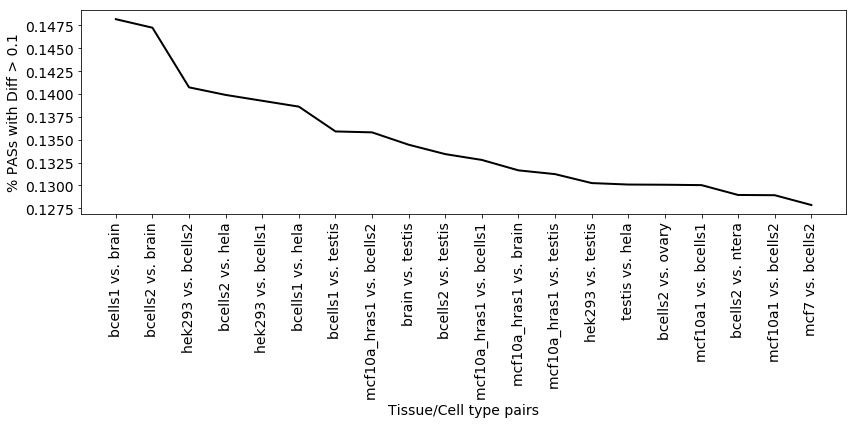

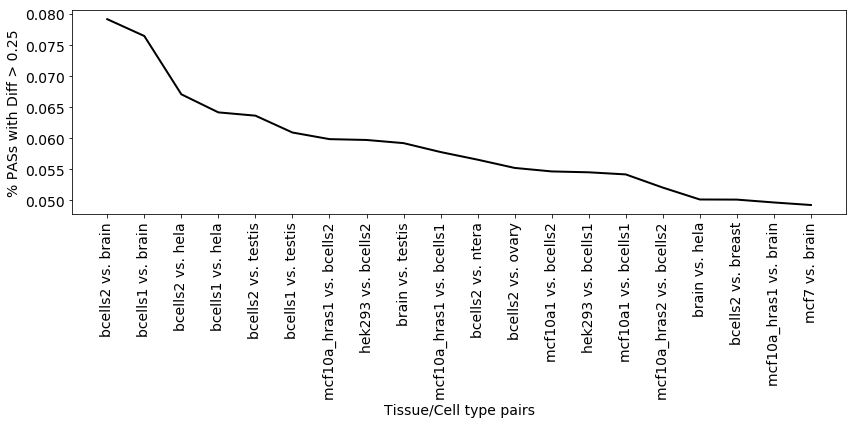

Min R^2 = 0.914
Mean R^2 = 0.9676
Mean % Significant Differential = 0.0321
Mean Isoform Proportion Difference = 0.0313
(Significant) Mean Isoform Proportion Difference = 0.2897
Mean % PASs with Diff > 0.1 = 0.1058
Mean % PASs with Diff > 0.25 = 0.0328

Source = apadb
Tissue 1 = kidney
Tissue 1 = pancreas
Tissue 1 = monocytes
Tissue 1 = all
Tissue 1 = pdac
Tissue 1 = prcc
Tissue 1 = full_blood
Tissue 1 = hlf


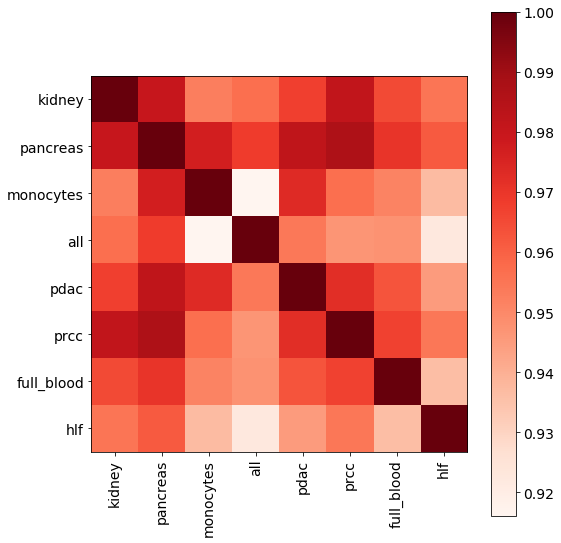

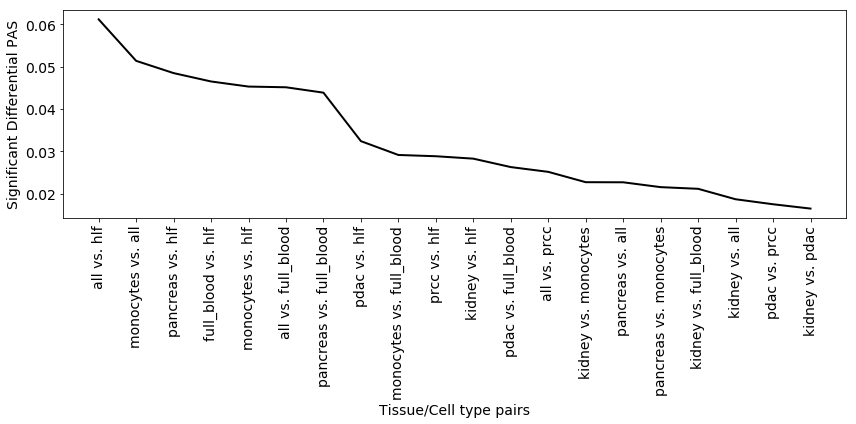

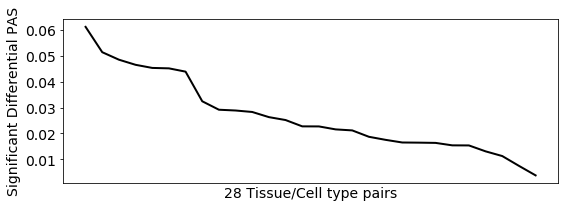

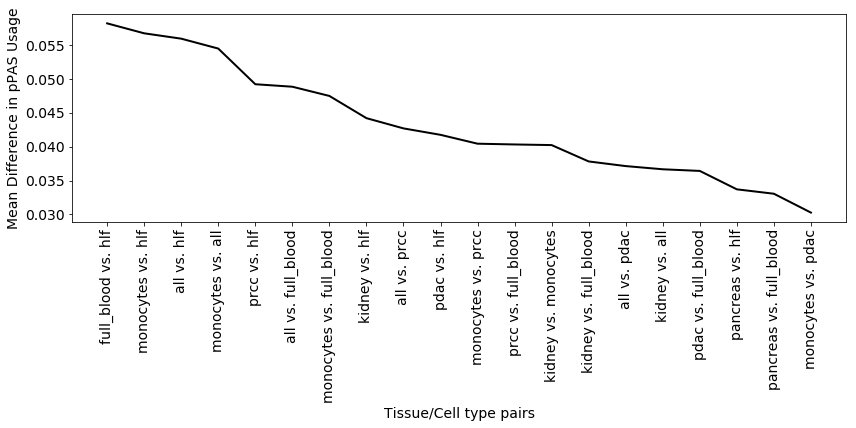

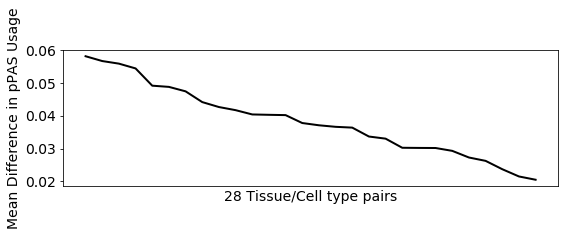

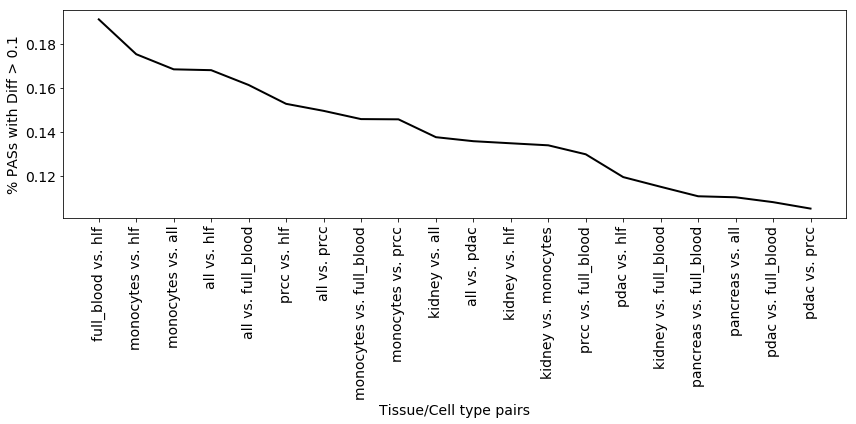

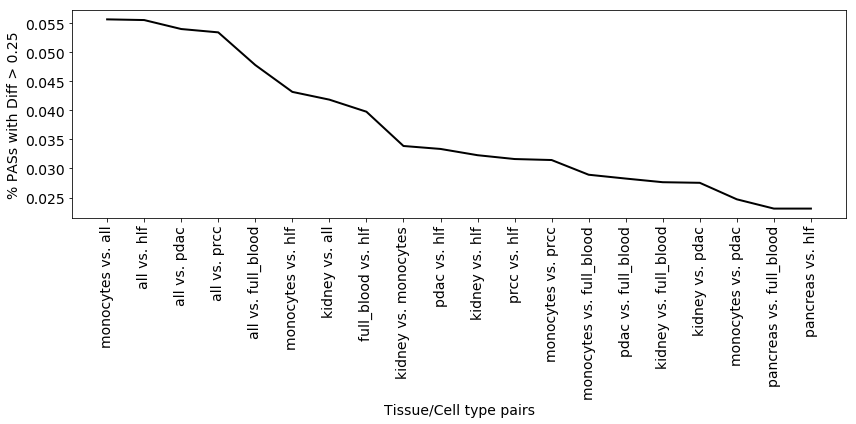

Min R^2 = 0.9161
Mean R^2 = 0.964
Mean % Significant Differential = 0.0269
Mean Isoform Proportion Difference = 0.0384
(Significant) Mean Isoform Proportion Difference = 0.3464
Mean % PASs with Diff > 0.1 = 0.1256
Mean % PASs with Diff > 0.25 = 0.0308



In [22]:
#Differential total site usage analysis

combined_tissue_index = np.concatenate([leslie_tissue_index, apadb_tissue_index])
combined_source_index = np.concatenate([
    np.array(['leslie'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array(['apadb'] * apadb_tissue_index.shape[0], dtype=np.object)
])
combined_suffix_index = np.concatenate([
    np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array([''] * apadb_tissue_index.shape[0], dtype=np.object)
])

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1#1.0#0.0
min_total_count = 20#100
only_differentials = False#True
use_logodds = False#True

#alpha_confidence = 1. / 30000.
alpha_confidence = 10**(-5)#0.00001#10**(-10)#0.01
fixed_isoform_difference_1 = 0.1
fixed_isoform_difference_2 = 0.25

for [source_data, tissue_index, suffix_index] in [('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object)), ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))] :

    print('Source = ' + str(source_data))
    
    r2_map = np.zeros((len(tissue_index), len(tissue_index)))
    r2_map[np.arange(len(tissue_index)), np.arange(len(tissue_index))] = 1
    
    rel_differential_map = np.zeros((len(tissue_index), len(tissue_index)))
    mae_map = np.zeros((len(tissue_index), len(tissue_index)))
    mae_signi_map = np.zeros((len(tissue_index), len(tissue_index)))
    
    rel_isoform_diff_map = np.zeros((len(tissue_index), len(tissue_index)))
    fixed_isoform_diff_map_1 = np.zeros((len(tissue_index), len(tissue_index)))
    fixed_isoform_diff_map_2 = np.zeros((len(tissue_index), len(tissue_index)))

    for tissue_i in range(0, len(tissue_index)) :
        tissue_1 = tissue_index[tissue_i]
        source_data_1 = source_data
        special_mode_1 = suffix_index[tissue_i]

        print('Tissue 1 = ' + str(tissue_1))

        for tissue_j in range(tissue_i + 1, len(tissue_index)) :
            tissue_2 = tissue_index[tissue_j]
            source_data_2 = source_data
            special_mode_2 = suffix_index[tissue_j]

            count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
            count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
            total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
            total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
            df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
            df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
            if site_nums is not None :
                df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

            if only_differentials :
                df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
                df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

            true_metric_tissue_1 = (df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count)
            true_metric_tissue_2 = (df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count)

            if use_logodds :
                true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
                true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))

            pearson_r, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)
            pearson_r2 = round(pearson_r * pearson_r, 4)

            r2_map[tissue_i, tissue_j] = pearson_r2
            r2_map[tissue_j, tissue_i] = pearson_r2
            
            p, log_p = differential_prop_test(np.ravel(df_to_use[count_col_1]) + pseudo_count, np.ravel(df_to_use[total_count_col_1]) + 2. * pseudo_count, np.ravel(df_to_use[count_col_2]) + pseudo_count, np.ravel(df_to_use[total_count_col_2]) + 2. * pseudo_count)
            
            rel_differential_map[tissue_i, tissue_j] = float(len(np.nonzero(p < alpha_confidence)[0])) / float(len(p))
            #rel_differential_map[tissue_j, tissue_i] = float(len(np.nonzero(p < alpha_confidence)[0])) / float(len(p))

            mae = np.mean(np.abs(true_metric_tissue_1 - true_metric_tissue_2))
            mae_signi = np.mean(np.abs(true_metric_tissue_1[p < alpha_confidence] - true_metric_tissue_2[p < alpha_confidence]))
            
            mae_map[tissue_i, tissue_j] = mae
            #mae_map[tissue_j, tissue_i] = mae
            
            mae_signi_map[tissue_i, tissue_j] = mae_signi
            #mae_signi_map[tissue_j, tissue_i] = mae_signi
            
            isoform_diff_abs = np.abs(true_metric_tissue_1 - true_metric_tissue_2)
            
            fixed_isoform_diff_map_1[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > fixed_isoform_difference_1)[0])) / float(len(isoform_diff_abs))
            fixed_isoform_diff_map_2[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > fixed_isoform_difference_2)[0])) / float(len(isoform_diff_abs))
            rel_isoform_diff_map[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > mae)[0])) / float(len(isoform_diff_abs))


    f = plt.figure(figsize=(8, 8))

    #plt.imshow(r2_map, cmap='Reds', vmin=0.0, vmax=1.0)
    #plt.imshow(r2_map, cmap='Reds', vmin=np.min(r2_map) - 0.1, vmax=1.0)
    plt.imshow(r2_map, cmap='Reds')

    plt.xticks(np.arange(len(tissue_index)), tissue_index, fontsize=14, rotation=90)
    plt.yticks(np.arange(len(tissue_index)), tissue_index, fontsize=14, rotation=0)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()

    fig_name = 'pair_usage_heatmap_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')

    plt.show()
    
    
    
    tissue_pair_list = []
    rel_differential_list = []
    mae_list = []
    mae_signi_list = []
    fixed_diff_list_1 = []
    fixed_diff_list_2 = []
    rel_diff_list = []
    for i in range(0, len(tissue_index)) :
        for j in range(i + 1, len(tissue_index)) :
            tissue_pair_list.append(tissue_index[i] + ' vs. ' + tissue_index[j])
            
            rel_differential_list.append(rel_differential_map[i, j])
            mae_list.append(mae_map[i, j])
            mae_signi_list.append(mae_signi_map[i, j])
            
            fixed_diff_list_1.append(fixed_isoform_diff_map_1[i, j])
            fixed_diff_list_2.append(fixed_isoform_diff_map_2[i, j])
            rel_diff_list.append(rel_isoform_diff_map[i, j])
    
    tissue_pairs = np.array(tissue_pair_list, dtype=np.object)
    rel_differentials = np.array(rel_differential_list)
    maes = np.array(mae_list)
    mae_signis = np.array(mae_signi_list)
    fixed_diffs_1 = np.array(fixed_diff_list_1)
    fixed_diffs_2 = np.array(fixed_diff_list_2)
    rel_diffs = np.array(rel_diff_list)
    
    sort_index = np.argsort(rel_differentials)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    mae_signis[np.isnan(mae_signis)] = 0.
    
    top_n = 20
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), rel_differentials[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Significant Differential PAS", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_differentials_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    f = plt.figure(figsize=(8, 3))
    
    plt.plot(np.arange(len(tissue_pairs)), rel_differentials, color='black', linewidth=2)
    
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    
    plt.xlabel(str(len(tissue_pairs)) + " Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Significant Differential PAS", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_all_differentials_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    sort_index = np.argsort(maes)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), maes[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Mean Difference in pPAS Usage", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_maes_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    f = plt.figure(figsize=(8, 3))
    
    plt.plot(np.arange(len(tissue_pairs)), maes, color='black', linewidth=2)
    
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    
    plt.xlabel(str(len(tissue_pairs)) + " Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Mean Difference in pPAS Usage", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_all_maes_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    sort_index = np.argsort(fixed_diffs_1)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), fixed_diffs_1[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("% PASs with Diff > " + str(fixed_isoform_difference_1), fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_fixed_diff_1_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    sort_index = np.argsort(fixed_diffs_2)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), fixed_diffs_2[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("% PASs with Diff > " + str(fixed_isoform_difference_2), fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_fixed_diff_2_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    print("Min R^2 = " + str(round(np.min(r2_map), 4)))
    print("Mean R^2 = " + str(round(np.mean(r2_map), 4)))
    
    print("Mean % Significant Differential = " + str(round(np.mean(rel_differentials), 4)))
    print("Mean Isoform Proportion Difference = " + str(round(np.mean(maes), 4)))
    print("(Significant) Mean Isoform Proportion Difference = " + str(round(np.mean(mae_signis), 4)))
    
    print("Mean % PASs with Diff > " + str(fixed_isoform_difference_1) + " = " + str(round(np.mean(fixed_diffs_1), 4)))
    print("Mean % PASs with Diff > " + str(fixed_isoform_difference_2) + " = " + str(round(np.mean(fixed_diffs_2), 4)))
    print("")
    
    
    

Source = leslie
Tissue 1 = hek293
Tissue 1 = mcf10a_hras2
Tissue 1 = mcf10a1
Tissue 1 = mcf10a2
Tissue 1 = mcf10a_hras1
Tissue 1 = bcells1
Tissue 1 = mcf7
Tissue 1 = bcells2
Tissue 1 = ovary
Tissue 1 = breast
Tissue 1 = brain
Tissue 1 = skmuscle
Tissue 1 = blcl
Tissue 1 = hES
Tissue 1 = testis
Tissue 1 = hela
Tissue 1 = ntera


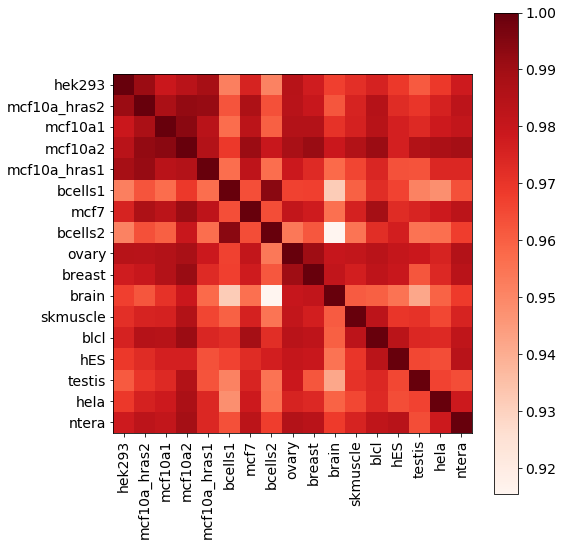

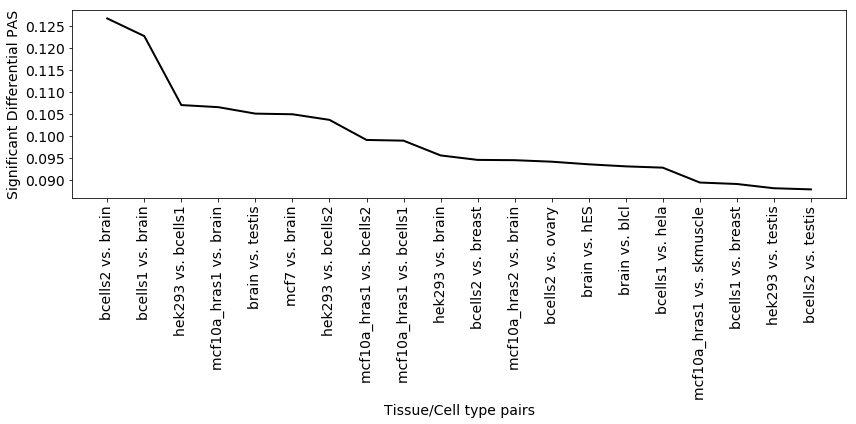

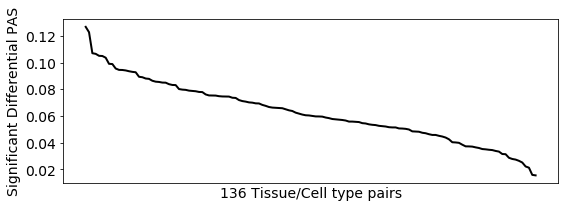

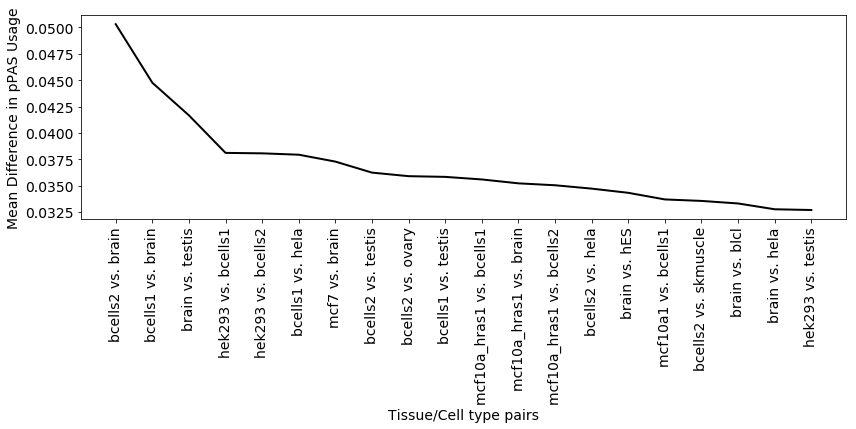

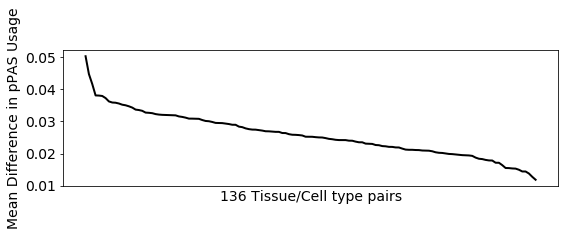

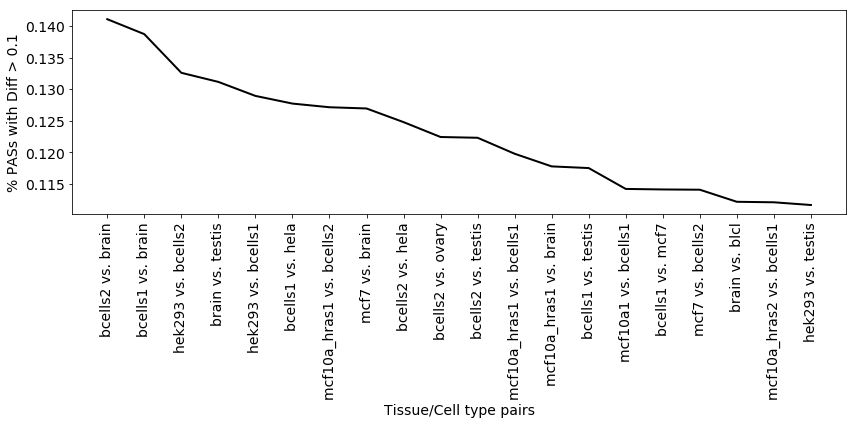

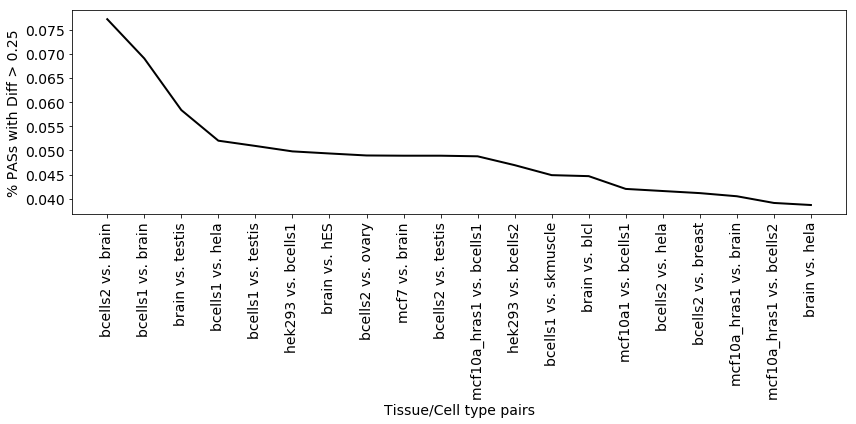

Min R^2 = 0.9154
Mean R^2 = 0.9747
Mean % Significant Differential = 0.0627
Mean Isoform Proportion Difference = 0.0258
(Significant) Mean Isoform Proportion Difference = 0.2335
Mean % PASs with Diff > 0.1 = 0.0882
Mean % PASs with Diff > 0.25 = 0.0253

Source = apadb
Tissue 1 = kidney
Tissue 1 = pancreas
Tissue 1 = monocytes
Tissue 1 = all
Tissue 1 = pdac
Tissue 1 = prcc
Tissue 1 = full_blood
Tissue 1 = hlf


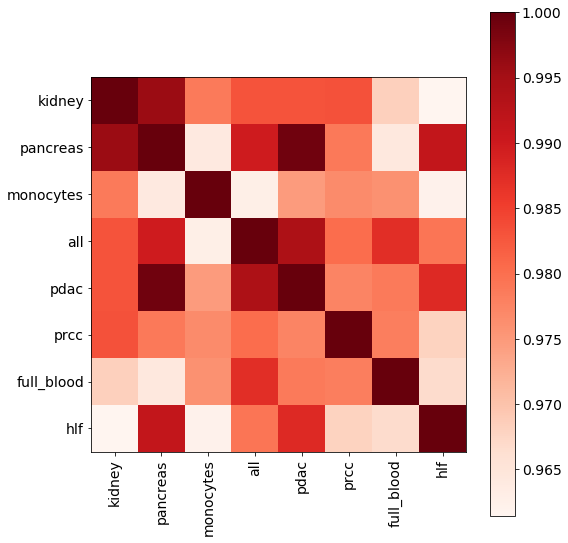

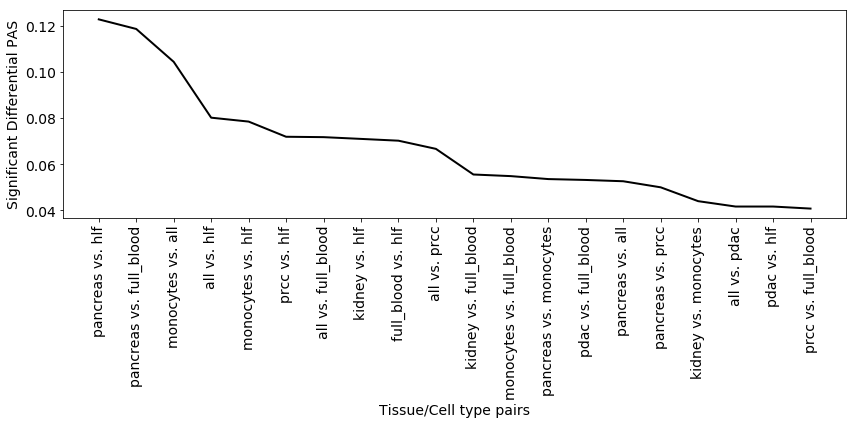

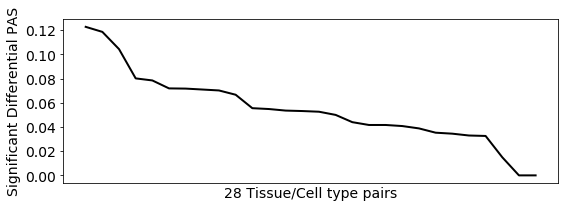

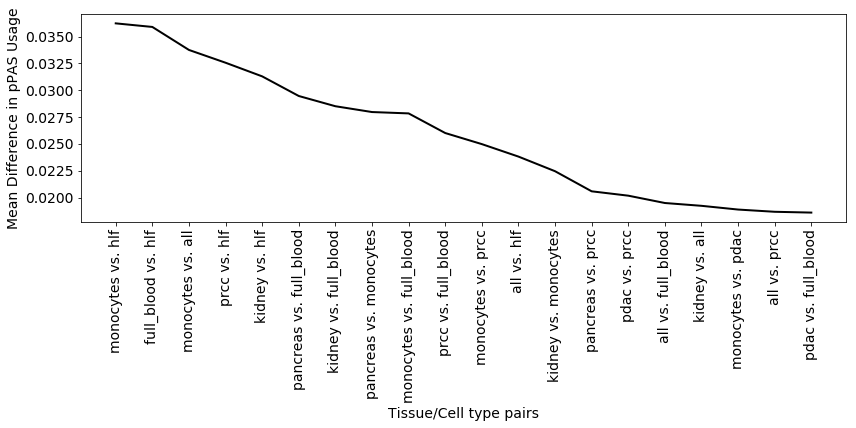

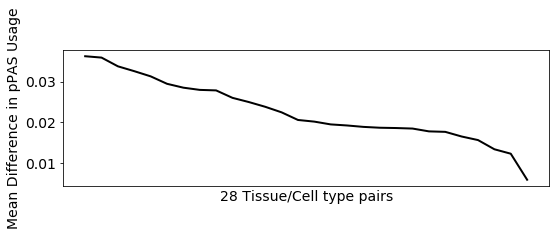

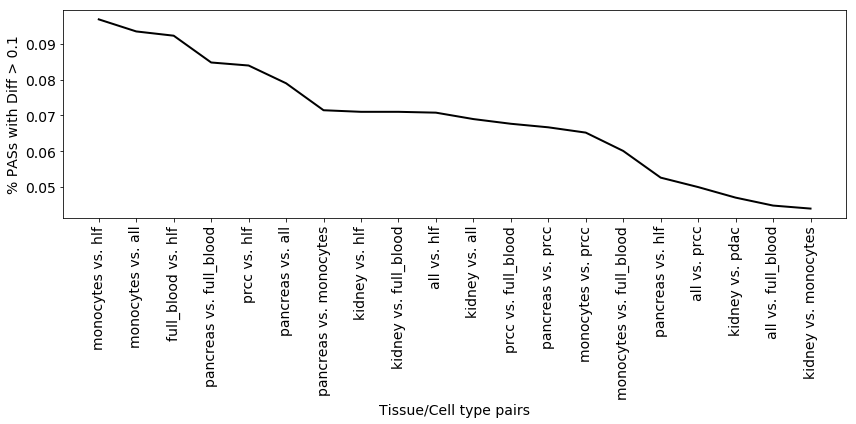

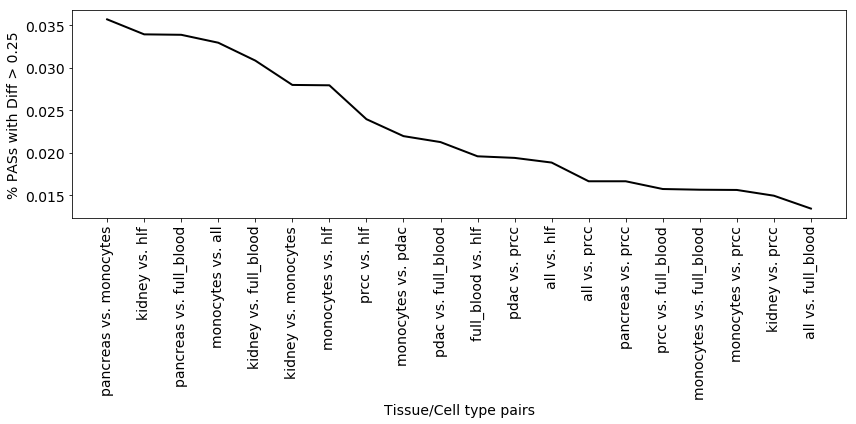

Min R^2 = 0.9614
Mean R^2 = 0.981
Mean % Significant Differential = 0.0548
Mean Isoform Proportion Difference = 0.0226
(Significant) Mean Isoform Proportion Difference = 0.207
Mean % PASs with Diff > 0.1 = 0.0583
Mean % PASs with Diff > 0.25 = 0.0174



In [23]:
#Differential total site usage analysis

combined_tissue_index = np.concatenate([leslie_tissue_index, apadb_tissue_index])
combined_source_index = np.concatenate([
    np.array(['leslie'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array(['apadb'] * apadb_tissue_index.shape[0], dtype=np.object)
])
combined_suffix_index = np.concatenate([
    np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object),
    np.array([''] * apadb_tissue_index.shape[0], dtype=np.object)
])

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1#1.0#0.0
min_total_count = 100#100
only_differentials = False#True
use_logodds = False#True

#alpha_confidence = 1. / 30000.
alpha_confidence = 10**(-5)#0.00001#10**(-10)#0.01
fixed_isoform_difference_1 = 0.1
fixed_isoform_difference_2 = 0.25

for [source_data, tissue_index, suffix_index] in [('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object)), ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))] :

    print('Source = ' + str(source_data))
    
    r2_map = np.zeros((len(tissue_index), len(tissue_index)))
    r2_map[np.arange(len(tissue_index)), np.arange(len(tissue_index))] = 1
    
    rel_differential_map = np.zeros((len(tissue_index), len(tissue_index)))
    mae_map = np.zeros((len(tissue_index), len(tissue_index)))
    mae_signi_map = np.zeros((len(tissue_index), len(tissue_index)))
    
    rel_isoform_diff_map = np.zeros((len(tissue_index), len(tissue_index)))
    fixed_isoform_diff_map_1 = np.zeros((len(tissue_index), len(tissue_index)))
    fixed_isoform_diff_map_2 = np.zeros((len(tissue_index), len(tissue_index)))

    for tissue_i in range(0, len(tissue_index)) :
        tissue_1 = tissue_index[tissue_i]
        source_data_1 = source_data
        special_mode_1 = suffix_index[tissue_i]

        print('Tissue 1 = ' + str(tissue_1))

        for tissue_j in range(tissue_i + 1, len(tissue_index)) :
            tissue_2 = tissue_index[tissue_j]
            source_data_2 = source_data
            special_mode_2 = suffix_index[tissue_j]

            count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
            count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
            total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
            total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
            df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
            df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
            if site_nums is not None :
                df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

            if only_differentials :
                df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
                df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

            true_metric_tissue_1 = (df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count)
            true_metric_tissue_2 = (df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count)

            if use_logodds :
                true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
                true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))

            pearson_r, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)
            pearson_r2 = round(pearson_r * pearson_r, 4)

            r2_map[tissue_i, tissue_j] = pearson_r2
            r2_map[tissue_j, tissue_i] = pearson_r2
            
            p, log_p = differential_prop_test(np.ravel(df_to_use[count_col_1]) + pseudo_count, np.ravel(df_to_use[total_count_col_1]) + 2. * pseudo_count, np.ravel(df_to_use[count_col_2]) + pseudo_count, np.ravel(df_to_use[total_count_col_2]) + 2. * pseudo_count)
            
            rel_differential_map[tissue_i, tissue_j] = float(len(np.nonzero(p < alpha_confidence)[0])) / float(len(p))
            #rel_differential_map[tissue_j, tissue_i] = float(len(np.nonzero(p < alpha_confidence)[0])) / float(len(p))

            mae = np.mean(np.abs(true_metric_tissue_1 - true_metric_tissue_2))
            mae_signi = np.mean(np.abs(true_metric_tissue_1[p < alpha_confidence] - true_metric_tissue_2[p < alpha_confidence]))
            
            mae_map[tissue_i, tissue_j] = mae
            #mae_map[tissue_j, tissue_i] = mae
            
            mae_signi_map[tissue_i, tissue_j] = mae_signi
            #mae_signi_map[tissue_j, tissue_i] = mae_signi
            
            isoform_diff_abs = np.abs(true_metric_tissue_1 - true_metric_tissue_2)
            
            fixed_isoform_diff_map_1[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > fixed_isoform_difference_1)[0])) / float(len(isoform_diff_abs))
            fixed_isoform_diff_map_2[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > fixed_isoform_difference_2)[0])) / float(len(isoform_diff_abs))
            rel_isoform_diff_map[tissue_i, tissue_j] = float(len(np.nonzero(isoform_diff_abs > mae)[0])) / float(len(isoform_diff_abs))


    f = plt.figure(figsize=(8, 8))

    #plt.imshow(r2_map, cmap='Reds', vmin=0.0, vmax=1.0)
    #plt.imshow(r2_map, cmap='Reds', vmin=np.min(r2_map) - 0.1, vmax=1.0)
    plt.imshow(r2_map, cmap='Reds')

    plt.xticks(np.arange(len(tissue_index)), tissue_index, fontsize=14, rotation=90)
    plt.yticks(np.arange(len(tissue_index)), tissue_index, fontsize=14, rotation=0)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()

    fig_name = 'pair_usage_heatmap_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')

    plt.show()
    
    
    
    tissue_pair_list = []
    rel_differential_list = []
    mae_list = []
    mae_signi_list = []
    fixed_diff_list_1 = []
    fixed_diff_list_2 = []
    rel_diff_list = []
    for i in range(0, len(tissue_index)) :
        for j in range(i + 1, len(tissue_index)) :
            tissue_pair_list.append(tissue_index[i] + ' vs. ' + tissue_index[j])
            
            rel_differential_list.append(rel_differential_map[i, j])
            mae_list.append(mae_map[i, j])
            mae_signi_list.append(mae_signi_map[i, j])
            
            fixed_diff_list_1.append(fixed_isoform_diff_map_1[i, j])
            fixed_diff_list_2.append(fixed_isoform_diff_map_2[i, j])
            rel_diff_list.append(rel_isoform_diff_map[i, j])
    
    tissue_pairs = np.array(tissue_pair_list, dtype=np.object)
    rel_differentials = np.array(rel_differential_list)
    maes = np.array(mae_list)
    mae_signis = np.array(mae_signi_list)
    fixed_diffs_1 = np.array(fixed_diff_list_1)
    fixed_diffs_2 = np.array(fixed_diff_list_2)
    rel_diffs = np.array(rel_diff_list)
    
    sort_index = np.argsort(rel_differentials)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    mae_signis[np.isnan(mae_signis)] = 0.
    
    top_n = 20
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), rel_differentials[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Significant Differential PAS", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_differentials_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    f = plt.figure(figsize=(8, 3))
    
    plt.plot(np.arange(len(tissue_pairs)), rel_differentials, color='black', linewidth=2)
    
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    
    plt.xlabel(str(len(tissue_pairs)) + " Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Significant Differential PAS", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_all_differentials_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    sort_index = np.argsort(maes)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), maes[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Mean Difference in pPAS Usage", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_maes_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    f = plt.figure(figsize=(8, 3))
    
    plt.plot(np.arange(len(tissue_pairs)), maes, color='black', linewidth=2)
    
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    
    plt.xlabel(str(len(tissue_pairs)) + " Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("Mean Difference in pPAS Usage", fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_all_maes_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    sort_index = np.argsort(fixed_diffs_1)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), fixed_diffs_1[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("% PASs with Diff > " + str(fixed_isoform_difference_1), fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_fixed_diff_1_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    sort_index = np.argsort(fixed_diffs_2)[::-1]
    tissue_pairs = tissue_pairs[sort_index]
    rel_differentials = rel_differentials[sort_index]
    maes = maes[sort_index]
    mae_signis = mae_signis[sort_index]
    fixed_diffs_1 = fixed_diffs_1[sort_index]
    fixed_diffs_2 = fixed_diffs_2[sort_index]
    rel_diffs = rel_diffs[sort_index]
    
    f = plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(top_n), fixed_diffs_2[:top_n], color='black', linewidth=2)
    
    plt.xticks(np.arange(top_n), tissue_pairs, fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Tissue/Cell type pairs", fontsize=14)
    plt.ylabel("% PASs with Diff > " + str(fixed_isoform_difference_2), fontsize=14)
    
    plt.tight_layout()

    fig_name = 'pair_usage_top_fixed_diff_2_' + str(source_data) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')
    plt.savefig(fig_name + '.svg')
    
    plt.show()
    
    
    print("Min R^2 = " + str(round(np.min(r2_map), 4)))
    print("Mean R^2 = " + str(round(np.mean(r2_map), 4)))
    
    print("Mean % Significant Differential = " + str(round(np.mean(rel_differentials), 4)))
    print("Mean Isoform Proportion Difference = " + str(round(np.mean(maes), 4)))
    print("(Significant) Mean Isoform Proportion Difference = " + str(round(np.mean(mae_signis), 4)))
    
    print("Mean % PASs with Diff > " + str(fixed_isoform_difference_1) + " = " + str(round(np.mean(fixed_diffs_1), 4)))
    print("Mean % PASs with Diff > " + str(fixed_isoform_difference_2) + " = " + str(round(np.mean(fixed_diffs_2), 4)))
    print("")
    
    
    

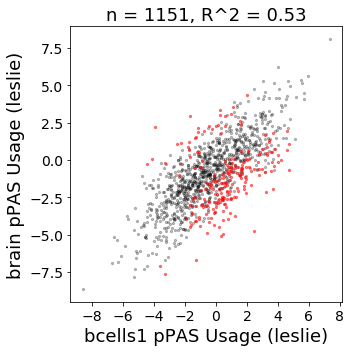

In [112]:
#Differential pairwise site usage analysis, individual scatters

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3']
pseudo_count = 0.1#1.0#0.0
min_total_count = 20#100
only_differentials = False#True
use_logodds = False#True
color_by_sitenum = False

color_significant_sites = True
alpha_confidence = 10**(-10)#0.00001#10**(-10)#0.01

source_data_1 = 'leslie'
tissue_1 = 'bcells1'#'hek293'#'bcells1'
special_mode_1 = '_apadb_region'

source_data_2 = 'leslie'
tissue_2 = 'brain'#'mcf10a_hras1'#'brain'
special_mode_2 = '_apadb_region' #_apadb_region

count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

if only_differentials :
    df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
    df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

true_metric_tissue_1 = (df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count)
true_metric_tissue_2 = (df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count)

if use_logodds :
    true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
    true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))

r_val, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)

f = plt.figure(figsize=(5, 5))

if not (color_by_sitenum or color_significant_sites) :
    plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=0.25, s=5, c='black')
elif color_significant_sites :
    p, log_p = differential_prop_test(np.ravel(df_to_use[count_col_1]) + pseudo_count, np.ravel(df_to_use[total_count_col_1]) + 2. * pseudo_count, np.ravel(df_to_use[count_col_2]) + pseudo_count, np.ravel(df_to_use[total_count_col_2]) + 2. * pseudo_count)
    
    plt.scatter(true_metric_tissue_1[p >= alpha_confidence], true_metric_tissue_2[p >= alpha_confidence], alpha=0.25, s=5, c='black')
    plt.scatter(true_metric_tissue_1[p < alpha_confidence], true_metric_tissue_2[p < alpha_confidence], alpha=0.5, s=5, c='red')
elif color_by_sitenum :
    sitenums = np.ravel(df_to_use['sitenum'].values)
    for sitenum in np.unique(sitenums) :
        if np.any(sitenums == sitenum) :
            plt.scatter(true_metric_tissue_1[sitenums == sitenum], true_metric_tissue_2[sitenums == sitenum], label='Site ' + str(sitenum), alpha=0.25, s=5)

    plt.legend(fontsize=14, frameon=True, framealpha=0.5, loc='lower right')

plt.xlabel(tissue_1.replace('_', ' ') + ' pPAS Usage (' + source_data_1 + ')', fontsize=18)
plt.ylabel(tissue_2.replace('_', ' ') + ' pPAS Usage (' + source_data_2 + ')', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if not use_logodds :
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plt.title('n = ' + str(len(df_to_use)) + ', R^2 = ' + str(round(r_val * r_val, 2)), fontsize=18)

plt.tight_layout()

fig_name = 'pair_usage_scatter_' + str(source_data_1) + '_' + str(tissue_1) + '_' + str(source_data_2) + '_' + str(tissue_2) + '_' + '_'.join(site_types) + '_mincount_' + str(min_total_count) + '_only_diffs_' + str(only_differentials) + '_logodds_' + str(use_logodds)
plt.savefig(fig_name + '.png', transparent=True, dpi=150)
plt.savefig(fig_name + '.eps')
plt.savefig(fig_name + '.svg')

plt.show()


In [12]:
def k_fold_optimize_linear(k, X, y, l2_lambdas=None, l1_lambdas=None, debias_l1=False, min_params=1, max_params=1000) :
    min_loss = np.inf
    min_param = 0
    
    if l2_lambdas is not None :
        for l2_lambda in l2_lambdas :
            total_loss, _ = k_fold_cross_linear(k, X, y, l2_lambda=l2_lambda, l1_lambda=None)
            if total_loss < min_loss :
                min_loss = total_loss
                min_param = l2_lambda
    elif l1_lambdas is not None :
        for l1_lambda in l1_lambdas :
            _, _, _, _, w_bundle = fit_linear_model(X, y, X, y, l2_lambda=None, l1_lambda=l1_lambda)
            w, _ = w_bundle
            n_nonzero = len(np.nonzero(w)[0])
            total_loss = np.inf
            if n_nonzero > 0 :
                if not debias_l1 :
                    total_loss, _ = k_fold_cross_linear(k, X, y, l2_lambda=None, l1_lambda=l1_lambda)
                else :
                    total_loss, _ = k_fold_cross_linear(k, X[:, w != 0], y, l2_lambda=None, l1_lambda=None)

            if total_loss < min_loss and n_nonzero >= min_params and n_nonzero <= max_params :
                min_loss = total_loss
                min_param = l1_lambda
            
            print(str(l1_lambda) + ' = ' + str(total_loss))
    
    return min_loss, min_param

def k_fold_optimize_logistic(k, X, y, l2_lambdas=None) :
    min_loss = np.inf
    min_param = 0
    
    if l2_lambdas is not None :
        for l2_lambda in l2_lambdas :
            total_loss, _ = k_fold_cross_logistic(k, X, y, l2_lambda=l2_lambda, l1_lambda=None)
            if total_loss < min_loss :
                min_loss = total_loss
                min_param = l2_lambda
    
    return min_loss, min_param


def k_fold_cross_linear(k, X, y, l2_lambda=None, l1_lambda=None) :
    n_batches = k
    batch_size = int(X.shape[0] / float(k))
    if batch_size * k < X.shape[0] - 1 :
        n_batches += 1
    
    total_loss = 0
    total_y_hat = []
    
    for batch_index in range(n_batches) :
        X_train = None
        y_train = None
        X_test = None
        y_test = None
        if batch_index < n_batches - 1 :
            
            if batch_index == 0 :
                X_train = X[(batch_index + 1) * batch_size:, :]
                y_train = y[(batch_index + 1) * batch_size:]
            elif isinstance(X, sp.csr_matrix) or isinstance(X, sp.csc_matrix) :
                X_train = sp.vstack([X[:(batch_index - 1) * batch_size, :], X[(batch_index + 1) * batch_size:, :]])
                y_train = np.concatenate([y[:(batch_index - 1) * batch_size], y[(batch_index + 1) * batch_size:]])
            else :
                X_train = np.concatenate([X[:(batch_index - 1) * batch_size, :], X[(batch_index + 1) * batch_size:, :]], axis=0)
                y_train = np.concatenate([y[:(batch_index - 1) * batch_size], y[(batch_index + 1) * batch_size:]])
            
            X_test = X[batch_index * batch_size: (batch_index + 1) * batch_size, :]
            y_test = y[batch_index * batch_size: (batch_index + 1) * batch_size]
        else :
            
            X_train = X[:batch_index * batch_size, :]
            y_train = y[:batch_index * batch_size]
            
            X_test = X[batch_index * batch_size:, :]
            y_test = y[batch_index * batch_size:]
        
        y_test_hat, sse, _, _, _ = fit_linear_model(X_train, y_train, X_test, y_test, l2_lambda, l1_lambda)
        
        total_loss += sse
        total_y_hat.append(y_test_hat)
    
    total_y_hat = np.concatenate(total_y_hat, axis=0)
    
    return total_loss, total_y_hat

def k_fold_cross_logistic(k, X, y, l2_lambda=None) :
    n_batches = k
    batch_size = int(X.shape[0] / float(k))
    if batch_size * k < X.shape[0] - 1 :
        n_batches += 1
    
    total_loss = 0
    total_y_hat = []
    
    for batch_index in range(n_batches) :
        X_train = None
        y_train = None
        X_test = None
        y_test = None
        if batch_index < n_batches - 1 :
            
            if batch_index == 0 :
                X_train = X[(batch_index + 1) * batch_size:, :]
                y_train = y[(batch_index + 1) * batch_size:]
            elif isinstance(X, sp.csr_matrix) or isinstance(X, sp.csc_matrix) :
                X_train = sp.vstack([X[:(batch_index - 1) * batch_size, :], X[(batch_index + 1) * batch_size:, :]])
                y_train = np.concatenate([y[:(batch_index - 1) * batch_size], y[(batch_index + 1) * batch_size:]])
            else :
                X_train = np.concatenate([X[:(batch_index - 1) * batch_size, :], X[(batch_index + 1) * batch_size:, :]], axis=0)
                y_train = np.concatenate([y[:(batch_index - 1) * batch_size], y[(batch_index + 1) * batch_size:]])
            
            X_test = X[batch_index * batch_size: (batch_index + 1) * batch_size, :]
            y_test = y[batch_index * batch_size: (batch_index + 1) * batch_size]
        else :
            
            X_train = X[:batch_index * batch_size, :]
            y_train = y[:batch_index * batch_size]
            
            X_test = X[batch_index * batch_size:, :]
            y_test = y[batch_index * batch_size:]
        
        y_test_hat, kldiv, _, _, _ = fit_logistic_model(X_train, y_train, X_test, y_test, l2_lambda)
        
        total_loss += kldiv
        total_y_hat.append(y_test_hat)
    
    total_y_hat = np.concatenate(total_y_hat, axis=0)
    
    return total_loss, total_y_hat
    

def fit_linear_model(X_train, y_train, X_test, y_test, l2_lambda=None, l1_lambda=None) :
    
    lr = sklinear.LinearRegression()
    if l2_lambda is not None :
        lr = sklinear.Ridge(alpha=l2_lambda)
    elif l1_lambda is not None :
        lr = sklinear.Lasso(alpha=l1_lambda)
    
    lr.fit(X_train, y_train)
    
    y_test_hat = lr.predict(X_test)
    
    SSE = (y_test - y_test_hat).T.dot(y_test - y_test_hat)
    y_test_average = np.average(y_test, axis=0)
    SStot = (y_test - y_test_average).T.dot(y_test - y_test_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y_test) == np.sign(y_test_hat))) / float(X_test.shape[0])
    
    return y_test_hat, SSE, rsquare, accuracy, (lr.coef_, lr.intercept_)

def predict_linear_model(X, w, w_0) :
    return X.dot(w) + w_0

def fit_logistic_model(X_train, y_train, X_test, y_test, l2_lambda=None) :
    
    f_loss = lambda w_bundle, X=X_train, y_true=y_train, alpha=l2_lambda: kl_div_loss(w_bundle, X, y_true, alpha)
    f_grad = lambda w_bundle, X=X_train, y_true=y_train, alpha=l2_lambda: kl_div_gradients(w_bundle, X, y_true, alpha)
    w_bundle_init = np.zeros(X_train.shape[1] + 1)
    res = minimize(f_loss, w_bundle_init, method='BFGS', jac=f_grad, options={'disp': False})

    w_bundle = res.x
    w_0 = w_bundle[0]
    w = w_bundle[1:]

    y_test_hat = get_y_pred(X_test, w, w_0)
    
    SSE = (y_test - y_test_hat).T.dot(y_test - y_test_hat)
    y_test_average = np.average(y_test, axis=0)
    SStot = (y_test - y_test_average).T.dot(y_test - y_test_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y_test) == np.sign(y_test_hat))) / float(X_test.shape[0])
    
    return y_test_hat, kl_div_loss(w_bundle, X_test, y_test, alpha=l2_lambda) * float(X_test.shape[0]), rsquare, accuracy, (w, w_0)

def predict_logistic_model(X, w, w_0) :
    return get_y_pred(X, w, w_0)

def fit_loocv_model(X, y, l2_lambda=None) :
    lr = sklinear.LinearRegression()
    if l2_lambda is not None :
        lr = sklinear.Ridge(alpha=l2_lambda)

    y_hat = cross_val_predict(lr, X, y, cv=X.shape[0])

    SSE = (y - y_hat).T.dot(y - y_hat)
    y_average = np.average(y, axis=0)
    SStot = (y - y_average).T.dot(y - y_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y) == np.sign(y_hat))) / float(X.shape[0])
    
    lr.fit(X, y)
    
    return y_hat, rsquare, accuracy, (lr.coef_, lr.intercept_)

def predict_with_model(X, y, weight_bundle) :
    lr = sklinear.LinearRegression()
    lr.coef_ = weight_bundle[0]
    lr.intercept_ = weight_bundle[1]
    
    y_hat = lr.predict(X)

    SSE = (y - y_hat).T.dot(y - y_hat)
    y_average = np.average(y, axis=0)
    SStot = (y - y_average).T.dot(y - y_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y) == np.sign(y_hat))) / float(X.shape[0])
    
    return y_hat, rsquare, accuracy






def safe_kl_log(num, denom) :
    log_vec = np.zeros(num.shape)
    log_vec[(num > 0) & (denom > 0)] = np.log(num[(num > 0) & (denom > 0)] / denom[(num > 0) & (denom > 0)])
    
    return log_vec

def get_y_pred(X, w, w_0) :
    score = X.dot(w) + w_0
    return 1. / (1. + np.exp(-score))

def kl_div_loss(w_bundle, X, y_true, alpha=0.0) :
    w_0 = w_bundle[0]
    w = w_bundle[1:]
    
    y_pred = get_y_pred(X, w, w_0)
    kl = y_true * safe_kl_log(y_true, y_pred) + (1. - y_true) * safe_kl_log((1. - y_true), (1. - y_pred)) + (1./2.) * alpha * np.dot(w, w)
    
    return np.mean(kl)

def kl_div_gradients(w_bundle, X, y_true, alpha=0.0) :
    w_0 = w_bundle[0]
    w = w_bundle[1:]
    N = float(X.shape[0])
    y_pred = get_y_pred(X, w, w_0)
    
    kl_grad_w = (1. / N) * X.T.dot(y_pred - y_true) + alpha * w
    kl_grad_w_0 = (1. / N) * np.sum(y_pred - y_true)
    
    w_bundle_grads = np.zeros(w.shape[0] + 1)
    w_bundle_grads[0] = kl_grad_w_0
    w_bundle_grads[1:] = kl_grad_w
    
    return w_bundle_grads


def get_6mer_features(df, seq_col, seq_start, seq_end) :
    mer6_dict = {}
    bases = ['A', 'C', 'G', 'T']
    
    i = 0
    for b1 in bases :
        for b2 in bases :
            for b3 in bases :
                for b4 in bases :
                    for b5 in bases :
                        for b6 in bases :
                            mer6_dict[b1 + b2 + b3 + b4 + b5 + b6] = i
                            i += 1
    
    X_mer = sp.lil_matrix((len(df), 4096))
    
    i = 0
    for _, row in df.iterrows() :
        region = row[seq_col][seq_start:seq_end]
        
        for j in range(0, len(region) - 6 + 1) :
            X_mer[i, mer6_dict[region[j:j+6]]] += 1
        
        i += 1
    
    return sp.csr_matrix(X_mer)

def get_pas_features(df, seq_col, seq_start, seq_end) :
    pas_dict = {}
    
    unique_pases = df[seq_col].str.slice(50, 56).unique()
    
    i = 0
    for unique_pas in unique_pases :
        pas_dict[unique_pas] = i
        i += 1
    
    X_mer = sp.lil_matrix((len(df), len(unique_pases)))
    
    i = 0
    for _, row in df.iterrows() :
        region = row[seq_col][seq_start:seq_end]
        
        for j in range(0, len(region) - 6 + 1) :
            X_mer[i, pas_dict[region[j:j+6]]] += 1
        
        i += 1
    
    return sp.csr_matrix(X_mer)

def get_4mer_features(df, seq_col, seq_start, seq_end) :
    mer4_dict = {}
    bases = ['A', 'C', 'G', 'T']
    
    i = 0
    for b1 in bases :
        for b2 in bases :
            for b3 in bases :
                for b4 in bases :
                    mer4_dict[b1 + b2 + b3 + b4] = i
                    i += 1
    
    X_mer = sp.lil_matrix((len(df), 256))
    
    i = 0
    for _, row in df.iterrows() :
        region = row[seq_col][seq_start:seq_end]
        
        for j in range(0, len(region) - 4 + 1) :
            X_mer[i, mer4_dict[region[j:j+4]]] += 1
        
        i += 1
    
    return sp.csr_matrix(X_mer)


In [25]:
site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3']
pseudo_count = 0.5
min_total_count = 1500#500#20
max_cut_region = 60
min_distance = 40
max_distance = 4000
only_differentials = True

use_deep_features = False

source_data = 'leslie'
tissue = 'pooled'
special_mode = '_apadb_region'#'_apadb_region'
pred_special_mode = '_apadb_region'

count_col = source_data + '_count' + special_mode + '_' + tissue + '_prox'
total_count_col = source_data + '_pair_count' + special_mode + '_' + tissue

df_to_use = df_pair_filtered.query(total_count_col + " >= " + str(min_total_count))
df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

if only_differentials :
    df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")

df_to_use = df_to_use.query("(cut_end_prox - cut_start_prox <= " + str(max_cut_region) + ") and (cut_end_dist - cut_start_dist <= " + str(max_cut_region) + ")")
df_to_use = df_to_use.query("(distance >= " + str(min_distance) + ") and (distance <= " + str(max_distance) + ")")

isoform_ratio = (df_to_use[count_col] + pseudo_count) / (df_to_use[total_count_col] + 2. * pseudo_count)
isoform_logodds = np.log(isoform_ratio / (1. - isoform_ratio))


prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)

deep_prox = deep_features_prox[np.ravel(df_to_use['row_index']), :]
deep_dist = deep_features_dist[np.ravel(df_to_use['row_index']), :]
if use_deep_features :
    prox_score = deep_prox
    dist_score = deep_dist

X = np.concatenate([
    prox_score,
    dist_score,
    distance,
], axis=1)

y = isoform_logodds


In [1182]:

X_4mer_up_prox = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_prox', 0, 50))
X_4mer_dn_prox = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_prox', 57, 100))
X_6mer_up_prox = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_prox', 0, 50))
X_6mer_dn_prox = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_prox', 57, 100))
X_pas_prox = sp.csc_matrix(get_pas_features(df_to_use, 'seq_prox', 50, 56))

X_4mer_up_dist = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_dist', 0, 50))
X_4mer_dn_dist = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_dist', 57, 100))
X_6mer_up_dist = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_dist', 0, 50))
X_6mer_dn_dist = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_dist', 57, 100))
X_pas_dist = sp.csc_matrix(get_pas_features(df_to_use, 'seq_dist', 50, 56))

X_sparse = sp.csc_matrix(X)
#X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_4mer_up_prox, X_4mer_dn_prox, X_pas_prox, X_4mer_up_dist, X_4mer_dn_dist, X_pas_dist]))
#X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_pas_prox, X_pas_dist]))
X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_4mer_up_prox, X_4mer_dn_prox, X_4mer_up_dist, X_4mer_dn_dist, X_6mer_up_prox, X_6mer_dn_prox, X_6mer_up_dist, X_6mer_dn_dist]))


In [26]:
train_set_frac=0.75

X_train = X[:int(X.shape[0] * train_set_frac), :]
y_train = y[:int(X.shape[0] * train_set_frac)]

X_test = X[X_train.shape[0]:, :]
y_test = y[X_train.shape[0]:]

n = 354
LOOCV R^2: 0.49
LOOCV accuracy = 0.78


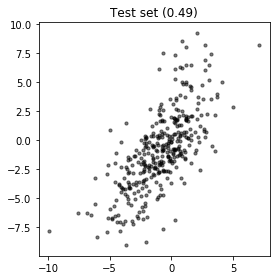

# non-zero weights = 3


In [32]:

y_test_hat, sse, rsquare, accuracy, weight_bundle = fit_linear_model(X_train, y_train, X_test, y_test, l1_lambda=None) #0.035

print("n = " + str(y_test.shape[0]))
print("LOOCV R^2: %0.2f" % (rsquare))

print('LOOCV accuracy = ' + str(round(accuracy, 2)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, alpha=0.5, c='black', s=10)

plt.title('Test set (' + str(round(rsquare, 2)) + ')')
plt.tight_layout()

plt.savefig('leslie_pooled_testset_scatter.png', transparent=True, dpi=150)
plt.savefig('leslie_pooled_testset_scatter.eps')
plt.show()

w, w_0 = weight_bundle

print('# non-zero weights = ' + str(len(np.nonzero(w)[0])))


n = 1415
LOOCV R^2: 0.46
LOOCV accuracy = 0.76


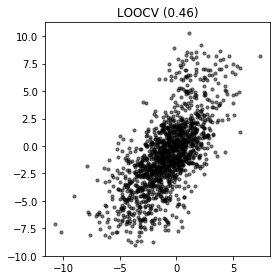

In [34]:

y_hat, rsquare, accuracy, weight_bundle = fit_loocv_model(X, y, l2_lambda=None)

print("n = " + str(X.shape[0]))
print("LOOCV R^2: %0.2f" % (rsquare))

print('LOOCV accuracy = ' + str(round(accuracy, 2)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_hat, y, alpha=0.5, c='black', s=10)

plt.title('LOOCV (' + str(round(rsquare, 2)) + ')')
plt.tight_layout()

plt.savefig('leslie_pooled_loocv_scatter.png', transparent=True, dpi=150)
plt.savefig('leslie_pooled_loocv_scatter.eps')
plt.show()




n = 1415
LOOCV R^2: 0.46
LOOCV accuracy = 0.76


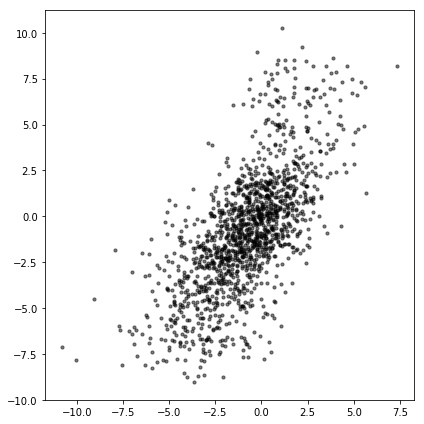

In [29]:

_, y_hat = k_fold_cross_linear(50, X, y, l2_lambda=None, l1_lambda=None)

SSE = (y - y_hat).T.dot(y - y_hat)
y_average = np.average(y, axis=0)
SStot = (y - y_average).T.dot(y - y_average)
rsquare = 1.0 - (SSE / SStot)

accuracy = float(np.count_nonzero(np.sign(y) == np.sign(y_hat))) / float(X.shape[0])

print("n = " + str(X.shape[0]))
print("LOOCV R^2: %0.2f" % (rsquare))

print('LOOCV accuracy = ' + str(round(accuracy, 2)))

f = plt.figure(figsize=(6, 6))

plt.scatter(y_hat, y, alpha=0.5, c='black', s=10)

plt.tight_layout()
plt.show()




In [28]:
#Start of multiplex analysis

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.5
min_total_apadb_count = 10#500#20
min_total_leslie_count = 10
max_cut_region = 60
min_distance = 40
max_distance = 4000
only_differentials = False

apadb_total_count_col = 'apadb_total_count_pooled'
leslie_total_count_col = 'leslie_total_count_apadb_region_pooled'

#Apply global pre-filters
df_to_use = df_pair_filtered.query(apadb_total_count_col + " >= " + str(min_total_apadb_count))
df_to_use = df_to_use.query(leslie_total_count_col + " >= " + str(min_total_leslie_count))
df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]
if only_differentials :
    df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")
df_to_use = df_to_use.query("(cut_end_prox - cut_start_prox <= " + str(max_cut_region) + ") and (cut_end_dist - cut_start_dist <= " + str(max_cut_region) + ")")
df_to_use = df_to_use.query("(distance >= " + str(min_distance) + ") and (distance <= " + str(max_distance) + ")")

df_to_use = df_to_use.query("mirna_prox == mirna_dist")

#Shuffle dataframe

shuffle_index = np.arange(len(df_to_use))
np.random.shuffle(shuffle_index)

df_all = df_to_use.iloc[shuffle_index].copy().reset_index(drop=True)

print('Total size = ' + str(len(df_all)))

#Split into training and test data

train_set_frac = 0.5

df_train = df_all.iloc[:int(len(df_all) * train_set_frac)]
df_test = df_all.iloc[len(df_train):]

print('Train size = ' + str(len(df_train)))
print('Test size = ' + str(len(df_test)))


Total size = 15912
Train size = 7956
Test size = 7956


In [29]:
def get_data(df, source_data, tissue, special_mode, pred_special_mode, pseudo_count=0.5, min_total_count=20, only_differentials=False) :
    count_col = source_data + '_count' + special_mode + '_' + tissue + '_prox'
    total_count_col = source_data + '_pair_count' + special_mode + '_' + tissue

    df_to_use = df.query(total_count_col + " >= " + str(min_total_count))
    if only_differentials :
        df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")

    total_count = np.ravel(df_to_use[total_count_col].values)
    y_ratio = (df_to_use[count_col] + pseudo_count) / (df_to_use[total_count_col] + 2. * pseudo_count)
    y_logodds = np.log(y_ratio / (1. - y_ratio))

    prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
    dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
    distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)

    X = np.concatenate([
        prox_score,
        dist_score,
        distance
    ], axis=1)

    return X, y_ratio, y_logodds, total_count, df_to_use


In [30]:
#Initialize results

tissue_results_dict = {}

In [31]:
print(apadb_tissue_index)
print(leslie_tissue_index)

['kidney' 'pancreas' 'monocytes' 'all' 'pdac' 'prcc' 'full_blood' 'hlf']
['hek293' 'mcf10a_hras2' 'mcf10a1' 'mcf10a2' 'mcf10a_hras1' 'bcells1'
 'mcf7' 'bcells2' 'ovary' 'breast' 'brain' 'skmuscle' 'blcl' 'hES'
 'testis' 'hela' 'ntera']


In [32]:

count_filters = {
    'apadb_pooled' : 1000,
    'apadb_kidney' : 20,
    'apadb_pancreas' : 10,
    'apadb_monocytes' : 20,
    'apadb_all' : 20,
    'apadb_pdac' : 20,
    'apadb_prcc' : 20,
    'apadb_full_blood' : 500,
    'apadb_hlf' : 500,
    
    'leslie_pooled' : 1000,
    'leslie_hek293' : 50,
    'leslie_mcf10a_hras2' : 50,
    'leslie_mcf10a1' : 50,
    'leslie_mcf10a2' : 50,
    'leslie_mcf10a_hras1' : 50,
    'leslie_bcells1' : 50,
    'leslie_mcf7' : 50,
    'leslie_bcells2' : 50,
    'leslie_ovary' : 50,
    'leslie_breast' : 50,
    'leslie_brain' : 50,
    'leslie_skmuscle' : 50,
    'leslie_blcl' : 50,
    'leslie_hES' : 50,
    'leslie_testis' : 50,
    'leslie_hela' : 50,
    'leslie_ntera' : 50
}


In [33]:
#Fit on APADB pooled, predict on everything

X_apadb, y_ratio_apadb, y_logodds_apadb, count_apadb, df_apadb = get_data(df_all, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=False)
X_apadb_train, y_ratio_apadb_train, y_logodds_apadb_train, count_apadb_train, df_apadb_train = get_data(df_train, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=False)
X_apadb_test, y_ratio_apadb_test, y_logodds_apadb_test, count_apadb_test, df_apadb_test = get_data(df_test, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=False)

_, _, _, _, w_bundle_linear = fit_linear_model(X_apadb, y_logodds_apadb, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)
w_linear, w_linear_0 = w_bundle_linear

_, _, _, _, w_bundle_logistic = fit_logistic_model(X_apadb, y_ratio_apadb, X_apadb, y_ratio_apadb, l2_lambda=0.0)
w_logistic, w_logistic_0 = w_bundle_logistic

y_logodds_apadb_test_hat, _, _, _, w_bundle_linear_train = fit_linear_model(X_apadb_train, y_logodds_apadb_train, X_apadb_test, y_logodds_apadb_test, l2_lambda=None, l1_lambda=None)
w_linear_train, w_linear_0_train = w_bundle_linear_train

y_ratio_apadb_test_hat, _, _, _, w_bundle_logistic_train = fit_logistic_model(X_apadb_train, y_ratio_apadb_train, X_apadb_test, y_ratio_apadb_test, l2_lambda=0.0)
w_logistic_train, w_logistic_0_train = w_bundle_logistic_train


_, y_logodds_apadb_hat = k_fold_cross_linear(50, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)

_, y_ratio_apadb_hat = k_fold_cross_logistic(50, X_apadb, y_ratio_apadb, l2_lambda=0.0)

tissue_results_dict['apadb_pooled'] = {}
tissue_results_dict['apadb_pooled']['apadb_pooled'] = {}
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_logodds'] = y_logodds_apadb
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_ratio'] = y_ratio_apadb
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_logodds_hat'] = y_logodds_apadb_hat
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_ratio_hat'] = y_ratio_apadb_hat
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_logodds_test'] = y_logodds_apadb_test
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_ratio_test'] = y_ratio_apadb_test
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_logodds_test_hat'] = y_logodds_apadb_test_hat
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_ratio_test_hat'] = y_ratio_apadb_test_hat
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_count'] = count_apadb
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_count_test'] = count_apadb_test
tissue_results_dict['apadb_pooled']['apadb_pooled']['df'] = df_apadb
tissue_results_dict['apadb_pooled']['apadb_pooled']['df_test'] = df_apadb_test

for tissue in apadb_tissue_index :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)
    
    y_logodds_tissue_hat = predict_linear_model(X_tissue, w_linear, w_linear_0)
    
    y_ratio_tissue_hat = predict_logistic_model(X_tissue, w_logistic, w_logistic_0)
    
    y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)
    
    y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

    tissue_results_dict['apadb_pooled']['apadb_' + tissue] = {}
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['df_test'] = df_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)
    
    y_logodds_tissue_hat = predict_linear_model(X_tissue, w_linear, w_linear_0)
    
    y_ratio_tissue_hat = predict_logistic_model(X_tissue, w_logistic, w_logistic_0)
    
    y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)
    
    y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

    tissue_results_dict['apadb_pooled']['leslie_' + tissue] = {}
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['df_test'] = df_tissue_test


In [34]:
#Fit on APADB pooled, predict on everything, differentials only

X_apadb, y_ratio_apadb, y_logodds_apadb, count_apadb, df_apadb = get_data(df_all, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=True)
X_apadb_train, y_ratio_apadb_train, y_logodds_apadb_train, count_apadb_train, df_apadb_train = get_data(df_train, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=True)
X_apadb_test, y_ratio_apadb_test, y_logodds_apadb_test, count_apadb_test, df_apadb_test = get_data(df_test, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=True)

_, _, _, _, w_bundle_linear = fit_linear_model(X_apadb, y_logodds_apadb, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)
w_linear, w_linear_0 = w_bundle_linear

_, _, _, _, w_bundle_logistic = fit_logistic_model(X_apadb, y_ratio_apadb, X_apadb, y_ratio_apadb, l2_lambda=0.0)
w_logistic, w_logistic_0 = w_bundle_logistic

y_logodds_apadb_test_hat, _, _, _, w_bundle_linear_train = fit_linear_model(X_apadb_train, y_logodds_apadb_train, X_apadb_test, y_logodds_apadb_test, l2_lambda=None, l1_lambda=None)
w_linear_train, w_linear_0_train = w_bundle_linear_train

y_ratio_apadb_test_hat, _, _, _, w_bundle_logistic_train = fit_logistic_model(X_apadb_train, y_ratio_apadb_train, X_apadb_test, y_ratio_apadb_test, l2_lambda=0.0)
w_logistic_train, w_logistic_0_train = w_bundle_logistic_train


_, y_logodds_apadb_hat = k_fold_cross_linear(50, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)

_, y_ratio_apadb_hat = k_fold_cross_logistic(50, X_apadb, y_ratio_apadb, l2_lambda=0.0)

tissue_results_dict['apadb_pooled_differential'] = {}
tissue_results_dict['apadb_pooled_differential']['apadb_pooled'] = {}
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_logodds'] = y_logodds_apadb
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_ratio'] = y_ratio_apadb
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_logodds_hat'] = y_logodds_apadb_hat
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_ratio_hat'] = y_ratio_apadb_hat
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_logodds_test'] = y_logodds_apadb_test
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_ratio_test'] = y_ratio_apadb_test
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_logodds_test_hat'] = y_logodds_apadb_test_hat
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_ratio_test_hat'] = y_ratio_apadb_test_hat
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_count'] = count_apadb
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_count_test'] = count_apadb_test
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['df'] = df_apadb
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['df_test'] = df_apadb_test

for tissue in apadb_tissue_index :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    
    if X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_hat = predict_linear_model(X_tissue, w_linear, w_linear_0)
    
    y_ratio_tissue_hat = predict_logistic_model(X_tissue, w_logistic, w_logistic_0)
    
    y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)
    
    y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue] = {}
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['df_test'] = df_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    
    if X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_hat = predict_linear_model(X_tissue, w_linear, w_linear_0)
    
    y_ratio_tissue_hat = predict_logistic_model(X_tissue, w_logistic, w_logistic_0)
    
    y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)
    
    y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue] = {}
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['df_tissue_test'] = df_tissue_test


In [35]:
#Fit and predict on individual tissues


for tissue in apadb_tissue_index :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['apadb_' + tissue] = {}
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue] = {}
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['df_test'] = df_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['leslie_' + tissue] = {}
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue] = {}
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['df'] = df_tissue
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['df_test'] = df_tissue_test


In [36]:
#Fit and predict on individual tissues, differentials only


for tissue in apadb_tissue_index :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['apadb_' + tissue + '_differential'] = {}
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue] = {}
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['df_test'] = df_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['leslie_' + tissue + '_differential'] = {}
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue] = {}
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['df'] = df_tissue
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['df_test'] = df_tissue_test


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:151: RuntimeWarning: divide by zero encountered in double_scalars
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:176: RuntimeWarning: divide by zero encountered in double_scalars


In [23]:
def get_data_w_nmers(df, source_data, tissue, special_mode, pred_special_mode, pseudo_count=0.5, min_total_count=20, only_differentials=False) :
    count_col = source_data + '_count' + special_mode + '_' + tissue + '_prox'
    total_count_col = source_data + '_pair_count' + special_mode + '_' + tissue

    df_to_use = df.query(total_count_col + " >= " + str(min_total_count))
    if only_differentials :
        df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")

    total_count = np.ravel(df_to_use[total_count_col].values)
    y_ratio = (df_to_use[count_col] + pseudo_count) / (df_to_use[total_count_col] + 2. * pseudo_count)
    y_logodds = np.log(y_ratio / (1. - y_ratio))

    prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
    dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
    distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)

    X = np.concatenate([
        prox_score,
        dist_score,
        distance
    ], axis=1)
    
    X_4mer_up_prox = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_prox', 0, 50))
    X_4mer_dn_prox = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_prox', 57, 100))
    X_6mer_up_prox = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_prox', 0, 50))
    X_6mer_dn_prox = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_prox', 57, 100))

    X_4mer_up_dist = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_dist', 0, 50))
    X_4mer_dn_dist = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_dist', 57, 100))
    X_6mer_up_dist = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_dist', 0, 50))
    X_6mer_dn_dist = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_dist', 57, 100))

    X_sparse = sp.csc_matrix(X)
    X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_4mer_up_prox, X_4mer_dn_prox, X_4mer_up_dist, X_4mer_dn_dist]))
    #X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_4mer_up_prox, X_4mer_dn_prox, X_4mer_up_dist, X_4mer_dn_dist, X_6mer_up_prox, X_6mer_dn_prox, X_6mer_up_dist, X_6mer_dn_dist]))
    
    return X_sparse, y_ratio, y_logodds, total_count

In [24]:
#Fit and predict on individual tissues, with n-mer corrections, differentials only

use_l1_lambda = True
l1_lambdas = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.25, 0.5]

find_optimal_l2_lamda = False
l2_lambdas = [0, 20, 50, 100, 200, 400, 750, 1000]

for tissue in np.concatenate([apadb_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    print(tissue)
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue = get_data_w_nmers(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train = get_data_w_nmers(df_train, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test = get_data_w_nmers(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    _, min_l1_lambda = k_fold_optimize_linear(10, X_tissue, y_logodds_tissue, l1_lambdas=l1_lambdas, debias_l1=True, min_params = 10, max_params=min(200, int(X_tissue.shape[0] / 1)))
    if min_l1_lambda not in l1_lambdas :
        min_l1_lambda = 0.1

    _, _, _, _, weight_bundle_lasso = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l1_lambda=min_l1_lambda)
    w_lasso, _ = weight_bundle_lasso
    w_nonzero = w_lasso != 0
    
    if not use_l1_lambda :
        min_l1_lambda = None
    
    X_tissue = X_tissue[:, w_nonzero]
    X_tissue_train = X_tissue_train[:, w_nonzero]
    X_tissue_test = X_tissue_test[:, w_nonzero]
    
    min_l2_lambda = 0.0
    if find_optimal_l2_lamda :
        _, min_l2_lambda = k_fold_optimize_linear(10, X_tissue, y_logodds_tissue, l2_lambdas=l2_lambdas, min_params = 10, max_params=len(np.nonzero(w_nonzero)[0]))
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=min_l2_lambda, l1_lambda=min_l1_lambda)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=min_l2_lambda, l1_lambda=min_l1_lambda)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['apadb_' + tissue + '_nmer'] = {}
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue] = {}
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['num_nmers'] = len(np.nonzero(w_nonzero)[0]) - 3
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_count_test'] = count_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    print(tissue)
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue = get_data_w_nmers(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train = get_data_w_nmers(df_train, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test = get_data_w_nmers(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    _, min_l1_lambda = k_fold_optimize_linear(10, X_tissue, y_logodds_tissue, l1_lambdas=l1_lambdas, debias_l1=True, min_params = 10, max_params=min(200, int(X_tissue.shape[0] / 1)))
    if min_l1_lambda not in l1_lambdas :
        min_l1_lambda = 0.1

    _, _, _, _, weight_bundle_lasso = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l1_lambda=min_l1_lambda)
    w_lasso, _ = weight_bundle_lasso
    w_nonzero = w_lasso != 0
    
    if not use_l1_lambda :
        min_l1_lambda = None
    
    X_tissue = X_tissue[:, w_nonzero]
    X_tissue_train = X_tissue_train[:, w_nonzero]
    X_tissue_test = X_tissue_test[:, w_nonzero]
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=min_l1_lambda)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=min_l1_lambda)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['leslie_' + tissue + '_nmer'] = {}
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue] = {}
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['num_nmers'] = len(np.nonzero(w_nonzero)[0]) - 3
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_count_test'] = count_tissue_test


kidney
0.01 = 1409.7046642377622
0.02 = 654.7080048169462
0.04 = 532.6117494404914
0.06 = 633.2065999498088
0.08 = 650.9710721266836
0.1 = 733.3314440290757
0.25 = 807.8171856796935
0.5 = 810.5266716541666
pancreas
0.01 = 52.321929040089614
0.02 = 1413.7187062863875
0.04 = 247.43476509370188
0.06 = 146.21595721566393
0.08 = 161.66251675334223
0.1 = 154.49212176772681
0.25 = 258.9191219879336
0.5 = 281.00982365647843


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:151: RuntimeWarning: divide by zero encountered in double_scalars
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:176: RuntimeWarning: divide by zero encountered in double_scalars


monocytes
0.01 = 4269.016524795168
0.02 = 4012.2697207348924
0.04 = 4130.159361493121
0.06 = 4223.276241621554
0.08 = 4241.6589935975435
0.1 = 4340.344099701512
0.25 = 4377.1196703315645
0.5 = 4393.323738749417
all
0.01 = 234.89625376308476
0.02 = 1859.5362224535127
0.04 = 361.45068726769136
0.06 = 303.74053074432857
0.08 = 353.10008141519637
0.1 = 345.10074328309366
0.25 = 458.5851673172722
0.5 = 471.4134795260104
pdac
0.01 = 18.089772153955355
0.02 = 91.7240701793298
0.04 = 121.04962799582817
0.06 = 165.45972551060368
0.08 = 144.74653908689714
0.1 = 139.013589372041
0.25 = 238.15967453944182
0.5 = 290.43244564963743


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


prcc
0.01 = 2560.253902919044
0.02 = 2126.1994951914844
0.04 = 2190.343291664876
0.06 = 2328.9447850724955
0.08 = 2436.601444848199
0.1 = 2464.3768615873155
0.25 = 2492.3513740168955
0.5 = 2500.6288846579837
full_blood
0.01 = 8023.3601242811965
0.02 = 5542.2707464133455
0.04 = 4957.597092181248
0.06 = 4722.080337158193
0.08 = 4878.511922471519
0.1 = 5158.58709430712
0.25 = 5851.972800895796
0.5 = 5965.5916694471525
hlf
0.01 = 11271.010345706953
0.02 = 10374.956293017687
0.04 = 10408.564880802294
0.06 = 10603.15105357143
0.08 = 10890.152617905384
0.1 = 10930.277853619411
0.25 = 11345.502561694757
0.5 = 11345.502561694757
pooled
0.01 = 16016.477611327968
0.02 = 14541.320646620301
0.04 = 14313.383025747806
0.06 = 14744.00529755712
0.08 = 15014.21059419605
0.1 = 15386.896116297181
0.25 = 15892.404553428212
0.5 = 15892.404553428212
hek293
0.01 = 4127.1393752795975
0.02 = 3468.280979595771
0.04 = 3508.246568406986
0.06 = 3629.836735899978
0.08 = 3621.219551025505
0.1 = 3689.8398940813154
0.2

In [25]:

def plot_tissue_result(tissue_name, tissue_results, ax_scatter, ax_roc, max_n_members) :
    y_logodds_tissue = np.ravel(tissue_results['y_logodds'])
    y_ratio_tissue = np.ravel(tissue_results['y_ratio'])
    y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_hat'])
    y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_hat'])
    y_logodds_tissue_test = np.ravel(tissue_results['y_logodds_test'])
    y_ratio_tissue_test = np.ravel(tissue_results['y_ratio_test'])
    y_logodds_tissue_test_hat = np.ravel(tissue_results['y_logodds_test_hat'])
    y_ratio_tissue_test_hat = np.ravel(tissue_results['y_ratio_test_hat'])
    y_count_tissue = np.ravel(tissue_results['y_count'])
    y_count_tissue_test = np.ravel(tissue_results['y_count_test'])

    if max_n_members is not None :
        sort_index = np.argsort(y_count_tissue)[::-1]
        y_count_tissue = y_count_tissue[sort_index[:max_n_members]]
        y_ratio_tissue = y_ratio_tissue[sort_index[:max_n_members]]
        y_ratio_tissue_hat = y_ratio_tissue_hat[sort_index[:max_n_members]]
        y_logodds_tissue = y_logodds_tissue[sort_index[:max_n_members]]
        y_logodds_tissue_hat = y_logodds_tissue_hat[sort_index[:max_n_members]]

    r_val, p_val = pearsonr(y_logodds_tissue_hat, y_logodds_tissue)

    y_label_tissue = np.zeros(y_ratio_tissue.shape[0])
    y_label_tissue[y_ratio_tissue <= 0.5] = 0
    y_label_tissue[y_ratio_tissue > 0.5] = 1

    fpr, tpr, _ = roc_curve(y_label_tissue, y_ratio_tissue_hat)
    auc = roc_auc_score(y_label_tissue, y_ratio_tissue_hat)
    
    fpr_highconf, tpr_highconf, _ = roc_curve(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])
    auc_highconf = roc_auc_score(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])

    ax_scatter.scatter(y_logodds_tissue_hat, y_logodds_tissue, alpha=0.25, c='black', s=5)
    plt.sca(ax_scatter)
    plt.ylabel(tissue_name)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('R^2 = ' + str(round(r_val * r_val, 2)))

    l1 = ax_roc.plot(fpr, tpr, linewidth=2, color='black', label='AUC = ' + str(round(auc, 3)))
    l1_highconf = ax_roc.plot(fpr_highconf, tpr_highconf, linewidth=2, color='red', label='AUC = ' + str(round(auc_highconf, 3)))
    
    plt.sca(ax_roc)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlim(0-0.01, 1)
    plt.ylim(0, 1+0.01)
    plt.legend(handles=[l1[0], l1_highconf[0]], fontsize=9, frameon=False, loc='lower right')
    #plt.title('AUC = ' + str(round(auc, 4)))
    
    n_samples = len(y_ratio_tissue)
    avg_reads = np.mean(y_count_tissue)
    
    return n_samples, avg_reads


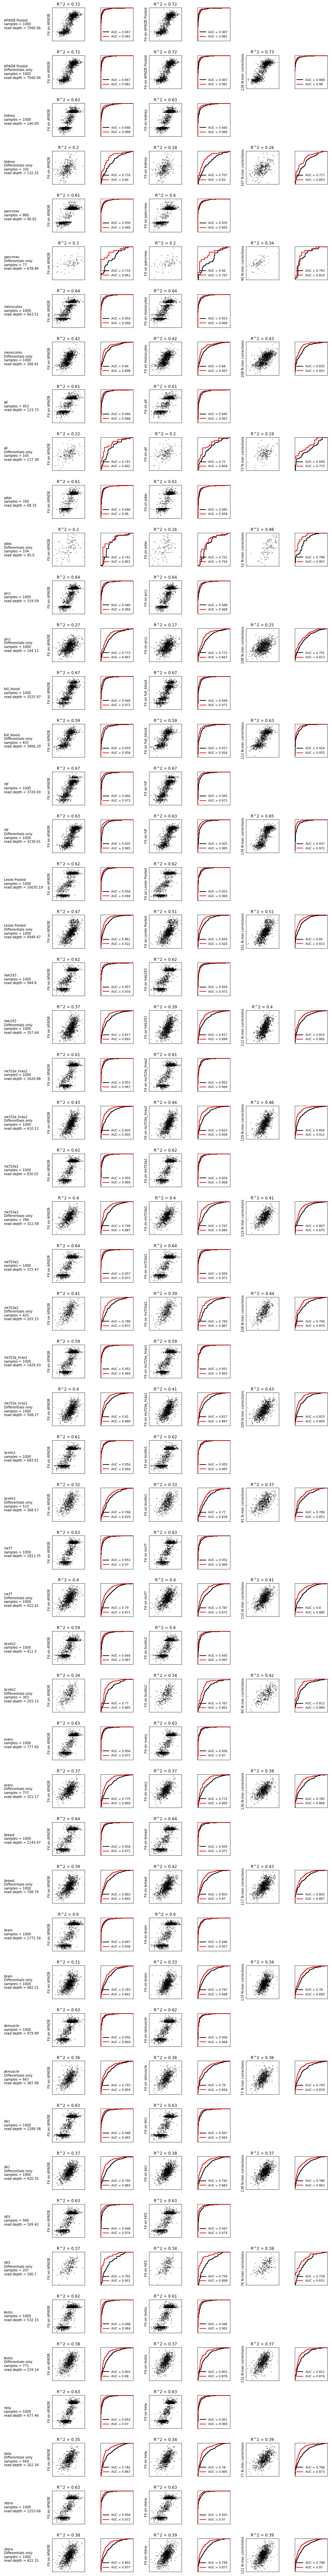

In [26]:
#Plot multiplex results

max_n_members = 1000
show_used_sample_stats_only = True

combined_tissue_index = ['apadb_pooled']
for tissue in apadb_tissue_index :
    combined_tissue_index.append('apadb_' + tissue)
combined_tissue_index.append('leslie_pooled')
for tissue in leslie_tissue_index :
    combined_tissue_index.append('leslie_' + tissue)


n_rows = 2 * len(combined_tissue_index)
n_cols = 7

fig, ax = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue.replace('apadb_pooled', 'APADB Pooled').replace('leslie_pooled', 'Leslie Pooled').replace('apadb_', '').replace('leslie_', '')
    
    #n_samples = min(max_n_members, len(tissue_results_dict['apadb_pooled'][tissue]['y_ratio']))
    n_samples = len(tissue_results_dict['apadb_pooled'][tissue]['y_ratio'])
    avg_reads = round(np.mean(tissue_results_dict['apadb_pooled'][tissue]['y_count']), 1)
    n_samples_diff = len(tissue_results_dict['apadb_pooled_differential'][tissue]['y_ratio'])
    avg_reads_diff = round(np.mean(tissue_results_dict['apadb_pooled_differential'][tissue]['y_count']), 1)
    
    plt.sca(ax[2 * tissue_i, 0])
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.sca(ax[2 * tissue_i + 1, 0])
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled'] :
        tissue_results = tissue_results_dict['apadb_pooled'][tissue]
        n_samples_used, avg_reads_used = plot_tissue_result('Fit on APADB', tissue_results, ax[2 * tissue_i, 1], ax[2 * tissue_i, 2], max_n_members)
        
        if show_used_sample_stats_only :
            n_samples = n_samples_used
            avg_reads = avg_reads_used
    
    #Fitted on tissue
    if tissue in tissue_results_dict and tissue in tissue_results_dict[tissue] :
        tissue_results = tissue_results_dict[tissue][tissue]
        plot_tissue_result('Fit on ' + tissue_name, tissue_results, ax[2 * tissue_i, 3], ax[2 * tissue_i, 4], max_n_members)
    
    #Differentials only
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled_differential'] :
        tissue_results = tissue_results_dict['apadb_pooled_differential'][tissue]
        n_samples_used, avg_reads_used = plot_tissue_result('Fit on APADB', tissue_results, ax[2 * tissue_i + 1, 1], ax[2 * tissue_i + 1, 2], max_n_members)
        
        if show_used_sample_stats_only :
            n_samples_diff = n_samples_used
            avg_reads_diff = avg_reads_used
    
    #Fitted on tissue
    if tissue + '_differential' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_differential'] :
        tissue_results = tissue_results_dict[tissue + '_differential'][tissue]
        plot_tissue_result('Fit on ' + tissue_name, tissue_results, ax[2 * tissue_i + 1, 3], ax[2 * tissue_i + 1, 4], max_n_members)
    
    
    #N-mer corrections, Differentials only
    #Fitted on tissue
    plt.sca(ax[2 * tissue_i, 5])
    plt.axis('off')
    plt.sca(ax[2 * tissue_i, 6])
    plt.axis('off')
    if tissue + '_nmer' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_nmer'] :
        tissue_results = tissue_results_dict[tissue + '_nmer'][tissue]
        plot_tissue_result(str(tissue_results['num_nmers']) + ' N-mer corrections', tissue_results, ax[2 * tissue_i + 1, 5], ax[2 * tissue_i + 1, 6], max_n_members)
    
    
    annot_text = tissue_name + '\n'
    annot_text += 'samples = ' + str(n_samples) + '\n'
    annot_text += 'read depth = ' + str(round(avg_reads, 2))
    ax[2 * tissue_i, 0].text(0.01, 0.5, annot_text, verticalalignment='center', horizontalalignment='left', transform=ax[2 * tissue_i, 0].transAxes, fontsize=10)
    
    annot_text = tissue_name + '\n'
    annot_text += 'Differentials only\n'
    annot_text += 'samples = ' + str(n_samples_diff) + '\n'
    annot_text += 'read depth = ' + str(round(avg_reads_diff, 2))
    ax[2 * tissue_i + 1, 0].text(0.01, 0.5, annot_text, verticalalignment='center', horizontalalignment='left', transform=ax[2 * tissue_i + 1, 0].transAxes, fontsize=10)

plt.tight_layout()
plt.show()


In [37]:
def get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=False) :
    y_logodds_tissue = np.ravel(tissue_results['y_logodds'])
    y_ratio_tissue = np.ravel(tissue_results['y_ratio'])
    y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_hat'])
    y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_hat'])
    y_count_tissue = np.ravel(tissue_results['y_count'])
    
    if use_test :
        y_logodds_tissue = np.ravel(tissue_results['y_logodds_test'])
        y_ratio_tissue = np.ravel(tissue_results['y_ratio_test'])
        y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_test_hat'])
        y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_test_hat'])
        y_count_tissue = np.ravel(tissue_results['y_count_test'])

    if max_n_members is not None :
        sort_index = np.argsort(y_count_tissue)[::-1]
        y_count_tissue = y_count_tissue[sort_index[:max_n_members]]
        y_ratio_tissue = y_ratio_tissue[sort_index[:max_n_members]]
        y_ratio_tissue_hat = y_ratio_tissue_hat[sort_index[:max_n_members]]
        y_logodds_tissue = y_logodds_tissue[sort_index[:max_n_members]]
        y_logodds_tissue_hat = y_logodds_tissue_hat[sort_index[:max_n_members]]

    r_val, p_val = pearsonr(y_logodds_tissue_hat, y_logodds_tissue)
    r_val_ratio, _ = pearsonr(y_ratio_tissue_hat, y_ratio_tissue)

    y_label_tissue = np.zeros(y_ratio_tissue.shape[0])
    y_label_tissue[y_ratio_tissue <= 0.5] = 0
    y_label_tissue[y_ratio_tissue > 0.5] = 1

    fpr, tpr, _ = roc_curve(y_label_tissue, y_ratio_tissue_hat)
    auc = roc_auc_score(y_label_tissue, y_ratio_tissue_hat)
    
    fpr_highconf, tpr_highconf, _ = roc_curve(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])
    auc_highconf = roc_auc_score(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])

    n_samples = len(y_ratio_tissue)
    avg_reads = np.mean(y_count_tissue)
    
    if not highconf_only :
        return round(r_val * r_val, 2), round(auc, 2), fpr, tpr, n_samples, avg_reads, round(r_val_ratio * r_val_ratio, 2)
    else :
        return round(r_val * r_val, 2), round(auc_highconf, 2), fpr_highconf, tpr_highconf, n_samples, avg_reads, round(r_val_ratio * r_val_ratio, 2)

def get_summary_nodf(y_logodds_tissue, y_logodds_tissue_hat, y_ratio_tissue, y_ratio_tissue_hat, y_count_tissue, highconf_only) :
    r_val, p_val = pearsonr(y_logodds_tissue_hat, y_logodds_tissue)

    y_label_tissue = np.zeros(y_ratio_tissue.shape[0])
    y_label_tissue[y_ratio_tissue <= 0.5] = 0
    y_label_tissue[y_ratio_tissue > 0.5] = 1

    fpr, tpr, _ = roc_curve(y_label_tissue, y_ratio_tissue_hat)
    auc = roc_auc_score(y_label_tissue, y_ratio_tissue_hat)
    
    fpr_highconf, tpr_highconf, _ = roc_curve(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])
    auc_highconf = roc_auc_score(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])

    n_samples = len(y_ratio_tissue)
    avg_reads = np.mean(y_count_tissue)
    
    if not highconf_only :
        return round(r_val * r_val, 2), round(auc, 3), fpr, tpr, n_samples, avg_reads
    else :
        return round(r_val * r_val, 2), round(auc_highconf, 3), fpr_highconf, tpr_highconf, n_samples, avg_reads


In [47]:
#Summarize multiplex results

max_n_members = 1000
highconf_only = True
show_used_sample_stats_only = False#True

apadb_blacklist = {}
leslie_blacklist = {'mcf10a1' : True, 'mcf10a_hras1' : True, 'bcells1' : True}

combined_tissue_index = ['apadb_pooled']
for tissue in apadb_tissue_index :
    if tissue not in apadb_blacklist :
        combined_tissue_index.append('apadb_' + tissue)
combined_tissue_index.append('leslie_pooled')
for tissue in leslie_tissue_index :
    if tissue not in leslie_blacklist :
        combined_tissue_index.append('leslie_' + tissue)


r2_tissues_ratios = np.zeros(len(combined_tissue_index))
r2_tissues = np.zeros(len(combined_tissue_index))
r2_tissues_differential = np.zeros(len(combined_tissue_index))
r2_tissues_fitted = np.zeros(len(combined_tissue_index))
r2_tissues_ratios_fitted = np.zeros(len(combined_tissue_index))
r2_tissues_differential_fitted = np.zeros(len(combined_tissue_index))

auc_tissues = np.zeros(len(combined_tissue_index))
auc_tissues_differential = np.zeros(len(combined_tissue_index))
auc_tissues_fitted = np.zeros(len(combined_tissue_index))
auc_tissues_differential_fitted = np.zeros(len(combined_tissue_index))

roc_tissues = []
roc_tissues_differential = []
roc_tissues_fitted = []
roc_tissues_differential_fitted = []

tissue_names = []

n_samples_list = []
n_samples_differential_list = []
avg_reads_list = []
avg_reads_differential_list = []

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue.replace('apadb_pooled', 'APADB Pooled').replace('leslie_pooled', 'Leslie Pooled').replace('apadb_', '').replace('leslie_', '')
    
    n_samples = len(tissue_results_dict['apadb_pooled'][tissue]['y_ratio'])
    avg_reads = round(np.mean(tissue_results_dict['apadb_pooled'][tissue]['y_count']), 1)
    n_samples_diff = len(tissue_results_dict['apadb_pooled_differential'][tissue]['y_ratio'])
    avg_reads_diff = round(np.mean(tissue_results_dict['apadb_pooled_differential'][tissue]['y_count']), 1)
    
    tissue_names.append(tissue_name)
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled'] :
        tissue_results = tissue_results_dict['apadb_pooled'][tissue]
        r2, auc, fpr, tpr, n_samples_used, avg_reads_used, r2_ratios = get_summary(tissue_name, tissue_results, max_n_members, highconf_only)
        r2_tissues[tissue_i] = r2
        r2_tissues_ratios[tissue_i] = r2_ratios
        auc_tissues[tissue_i] = auc
        roc_tissues.append((fpr, tpr))
        
        if show_used_sample_stats_only :
            n_samples = n_samples_used
            avg_reads = avg_reads_used
        
    
    #Fitted on tissue
    if tissue in tissue_results_dict and tissue in tissue_results_dict[tissue] :
        tissue_results = tissue_results_dict[tissue][tissue]
        r2, auc, fpr, tpr, _, _, r2_ratios = get_summary(tissue_name, tissue_results, max_n_members, highconf_only)
        r2_tissues_fitted[tissue_i] = r2
        r2_tissues_ratios_fitted[tissue_i] = r2_ratios
        auc_tissues_fitted[tissue_i] = auc
        roc_tissues_fitted.append((fpr, tpr))
    
    #Differentials only
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled_differential'] :
        tissue_results = tissue_results_dict['apadb_pooled_differential'][tissue]
        r2, auc, fpr, tpr, n_samples_used, avg_reads_used, _ = get_summary(tissue_name, tissue_results, max_n_members, highconf_only)
        r2_tissues_differential[tissue_i] = r2
        auc_tissues_differential[tissue_i] = auc
        roc_tissues_differential.append((fpr, tpr))
        
        if show_used_sample_stats_only :
            n_samples_diff = n_samples_used
            avg_reads_diff = avg_reads_used
    
    #Fitted on tissue
    if tissue + '_differential' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_differential'] :
        tissue_results = tissue_results_dict[tissue + '_differential'][tissue]
        r2, auc, fpr, tpr, _, _, _ = get_summary(tissue_name, tissue_results, max_n_members, highconf_only)
        r2_tissues_differential_fitted[tissue_i] = r2
        auc_tissues_differential_fitted[tissue_i] = auc
        roc_tissues_differential_fitted.append((fpr, tpr))
    
    n_samples_list.append(n_samples)
    n_samples_differential_list.append(n_samples_diff)
    avg_reads_list.append(avg_reads)
    avg_reads_differential_list.append(avg_reads_diff)



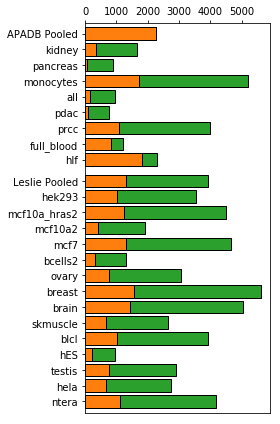

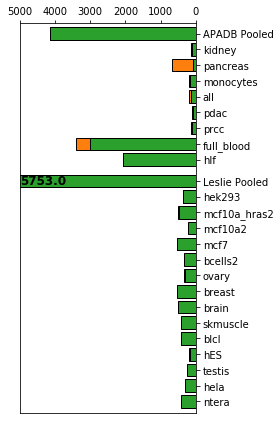

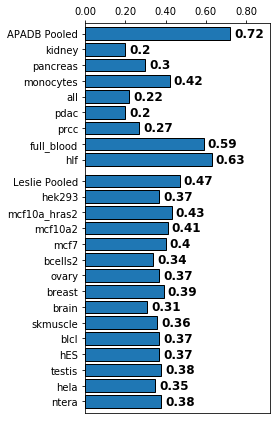

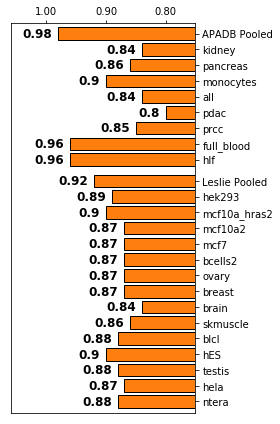

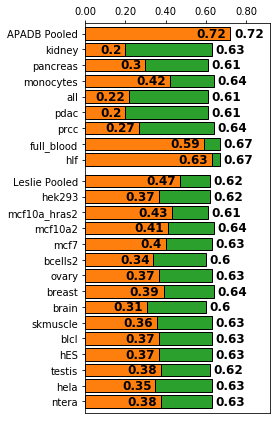

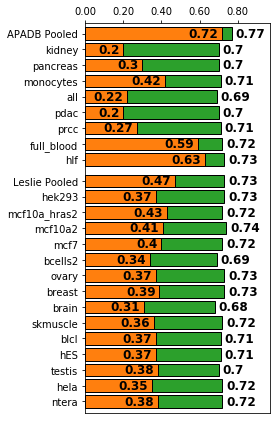

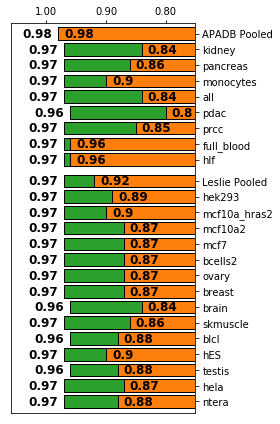

In [49]:
apadb_leslie_separator = 15


#Plot n_samples


y_coords = np.concatenate([np.arange(len(tissue_names))[:apadb_leslie_separator], np.arange(len(tissue_names))[apadb_leslie_separator:] + 0.35])


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#Plot r2, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, n_samples_list[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, n_samples_differential_list[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

'''for i, v in zip(y_coords, n_samples_list[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, n_samples_differential_list[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')
'''
plt.yticks(y_coords, tissue_names[::-1])

#plt.xlim(0, np.max(n_samples_list) + 0.2)
plt.ylim(-0.75, len(tissue_names))

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('num_samples_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('num_samples_bar_all_tissues.eps')
plt.savefig('num_samples_bar_all_tissues.svg')

plt.show()



f = plt.figure(figsize=(4, 6))

max_cutoff = 5000
plt.barh(y_coords, avg_reads_differential_list[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

plt.barh(y_coords, avg_reads_list[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, np.round(avg_reads_list[::-1], 0)):
    if v > max_cutoff :
        plt.gca().text(max_cutoff - 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
#for i, v in zip(y_coords, np.round(avg_reads_differential_list[::-1], 0)):
#    plt.gca().text(v - 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

#plt.xlim(0, np.min(avg_reads_list) - 0.05)
plt.xlim(max_cutoff, 0)
plt.ylim(-0.75, len(tissue_names))

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('avg_reads_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('avg_reads_bar_all_tissues.eps')
plt.savefig('avg_reads_bar_all_tissues.svg')

plt.show()










y_coords = np.concatenate([np.arange(len(tissue_names))[:apadb_leslie_separator], np.arange(len(tissue_names))[apadb_leslie_separator:] + 0.35])


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#Plot r2, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[0], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues_differential) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('cross_validation_r2_bar_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('cross_validation_r2_bar_all_tissues_both_used.svg')

plt.show()



#Plot aucs, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, auc_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, auc_tissues_differential[::-1]):
    plt.gca().text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(1.06, np.min(auc_tissues_differential) - 0.05)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('cross_validation_auc_bar_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('cross_validation_auc_bar_all_tissues_both_used.svg')

plt.show()








#Plot r2

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('cross_validation_r2_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('cross_validation_r2_bar_all_tissues.svg')

plt.show()




#Plot r2 ratios

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues_ratios[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues_ratios[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues_ratios) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('cross_validation_r2_ratios_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('cross_validation_r2_ratios_bar_all_tissues.svg')

plt.show()




#Plot aucs

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, auc_tissues[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, auc_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, auc_tissues[::-1]):
    plt.gca().text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')
for i, v in zip(y_coords, auc_tissues_differential[::-1]):
    plt.gca().text(v - 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(1.06, np.min(np.concatenate([auc_tissues_differential, auc_tissues])) - 0.05)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('cross_validation_auc_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('cross_validation_auc_bar_all_tissues.svg')

plt.show()


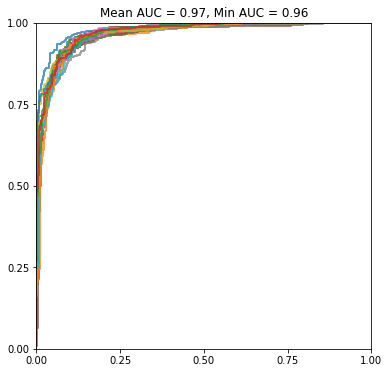

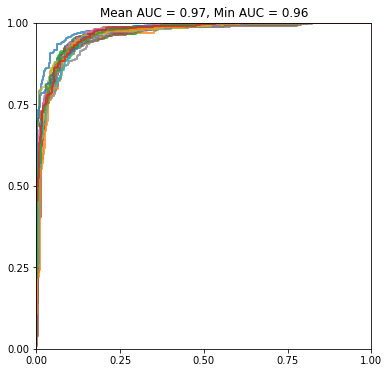

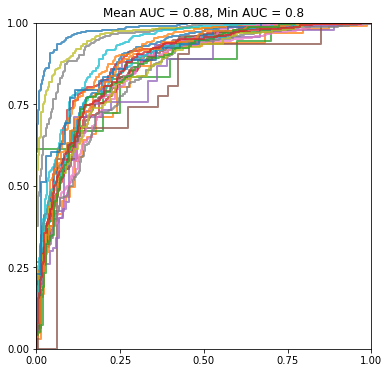

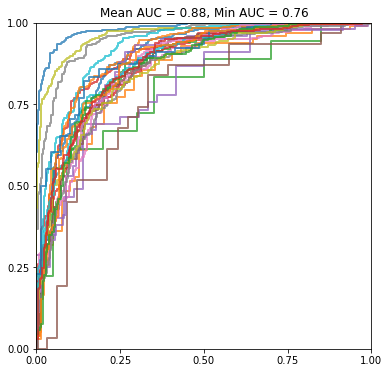

In [154]:
#Plot ROCs

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues[tissue_i]
    fpr, tpr = roc_tissues[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')
    
    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()

plt.savefig('cross_validation_roc_all_tissues_all_sites.png', dpi=150, transparent=True)
plt.savefig('cross_validation_roc_all_tissues_all_sites.svg')

plt.show()

#Plot Fitted ROCs

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_fitted[tissue_i]
    fpr, tpr = roc_tissues_fitted[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()
plt.show()



#Plot ROCs, differentials only

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_differential[tissue_i]
    fpr, tpr = roc_tissues_differential[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()

plt.savefig('cross_validation_roc_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('cross_validation_roc_all_tissues_both_used.svg')

plt.show()

#Plot Fitted ROCs, differentials only

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_differential_fitted[tissue_i]
    fpr, tpr = roc_tissues_differential_fitted[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()
plt.show()

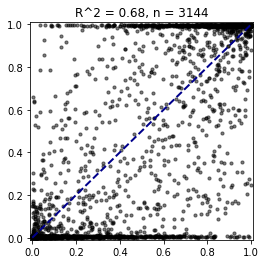

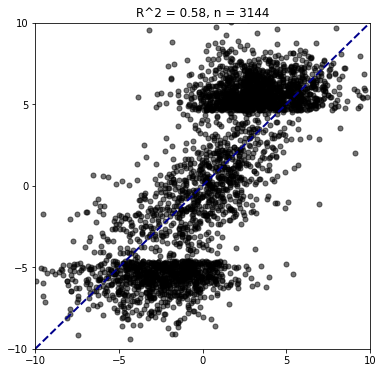

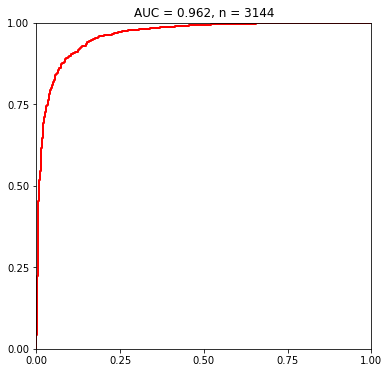

In [241]:
#Plot indivudual tissue result

max_n_members = 10000
highconf_only = True
save_figs = False

data_version = 'cross_validation'

source = 'leslie'
tissue = 'hek293'
special_mode = '_apadb_region'

tissue_results = tissue_results_dict['apadb_pooled'][source + '_' + tissue]

df_tissue = tissue_results['df'].copy()
if data_version == 'test' :
    df_tissue = tissue_results['df_test'].copy()
df_tissue['row_index'] = np.arange(len(df_tissue), dtype=np.int)

#Additional filters

additional_filter = True
site_nums = None#[1]#[1, 2, 3, 4]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.5
min_total_count = 50#1000#500#20
max_cut_region = 60
min_distance = 40
max_distance = 4000

total_count_col = source + '_pair_count' + special_mode + '_' + tissue

#Apply global pre-filters
df_to_use = df_tissue.query(total_count_col + " >= " + str(min_total_count))
df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]
df_to_use = df_to_use.query("(cut_end_prox - cut_start_prox <= " + str(max_cut_region) + ") and (cut_end_dist - cut_start_dist <= " + str(max_cut_region) + ")")
df_to_use = df_to_use.query("(distance >= " + str(min_distance) + ") and (distance <= " + str(max_distance) + ")")

df_to_use = df_to_use.query("mirna_prox == mirna_dist")
df_to_use = df_to_use.query("mirna_prox == 'None' and mirna_dist == 'None'")

keep_index = np.ravel(df_to_use['row_index'])

if data_version != 'test' :
    y_logodds_tissue = np.ravel(tissue_results['y_logodds'])[keep_index]
    y_ratio_tissue = np.ravel(tissue_results['y_ratio'])[keep_index]
    y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_hat'])[keep_index]
    y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_hat'])[keep_index]
    y_count_tissue = np.ravel(tissue_results['y_count'])[keep_index]
else :
    y_logodds_tissue = np.ravel(tissue_results['y_logodds_test'])[keep_index]
    y_ratio_tissue = np.ravel(tissue_results['y_ratio_test'])[keep_index]
    y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_test_hat'])[keep_index]
    y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_test_hat'])[keep_index]
    y_count_tissue = np.ravel(tissue_results['y_count_test'])[keep_index]

if max_n_members is not None :
    sort_index = np.argsort(y_count_tissue)[::-1]
    y_count_tissue = y_count_tissue[sort_index[:max_n_members]]
    y_ratio_tissue = y_ratio_tissue[sort_index[:max_n_members]]
    y_ratio_tissue_hat = y_ratio_tissue_hat[sort_index[:max_n_members]]
    y_logodds_tissue = y_logodds_tissue[sort_index[:max_n_members]]
    y_logodds_tissue_hat = y_logodds_tissue_hat[sort_index[:max_n_members]]

r2, auc, fpr, tpr, n_samples_used, avg_reads_used = get_summary_nodf(y_logodds_tissue, y_logodds_tissue_hat, y_ratio_tissue, y_ratio_tissue_hat, y_count_tissue, highconf_only)




#Plot ratio scatter

ratio_r_val, _ = pearsonr(y_ratio_tissue_hat, y_ratio_tissue)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_ratio_tissue_hat, y_ratio_tissue, c = 'black', s=10, alpha=0.5)
plt.plot([0, 1], [0, 1], color='darkblue', linewidth=2, linestyle='--')

plt.xlim(0-0.01, 1+0.01)
plt.ylim(0-0.01, 1+0.01)

plt.title('R^2 = ' + str(round(ratio_r_val * ratio_r_val, 2)) + ', n = ' + str(y_ratio_tissue.shape[0]))

if save_figs :
    plt.savefig(data_version + '_ratios_' + source + '_' + tissue + '.png', dpi=150, transparent=True)
    plt.savefig(data_version + '_ratios_' + source + '_' + tissue + '.svg')

plt.show()

#Plot Cross-validation R^2

f = plt.figure(figsize=(6, 6))

xlim = [-10, 10]
ylim = [-10, 10]

plt.scatter(y_logodds_tissue_hat, y_logodds_tissue, c = 'black', s = 1 * np.pi * (2 * np.ones(1))**3, alpha=0.55)
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color='darkblue', linewidth=2, linestyle='--')

plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

plt.xticks([xlim[0], -5, 0, 5, xlim[1]])
plt.yticks([ylim[0], -5, 0, 5, ylim[1]])

plt.title('R^2 = ' + str(r2) + ', n = ' + str(y_logodds_tissue.shape[0]))

if save_figs :
    plt.savefig(data_version + '_scatter_' + source + '_' + tissue + '.png', dpi=150, transparent=True)
    plt.savefig(data_version + '_scatter_' + source + '_' + tissue + '.svg')

plt.show()

#Plot Cross-validation ROC

f = plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, color='red', linewidth=2, linestyle='-')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.title('AUC = ' + str(auc) + ', n = ' + str(y_logodds_tissue.shape[0]))

if save_figs :
    plt.savefig(data_version + '_roc_' + source + '_' + tissue + '.png', dpi=150, transparent=True)
    plt.savefig(data_version + '_roc_' + source + '_' + tissue + '.svg')

plt.show()


In [299]:
#Summarize multiplex results, test set only

max_n_members = 1000
highconf_only = True
show_used_sample_stats_only = True

combined_tissue_index = ['apadb_pooled']
for tissue in apadb_tissue_index :
    if tissue not in apadb_blacklist :
        combined_tissue_index.append('apadb_' + tissue)
combined_tissue_index.append('leslie_pooled')
for tissue in leslie_tissue_index :
    if tissue not in leslie_blacklist :
        combined_tissue_index.append('leslie_' + tissue)


r2_tissues_ratios = np.zeros(len(combined_tissue_index))
r2_tissues = np.zeros(len(combined_tissue_index))
r2_tissues_differential = np.zeros(len(combined_tissue_index))
r2_tissues_fitted = np.zeros(len(combined_tissue_index))
r2_tissues_ratios_fitted = np.zeros(len(combined_tissue_index))
r2_tissues_differential_fitted = np.zeros(len(combined_tissue_index))

auc_tissues = np.zeros(len(combined_tissue_index))
auc_tissues_differential = np.zeros(len(combined_tissue_index))
auc_tissues_fitted = np.zeros(len(combined_tissue_index))
auc_tissues_differential_fitted = np.zeros(len(combined_tissue_index))
auc_tissues_differential_nmers_fitted = np.zeros(len(combined_tissue_index))

roc_tissues = []
roc_tissues_differential = []
roc_tissues_fitted = []
roc_tissues_differential_fitted = []
roc_tissues_differential_nmers_fitted = []

tissue_names = []

n_samples_list = []
n_samples_differential_list = []
avg_reads_list = []
avg_reads_differential_list = []

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue.replace('apadb_pooled', 'APADB Pooled').replace('leslie_pooled', 'Leslie Pooled').replace('apadb_', '').replace('leslie_', '')
    
    n_samples = len(tissue_results_dict['apadb_pooled'][tissue]['y_ratio'])
    avg_reads = round(np.mean(tissue_results_dict['apadb_pooled'][tissue]['y_count']), 1)
    n_samples_diff = len(tissue_results_dict['apadb_pooled_differential'][tissue]['y_ratio'])
    avg_reads_diff = round(np.mean(tissue_results_dict['apadb_pooled_differential'][tissue]['y_count']), 1)
    
    tissue_names.append(tissue_name)
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled'] :
        tissue_results = tissue_results_dict['apadb_pooled'][tissue]
        r2, auc, fpr, tpr, n_samples_used, avg_reads_used, r2_ratios = get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=True)
        r2_tissues[tissue_i] = r2
        r2_tissues_ratios[tissue_i] = r2_ratios
        auc_tissues[tissue_i] = auc
        roc_tissues.append((fpr, tpr))
        
        if show_used_sample_stats_only :
            n_samples = n_samples_used
            avg_reads = avg_reads_used
        
    
    #Fitted on tissue
    if tissue in tissue_results_dict and tissue in tissue_results_dict[tissue] :
        tissue_results = tissue_results_dict[tissue][tissue]
        r2, auc, fpr, tpr, _, _, r2_ratios = get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=True)
        r2_tissues_fitted[tissue_i] = r2
        r2_tissues_ratios_fitted[tissue_i] = r2_ratios
        auc_tissues_fitted[tissue_i] = auc
        roc_tissues_fitted.append((fpr, tpr))
    
    #Differentials only
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled_differential'] :
        tissue_results = tissue_results_dict['apadb_pooled_differential'][tissue]
        r2, auc, fpr, tpr, n_samples_used, avg_reads_used, _ = get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=True)
        r2_tissues_differential[tissue_i] = r2
        auc_tissues_differential[tissue_i] = auc
        roc_tissues_differential.append((fpr, tpr))
        
        if show_used_sample_stats_only :
            n_samples_diff = n_samples_used
            avg_reads_diff = avg_reads_used
    
    #Fitted on tissue
    if tissue + '_differential' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_differential'] :
        tissue_results = tissue_results_dict[tissue + '_differential'][tissue]
        r2, auc, fpr, tpr, _, _, _ = get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=True)
        r2_tissues_differential_fitted[tissue_i] = r2
        auc_tissues_differential_fitted[tissue_i] = auc
        roc_tissues_differential_fitted.append((fpr, tpr))
    
    n_samples_list.append(n_samples)
    n_samples_differential_list.append(n_samples_diff)
    avg_reads_list.append(avg_reads)
    avg_reads_differential_list.append(avg_reads_diff)



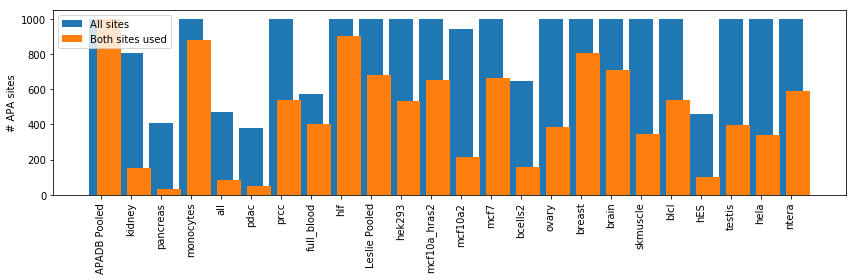

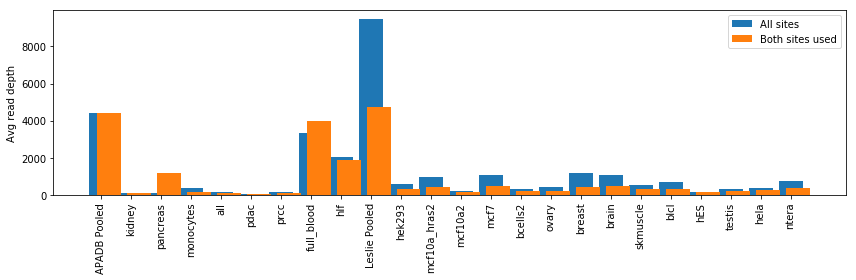

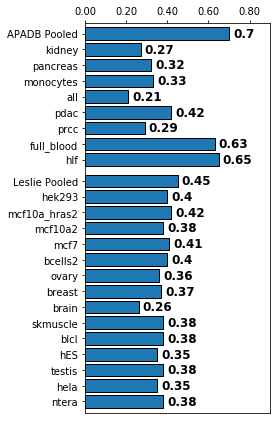

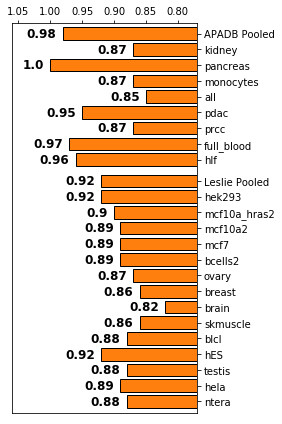

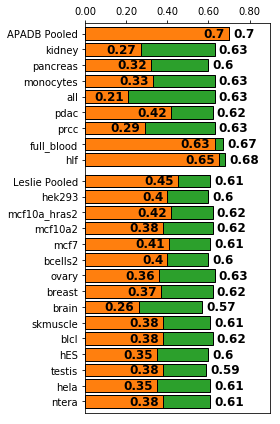

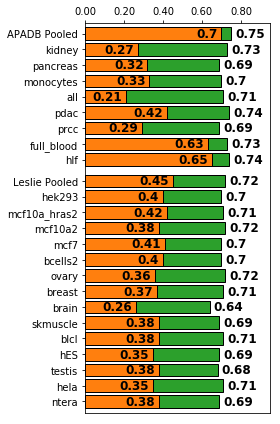

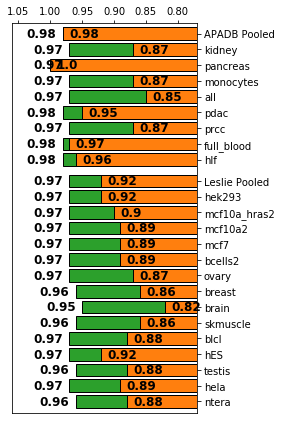

In [300]:

#Plot n_samples

f = plt.figure(figsize=(12, 4))

ls = []

plt.bar(np.arange(len(tissue_names)), n_samples_list, label='All sites')

plt.bar(np.arange(len(tissue_names)) + 0.25, n_samples_differential_list, label='Both sites used')

plt.xticks(np.arange(len(tissue_names)), tissue_names, rotation=90)

plt.ylabel('# APA sites')

plt.legend()

plt.tight_layout()
plt.show()

#Plot avg_reads

f = plt.figure(figsize=(12, 4))

ls = []

plt.bar(np.arange(len(tissue_names)), avg_reads_list, label='All sites')

plt.bar(np.arange(len(tissue_names)) + 0.25, avg_reads_differential_list, label='Both sites used')

plt.xticks(np.arange(len(tissue_names)), tissue_names, rotation=90)

plt.ylabel('Avg read depth')

plt.legend()

plt.tight_layout()
plt.show()







apadb_leslie_separator = 15

y_coords = np.concatenate([np.arange(len(tissue_names))[:apadb_leslie_separator], np.arange(len(tissue_names))[apadb_leslie_separator:] + 0.35])


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#Plot r2, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[0], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues_differential) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('test_r2_bar_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('test_r2_bar_all_tissues_both_used.svg')

plt.show()



#Plot aucs, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, auc_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, auc_tissues_differential[::-1]):
    plt.gca().text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(1.06, np.min(auc_tissues_differential) - 0.05)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('test_auc_bar_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('test_auc_bar_all_tissues_both_used.svg')

plt.show()








#Plot r2

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('test_r2_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('test_r2_bar_all_tissues.svg')

plt.show()




#Plot r2 ratios

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues_ratios[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues_ratios[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues_ratios) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('test_r2_ratios_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('test_r2_ratios_bar_all_tissues.svg')

plt.show()




#Plot aucs

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, auc_tissues[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, auc_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, auc_tissues[::-1]):
    plt.gca().text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')
for i, v in zip(y_coords, auc_tissues_differential[::-1]):
    plt.gca().text(v - 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(1.06, np.min(np.concatenate([auc_tissues_differential, auc_tissues])) - 0.05)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('test_auc_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('test_auc_bar_all_tissues.svg')

plt.show()


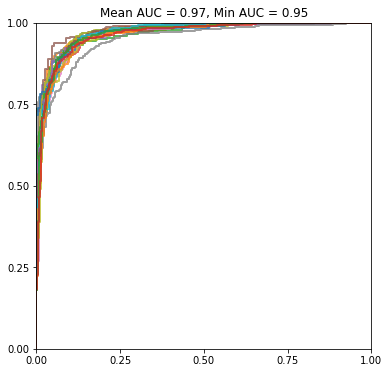

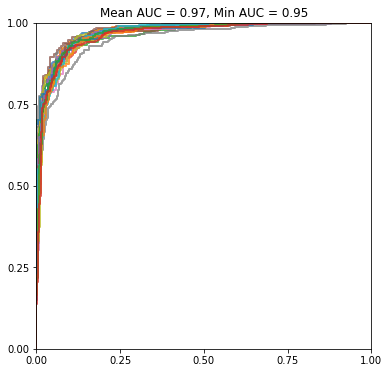

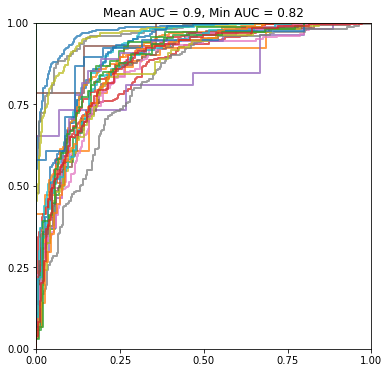

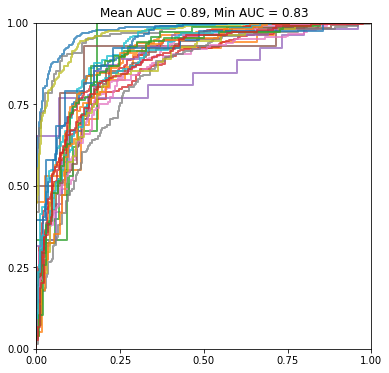

In [301]:
#Plot ROCs

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues[tissue_i]
    fpr, tpr = roc_tissues[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')
    
    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()

plt.savefig('test_roc_all_tissues_all_sites.png', dpi=150, transparent=True)
plt.savefig('test_roc_all_tissues_all_sites.svg')

plt.show()

#Plot Fitted ROCs

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_fitted[tissue_i]
    fpr, tpr = roc_tissues_fitted[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()
plt.show()



#Plot ROCs, differentials only

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_differential[tissue_i]
    fpr, tpr = roc_tissues_differential[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()

plt.savefig('test_roc_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('test_roc_all_tissues_both_used.svg')

plt.show()

#Plot Fitted ROCs, differentials only

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_differential_fitted[tissue_i]
    fpr, tpr = roc_tissues_differential_fitted[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()
plt.show()

In [167]:
#Fit model on APADB

X_apadb, y_ratio_apadb, y_logodds_apadb, _, _ = get_data(df_all, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=True)

_, _, _, _, w_bundle_linear = fit_linear_model(X_apadb, y_logodds_apadb, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)
w_linear, w_linear_0 = w_bundle_linear

_, _, _, _, w_bundle_logistic = fit_logistic_model(X_apadb, y_ratio_apadb, X_apadb, y_ratio_apadb, l2_lambda=0.0)
w_logistic, w_logistic_0 = w_bundle_logistic


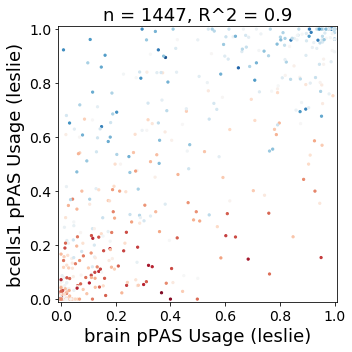

In [219]:
#Differential pairwise site usage analysis, individual scatters

site_nums = [1, 2]#None#[1, 2, 3, 4, 5]
prox_site_types = ['UTR3', 'Extension']#, , 'Extension'
dist_site_types = ['UTR3', 'Extension']#, , 'Extension'
pseudo_count = 0.0
min_total_count = 20#100
only_differentials = False
use_logodds = False
color_by_sitenum = False

pred_special_mode = '_apadb_region'

source_data_1 = 'leslie'
tissue_1 = 'brain'
special_mode_1 = '_apadb_region'

source_data_2 = 'leslie'
tissue_2 = 'bcells1'
special_mode_2 = '_apadb_region' #_apadb_region

count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
#df_to_use = df_to_use.query(count_col_1 + " / " + total_count_col_1 + " != " + count_col_2 + " / " + total_count_col_2)

df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(prox_site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(dist_site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

if only_differentials :
    df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
    df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

true_metric_tissue_1 = np.ravel((df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count))
true_metric_tissue_2 = np.ravel((df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count))


prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)
X = np.concatenate([
    prox_score,
    dist_score,
    distance,
], axis=1)

pred_metric = predict_logistic_model(X, w_logistic, w_logistic_0)



if use_logodds :
    true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
    true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))
    pred_metric = predict_linear_model(X, w_linear, w_linear_0)

r_val, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)

f = plt.figure(figsize=(5, 5))

if not color_by_sitenum :
    #plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=1.0, s=5, c='black')
    
    plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=1.0, s=5, c=(pred_metric - true_metric_tissue_2), cmap='RdBu_r')
    
else :
    sitenums = np.ravel(df_to_use['sitenum'].values)
    for sitenum in np.unique(sitenums) :
        if np.any(sitenums == sitenum) :
            plt.scatter(true_metric_tissue_1[sitenums == sitenum], true_metric_tissue_2[sitenums == sitenum], label='Site ' + str(sitenum), alpha=0.25, s=5)

    plt.legend(fontsize=14, frameon=True, framealpha=0.5, loc='lower right')

plt.xlabel(tissue_1.replace('_', ' ') + ' pPAS Usage (' + source_data_1 + ')', fontsize=18)
plt.ylabel(tissue_2.replace('_', ' ') + ' pPAS Usage (' + source_data_2 + ')', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if not use_logodds :
    plt.xlim(0-0.01, 1+0.01)
    plt.ylim(0-0.01, 1+0.01)

plt.title('n = ' + str(len(df_to_use)) + ', R^2 = ' + str(round(r_val * r_val, 2)), fontsize=18)

plt.tight_layout()
plt.show()


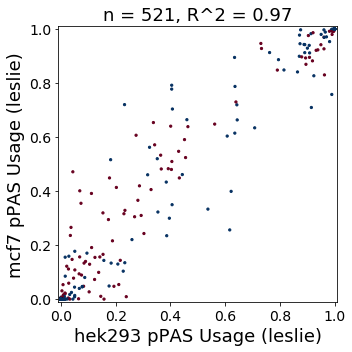

In [242]:
#Differential pairwise site usage analysis, individual scatters

site_nums = [1]#None#[1, 2]#None#[1, 2, 3, 4, 5]
prox_site_types = ['UTR3', 'Extension']#, , 'Extension'
dist_site_types = ['UTR3', 'Extension']#, , 'Extension'
pseudo_count = 0.0
min_total_count = 100#100
only_differentials = False
use_logodds = False
color_by_sitenum = False

pred_special_mode = '_apadb_region'

source_data_1 = 'leslie'
tissue_1 = 'hek293'
special_mode_1 = '_apadb_region'

source_data_2 = 'leslie'
tissue_2 = 'mcf7'
special_mode_2 = '_apadb_region' #_apadb_region

count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
#df_to_use = df_to_use.query(count_col_1 + " / " + total_count_col_1 + " != " + count_col_2 + " / " + total_count_col_2)

df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(prox_site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(dist_site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

if only_differentials :
    df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
    df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

true_metric_tissue_1 = np.ravel((df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count))
true_metric_tissue_2 = np.ravel((df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count))


prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)
X = np.concatenate([
    prox_score,
    dist_score,
    distance,
], axis=1)

pred_metric = predict_logistic_model(X, w_logistic, w_logistic_0)



if use_logodds :
    true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
    true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))
    pred_metric = predict_linear_model(X, w_linear, w_linear_0)

r_val, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)

f = plt.figure(figsize=(5, 5))

if not color_by_sitenum :
    #plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=0.5, s=5, c='black')
    
    min_cl = np.argmin(np.concatenate([np.abs(pred_metric - true_metric_tissue_1).reshape(-1, 1), np.abs(pred_metric - true_metric_tissue_2).reshape(-1, 1)], axis=1), axis=1)
    
    plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=1.0, s=5, c=min_cl, cmap='RdBu_r')
    
else :
    sitenums = np.ravel(df_to_use['sitenum'].values)
    for sitenum in np.unique(sitenums) :
        if np.any(sitenums == sitenum) :
            plt.scatter(true_metric_tissue_1[sitenums == sitenum], true_metric_tissue_2[sitenums == sitenum], label='Site ' + str(sitenum), alpha=0.25, s=5)

    plt.legend(fontsize=14, frameon=True, framealpha=0.5, loc='lower right')

plt.xlabel(tissue_1.replace('_', ' ') + ' pPAS Usage (' + source_data_1 + ')', fontsize=18)
plt.ylabel(tissue_2.replace('_', ' ') + ' pPAS Usage (' + source_data_2 + ')', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if not use_logodds :
    plt.xlim(0-0.01, 1+0.01)
    plt.ylim(0-0.01, 1+0.01)

plt.title('n = ' + str(len(df_to_use)) + ', R^2 = ' + str(round(r_val * r_val, 2)), fontsize=18)

plt.tight_layout()
plt.show()
